# Problem Set 1 (Take Home) - 40 points

# PS 1.A - 20 points

In [this video](https://www.youtube.com/watch?v=ho6JXE3EbZ8) the author explains how to extract various visualizations of what CNNs learn. [Your course site](https://pantelis.github.io/artificial-intelligence/aiml-common/lectures/cnn/cnn-example-architectures/visualizing-what-convnets-learn.html) also covers the topic.

Using the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html), train a ResNet-50 based CNN on the classification task of $K=9$ classes (filter out the class `ship`) and create the following visualizations for first, middle and last blocks of ResNet-50. You are free to select a class to showcase such visualizations.

* Visualizing intermediate convnet outputs (“intermediate activations”). This is useful to understand how successive convnet layers transform their input.

* Visualizing convnets filters. This is useful to understand precisely what visual pattern or concept each filter in a convnet is receptive to.

* Visualizing heatmaps of class activation in an image. This is useful to understand which part of an image where identified as belonging to a given class, and thus allows to localize objects in images.


## Data Preparation

### Load the CIFAR-10 Data

In [ ]:
!pip install --upgrade tensorflow
!pip install --upgrade keras

In [189]:
import pickle
import numpy as np

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Load training data
train_data = None
train_labels = []

for i in range(1, 6):
    batch_name = f"data_batch_{i}"
    batch_data = unpickle(batch_name)
    if i == 1:
        train_data = batch_data[b'data']
    else:
        train_data = np.vstack((train_data, batch_data[b'data']))
    train_labels.extend(batch_data[b'labels'])

train_data = np.array(train_data)
train_labels = np.array(train_labels)

# Load test data
test_data_dict = unpickle("test_batch")
test_data = np.array(test_data_dict[b'data'])
test_labels = np.array(test_data_dict[b'labels'])

# Load label names
label_names = unpickle("batches.meta")[b'label_names']
label_names = [name.decode('utf-8') for name in label_names]
print(label_names)  # This should print out the class names


['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### Remove the 'ship' class

In [190]:
# Identify the indices of the 'ship' class
train_ship_indices = np.where(train_labels == 8)[0]
test_ship_indices = np.where(test_labels == 8)[0]

# Remove the 'ship' class data and labels
train_data = np.delete(train_data, train_ship_indices, axis=0)
train_labels = np.delete(train_labels, train_ship_indices)

test_data = np.delete(test_data, test_ship_indices, axis=0)
test_labels = np.delete(test_labels, test_ship_indices)

# Adjust the labels greater than the 'ship' class
train_labels[train_labels > 7] -= 1
test_labels[test_labels > 7] -= 1

# Remove the 'ship' label name from the list
label_names.pop(8)

'ship'

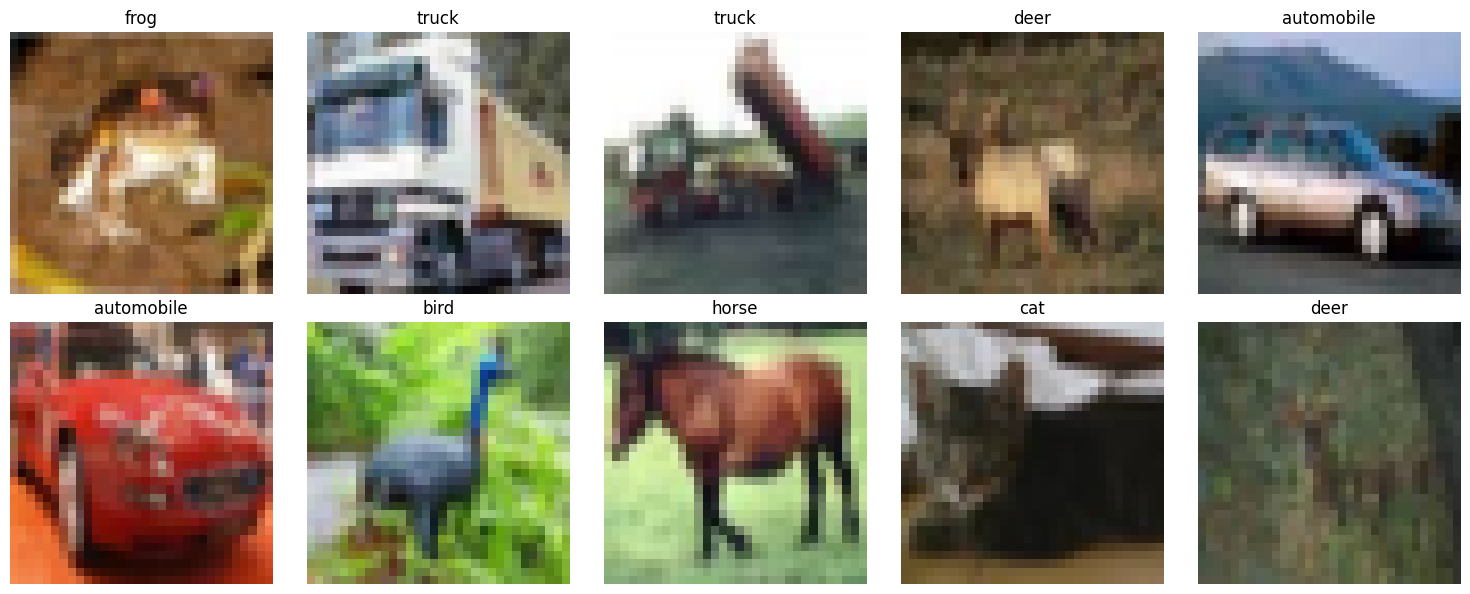

In [191]:
import matplotlib.pyplot as plt

# Reshape the data
train_data = train_data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
test_data = test_data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

# Plot some sample images
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(train_data[i])
    ax.set_title(label_names[train_labels[i]])
    ax.axis('off')

plt.tight_layout()
plt.show()


### Preprocess the data for ResNet-50

In [192]:
from tensorflow.keras.utils import to_categorical

# Normalize data
train_data = train_data.astype('float32') / 255.0
test_data = test_data.astype('float32') / 255.0

# Convert labels to categorical (one-hot encoding)
train_labels = to_categorical(train_labels, 9)
test_labels = to_categorical(test_labels, 9)

## Train a ResNet-50 on the Modified CIFAR-10 Dataset

### Load the ResNet-50 model

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Initialize ResNet-50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Define the final model architecture
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(9, activation='softmax')  # 9 classes
])

for layer in base_model.layers:
    layer.trainable = False


### Compile and train the model

In [ ]:
from tensorflow.keras.optimizers import Adam

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_data, train_labels, epochs=100, batch_size=32, validation_data=(test_data, test_labels))

### Save the trained model

In [ ]:
model.save("resnet50_cifar10_modified.h5")
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 9)                 2313      
                                                                 
Total params: 24114569 (91.99 MB)
Trainable params: 526857 (2.01 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


## Visualizing Intermediate Activations

In [193]:
from tensorflow.keras.models import load_model

model = load_model('resnet50_cifar10_modified.h5')

### Selecting Class

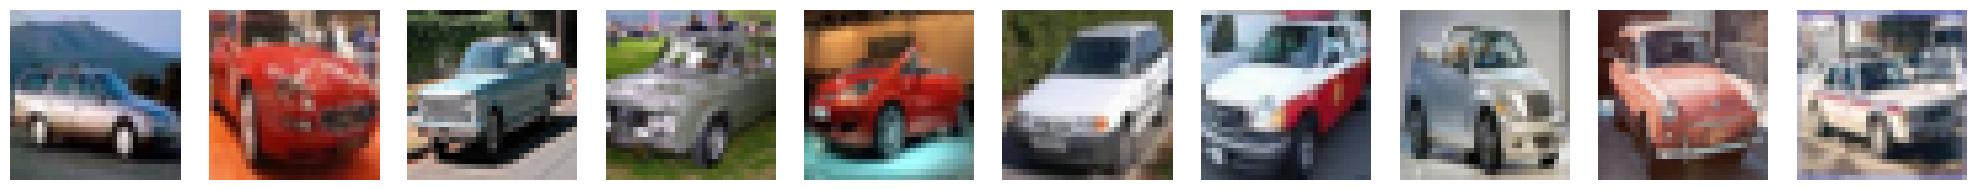

In [ ]:
from tensorflow.keras.models import Model

# Retrieve images from class
class_indices = np.where(train_labels[:, 1] == 1)[0]
class_images = train_data[class_indices]

# Display the first 10 images of class
fig, axes = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    ax = axes[i]
    ax.imshow(class_images[i])
    ax.axis('off')

plt.tight_layout()
plt.show()

### Helper Function

In [ ]:
# Define a function to display activations for a specific layer and image
def display_activation(activations, col_size, row_size, layer_index):
    activation = activations[layer_index]

    num_features = col_size * row_size

    # Check if the layer has enough feature maps to display
    if activation.shape[-1] < num_features:
        print(f"Layer {layer_index} has only {activation.shape[-1]} feature maps.")
        return

    # Initialize the display grid
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5, col_size*2.5))

    for row in range(0, row_size):
        for col in range(0, col_size):
            activation_index = col + (row * col_size)

            # Display the feature map
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='viridis')
            ax[row][col].axis('off')

    plt.tight_layout()
    plt.show()

### Visualize the activations:

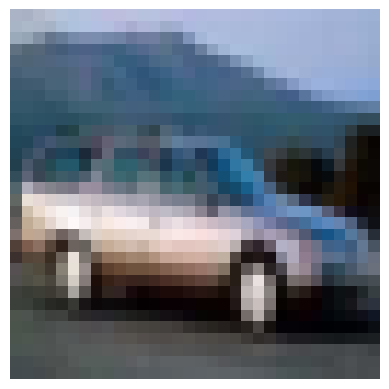

1/1 [==============================] - 0s 145ms/step
Layer 0 has only 3 feature maps.
Layer 1 has only 3 feature maps.


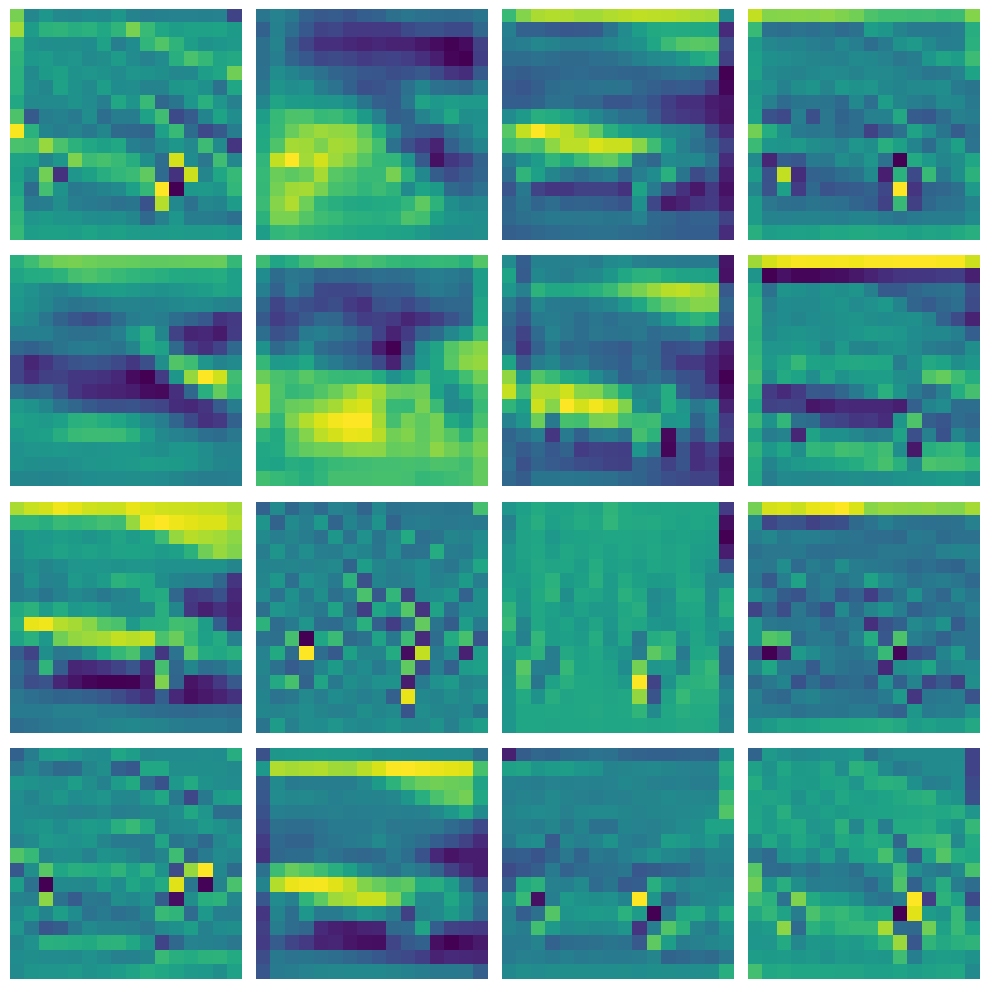

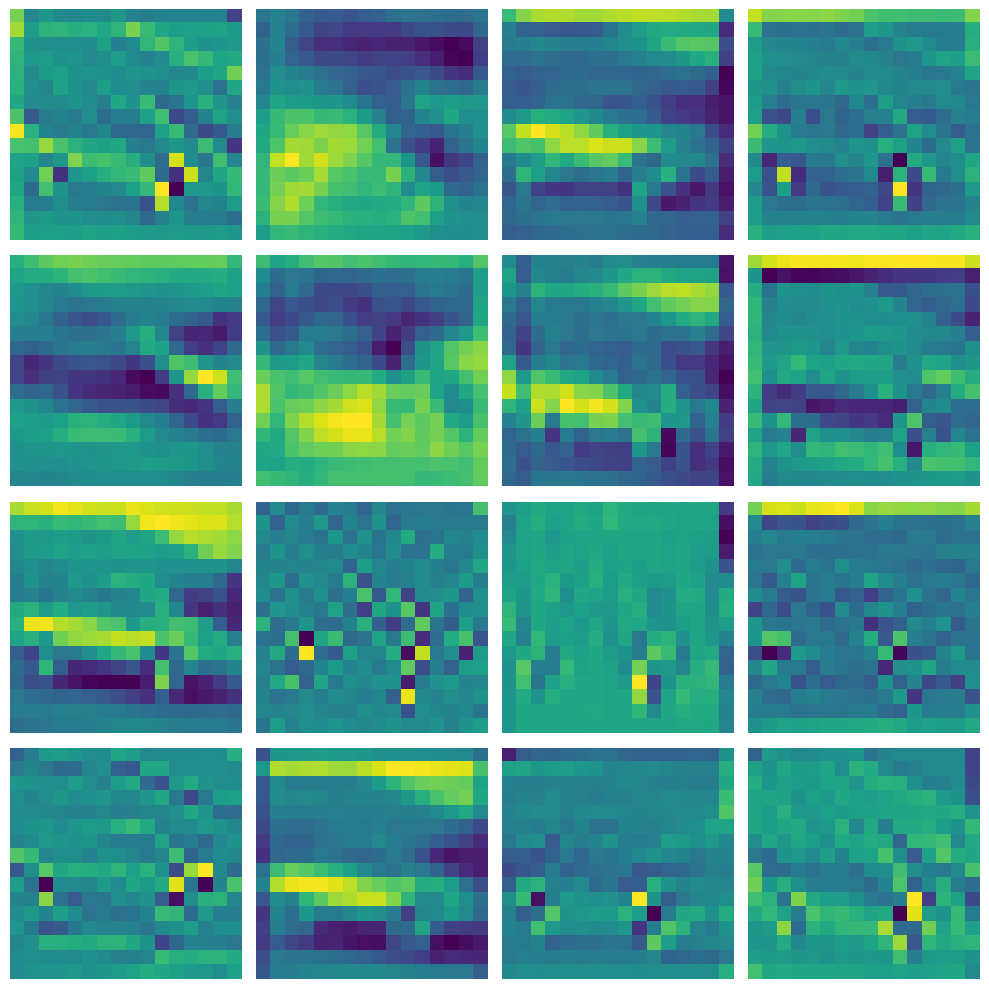

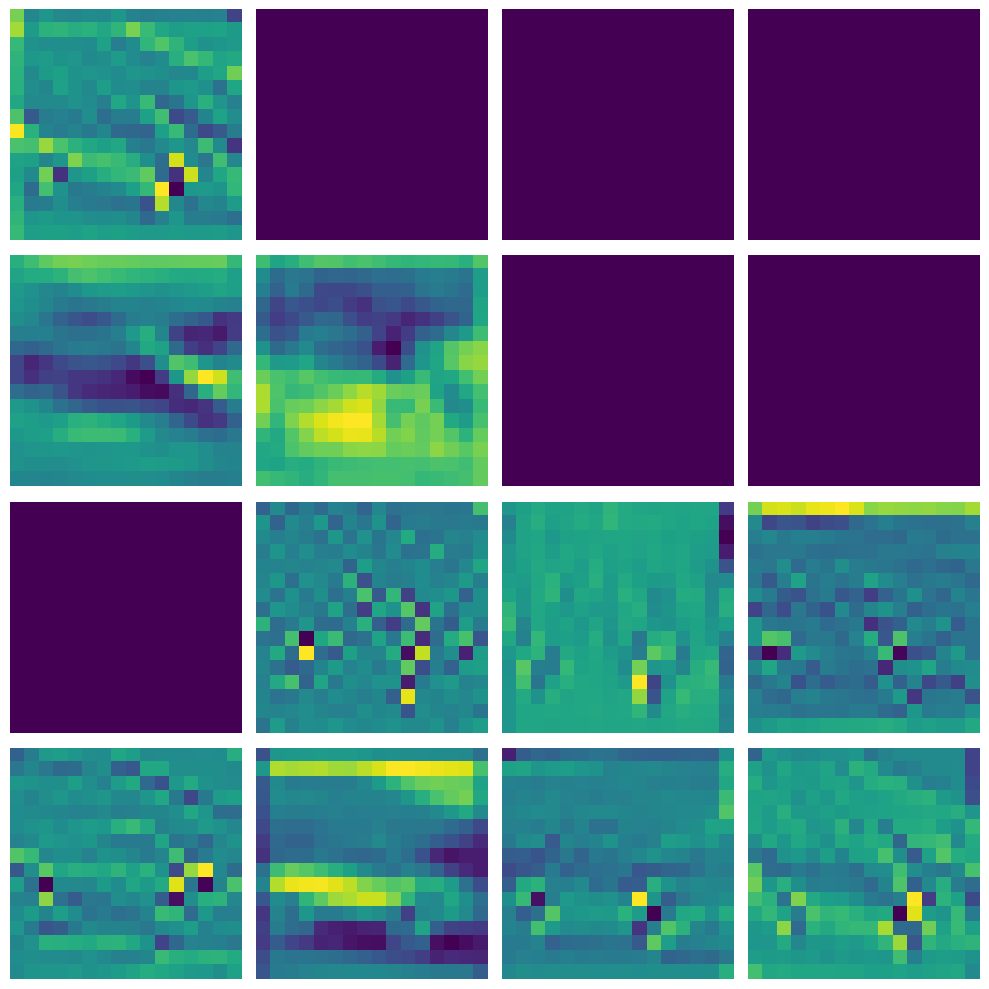

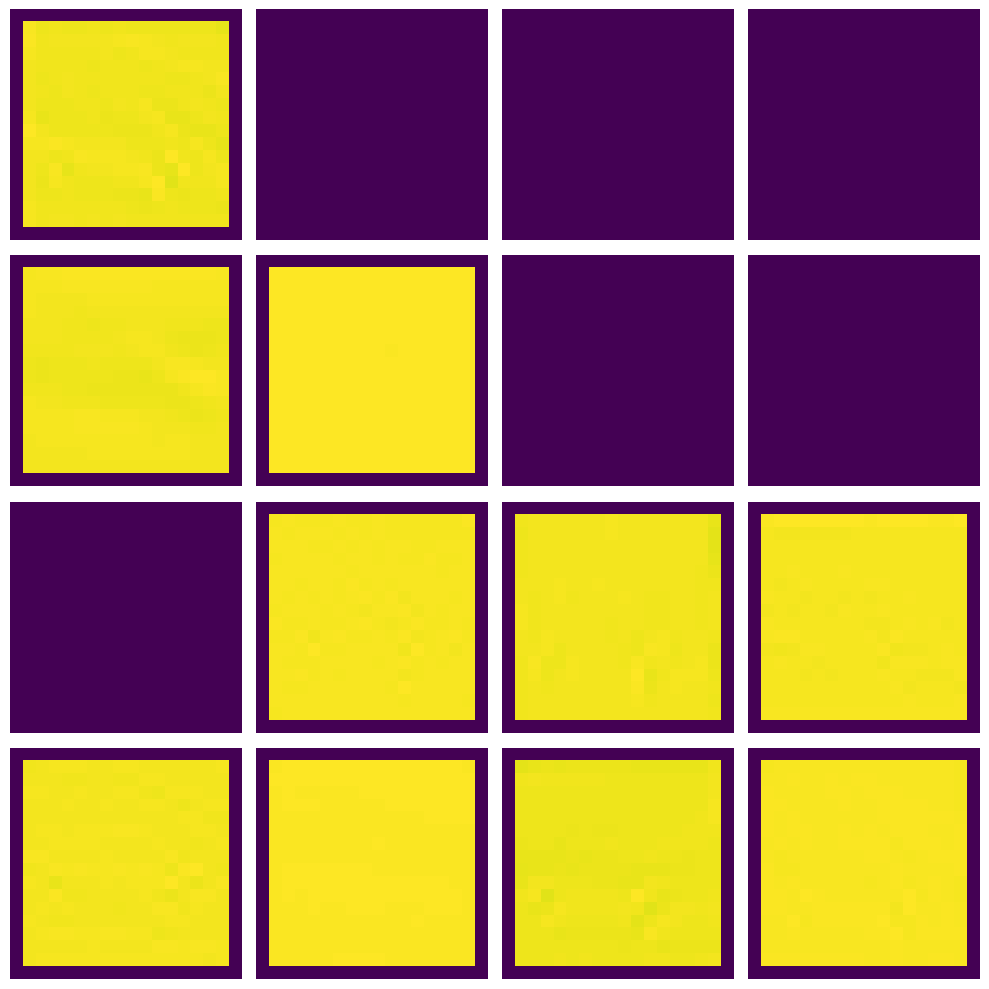

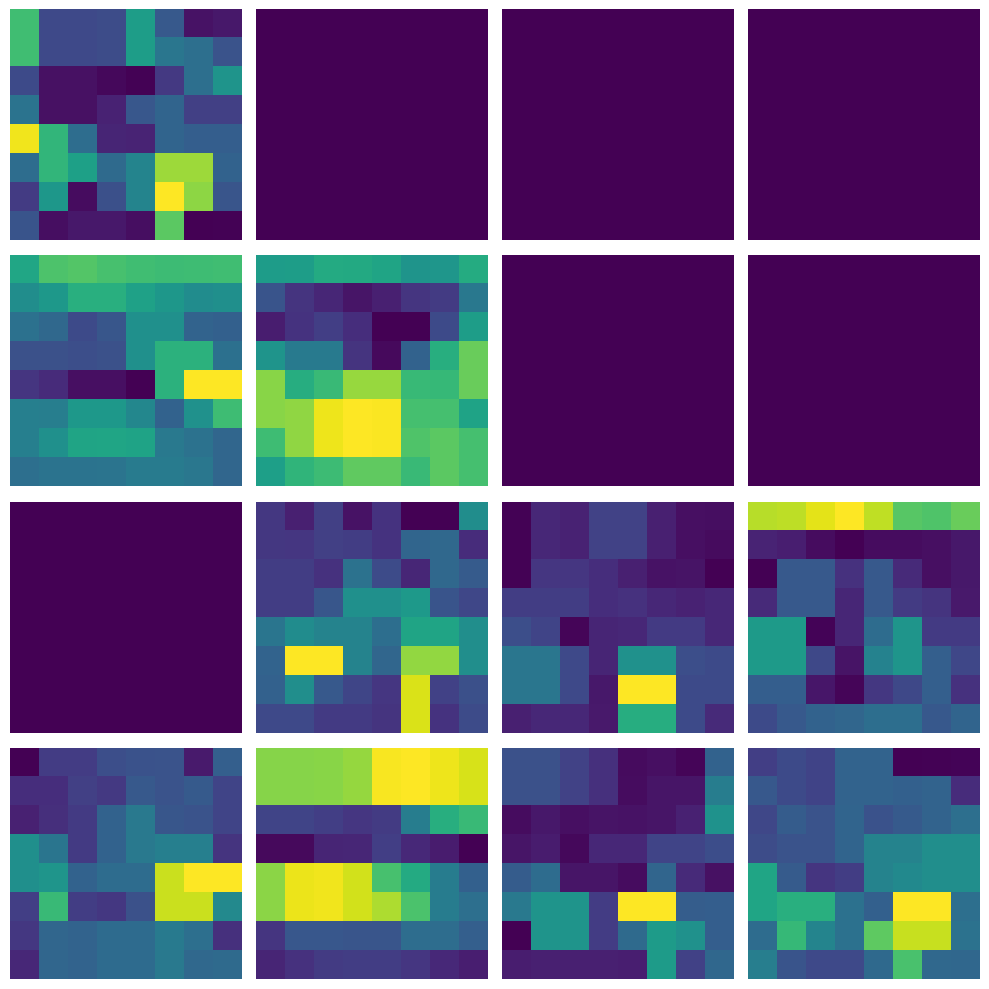

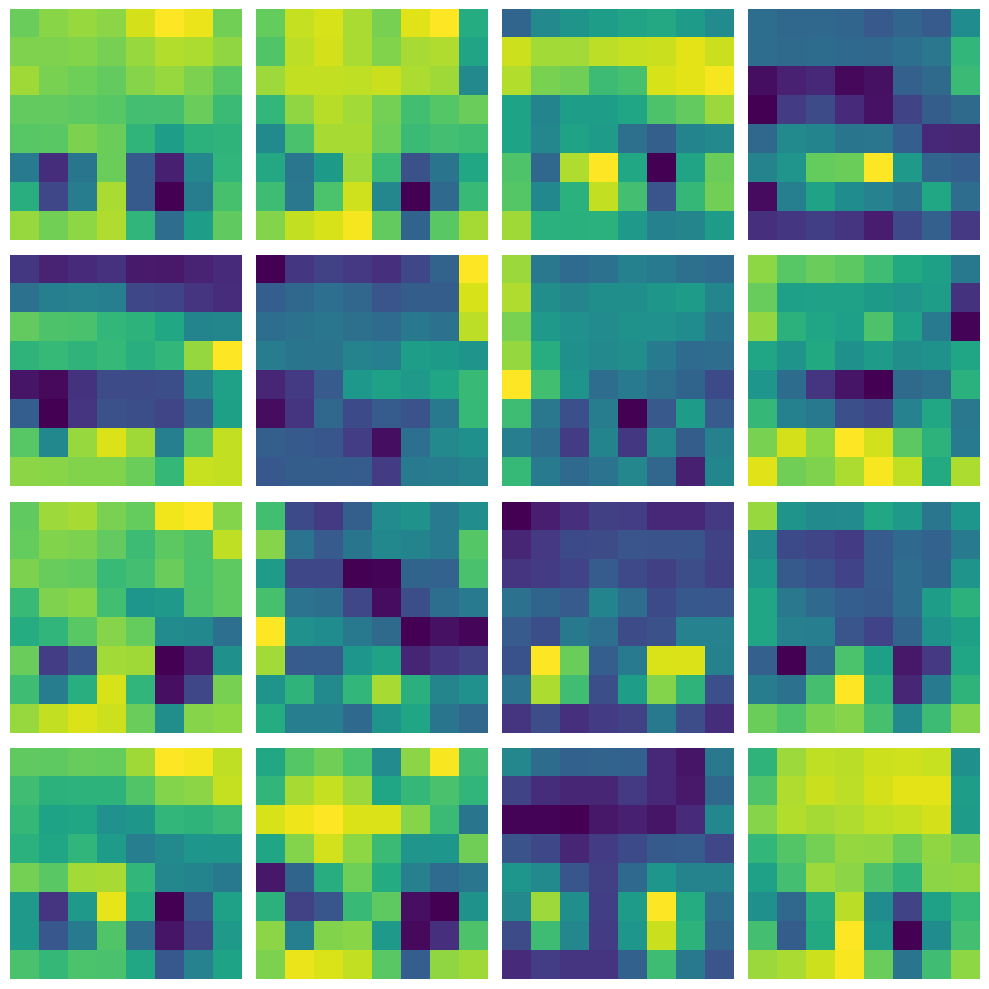

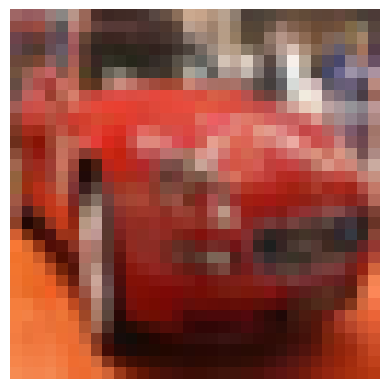

1/1 [==============================] - 0s 23ms/step
Layer 0 has only 3 feature maps.
Layer 1 has only 3 feature maps.


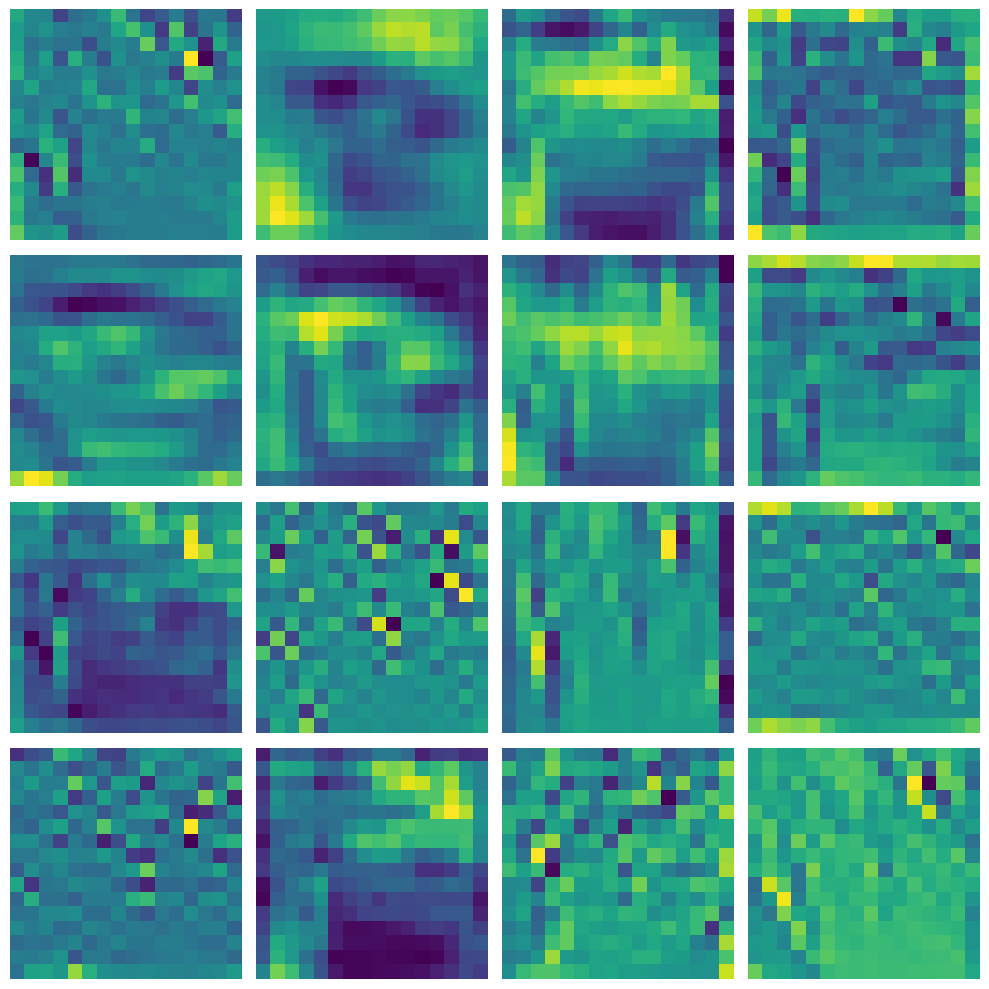

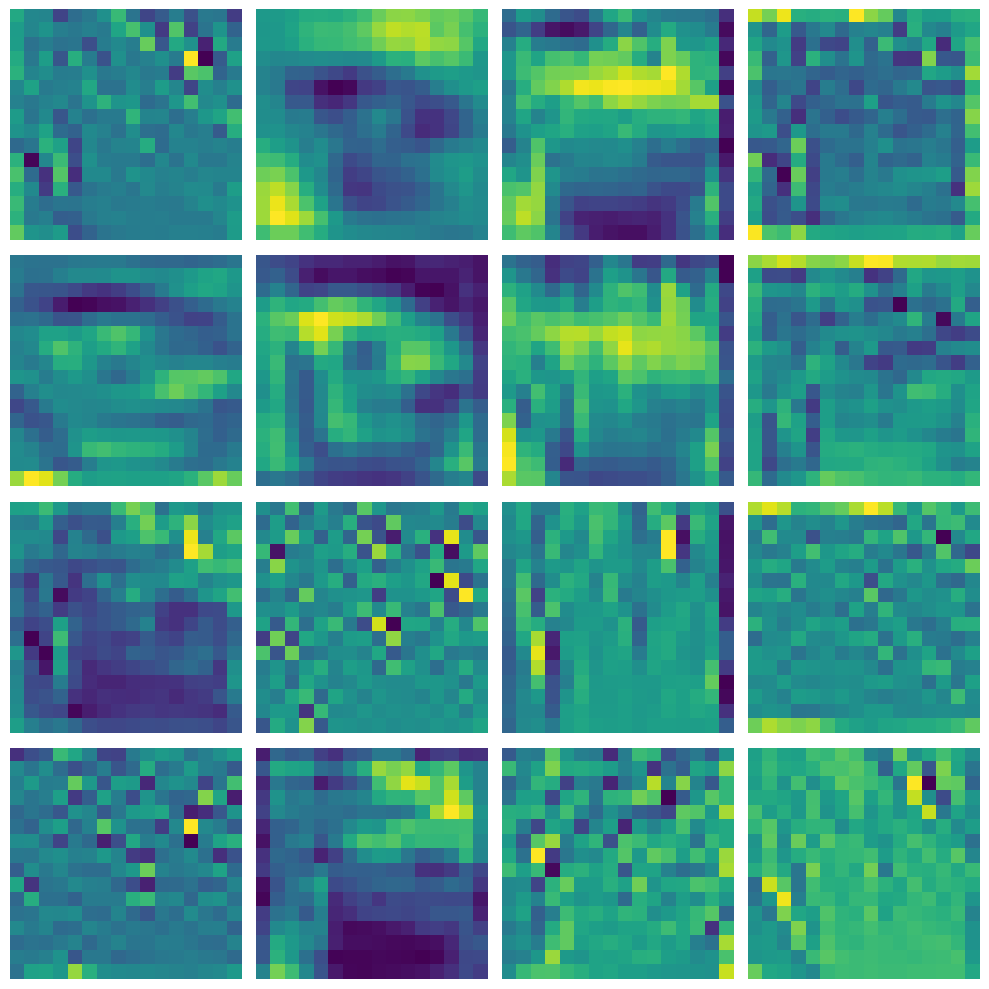

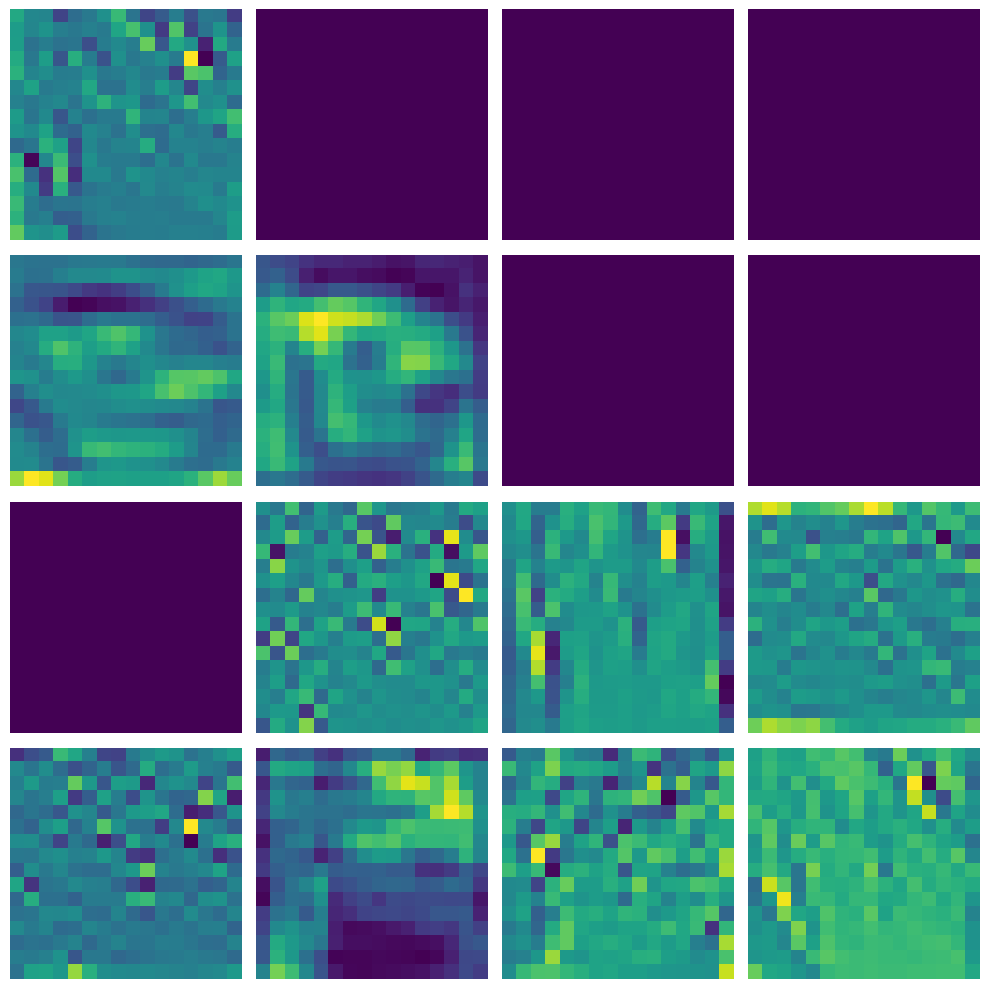

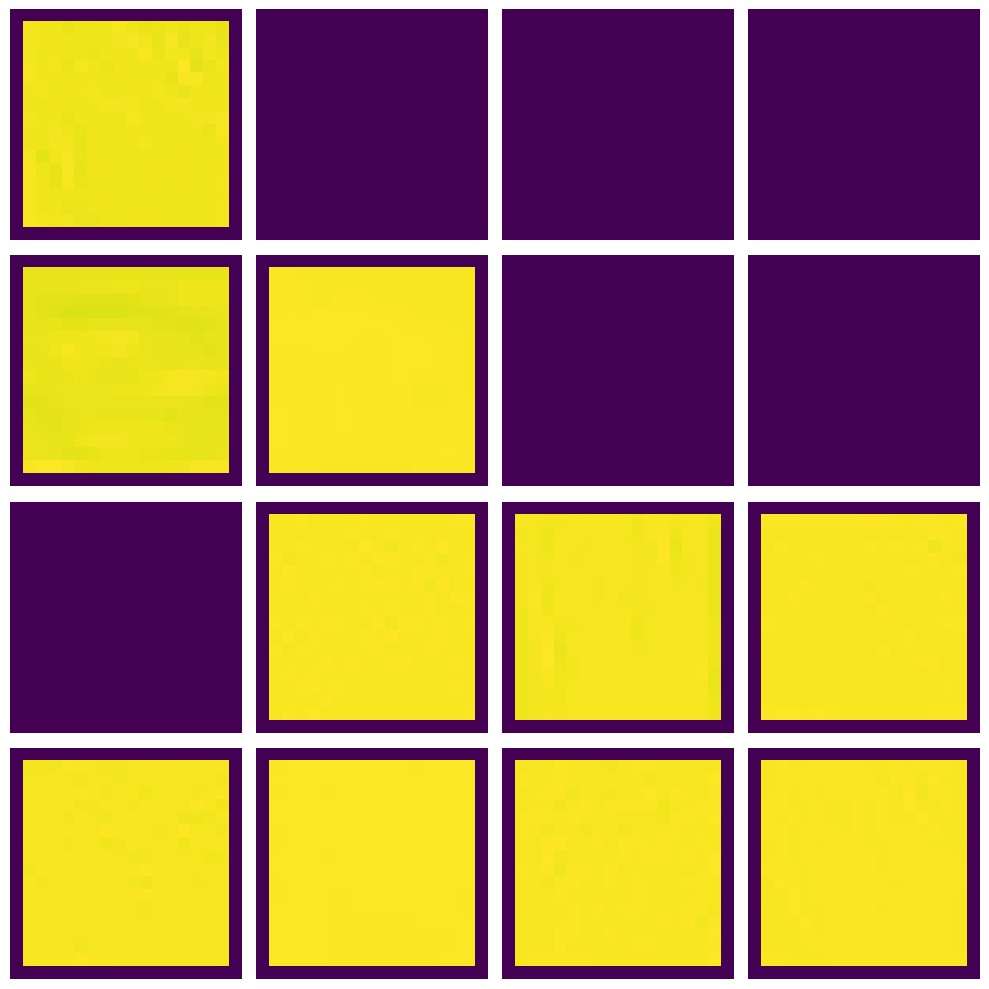

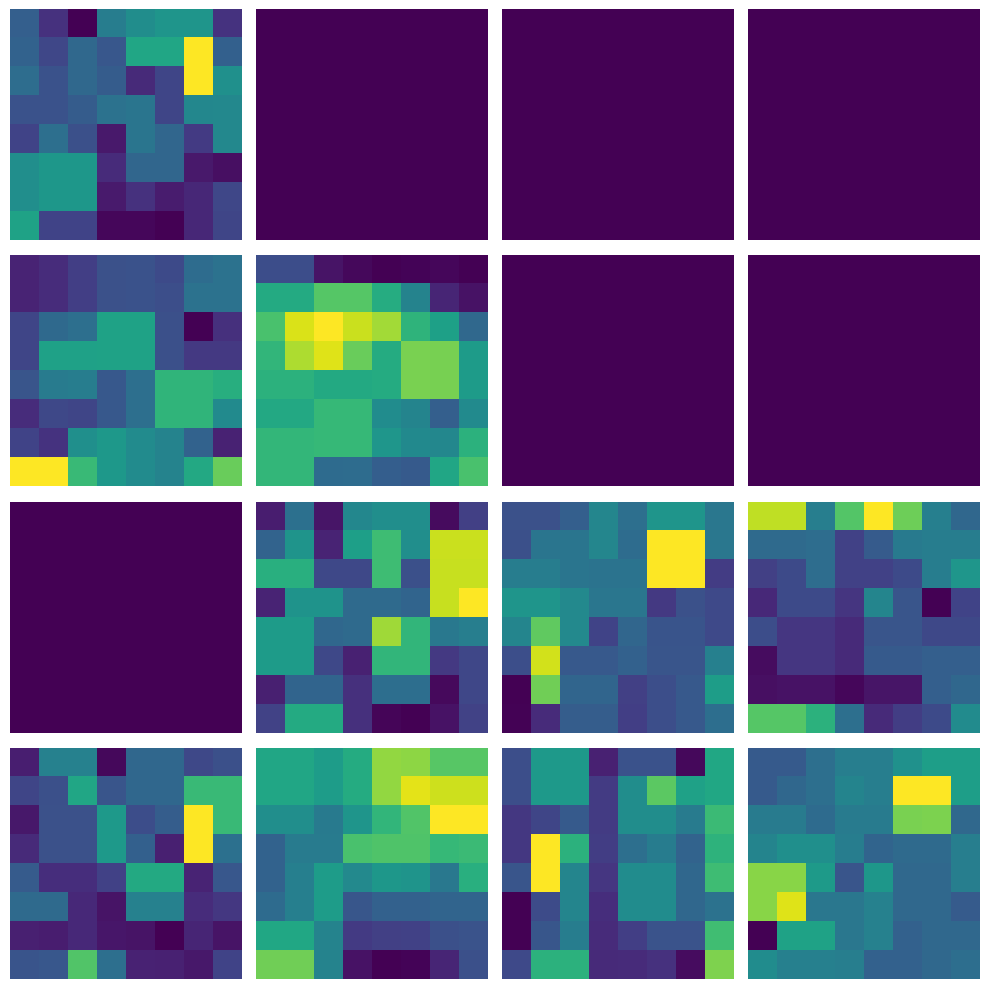

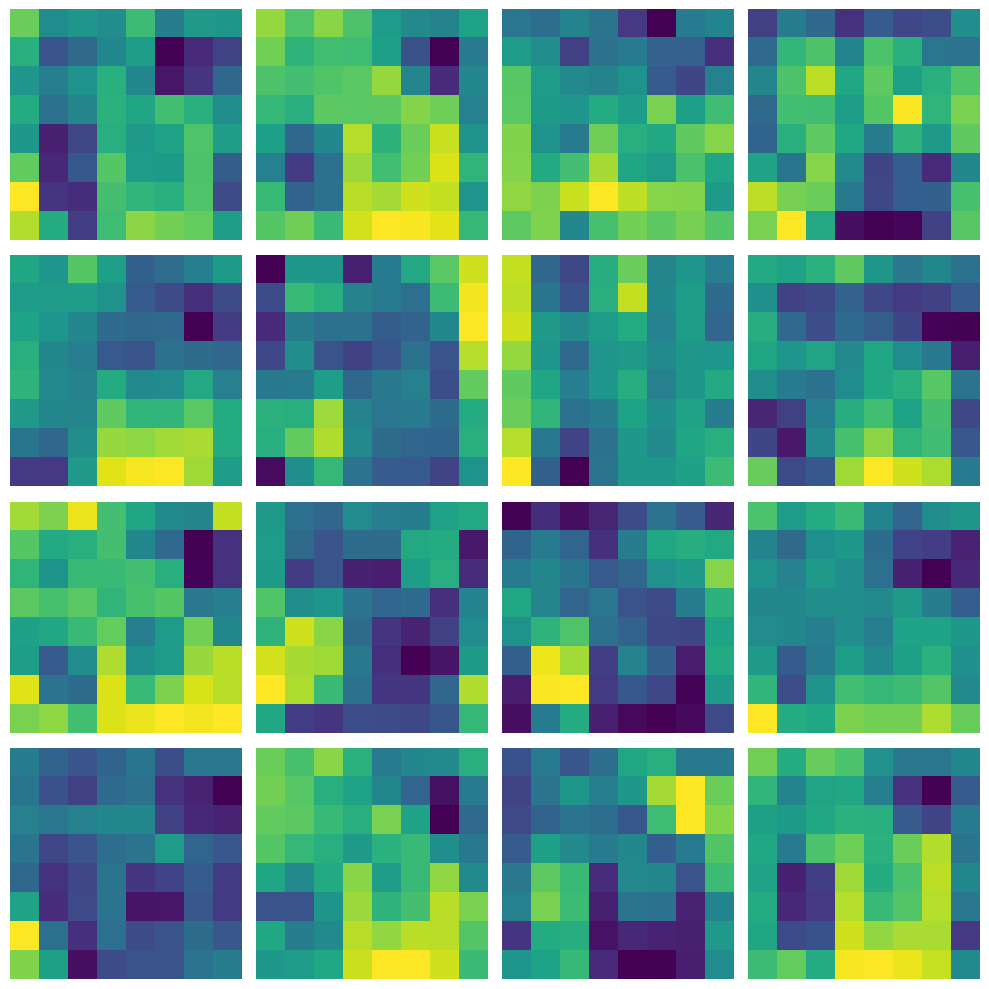

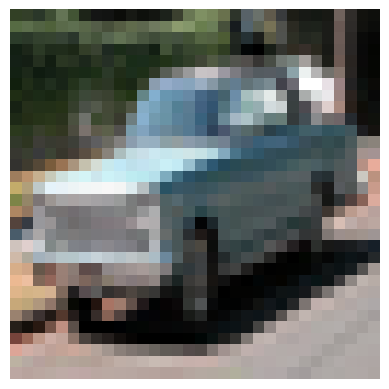

1/1 [==============================] - 0s 17ms/step
Layer 0 has only 3 feature maps.
Layer 1 has only 3 feature maps.


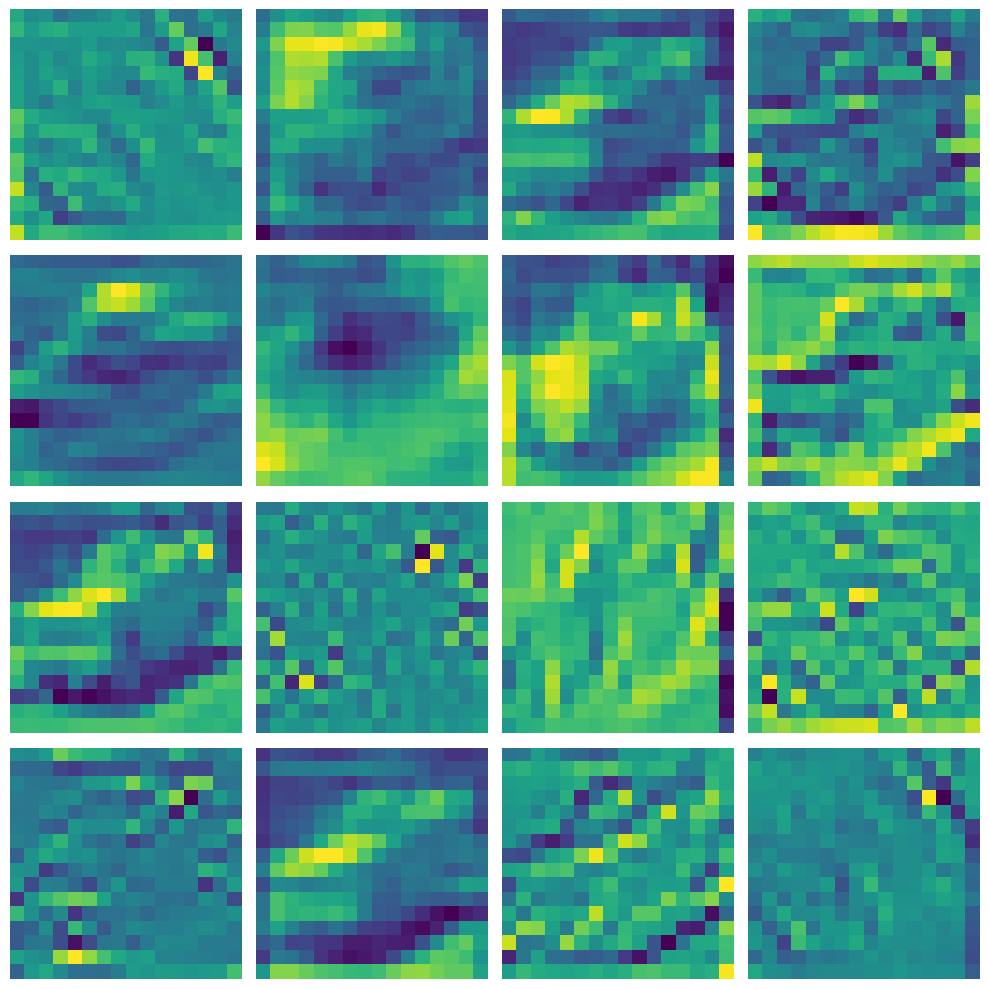

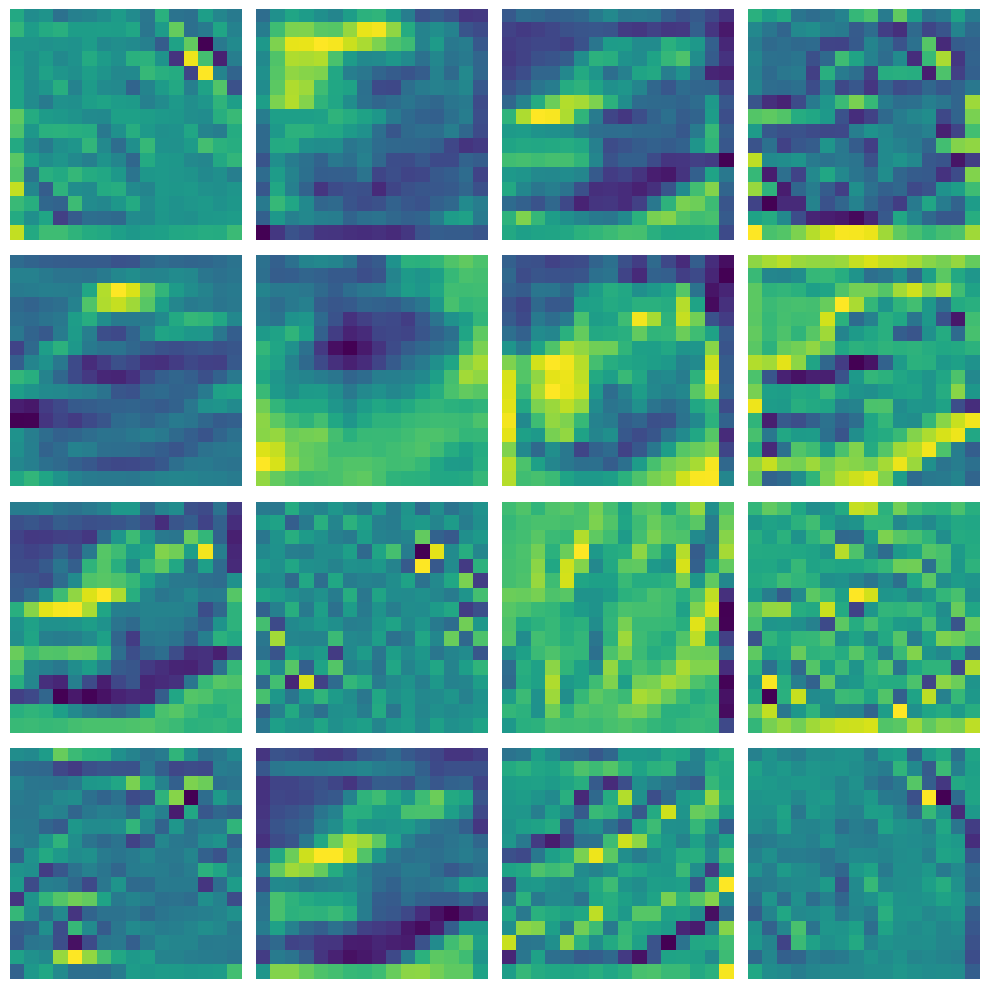

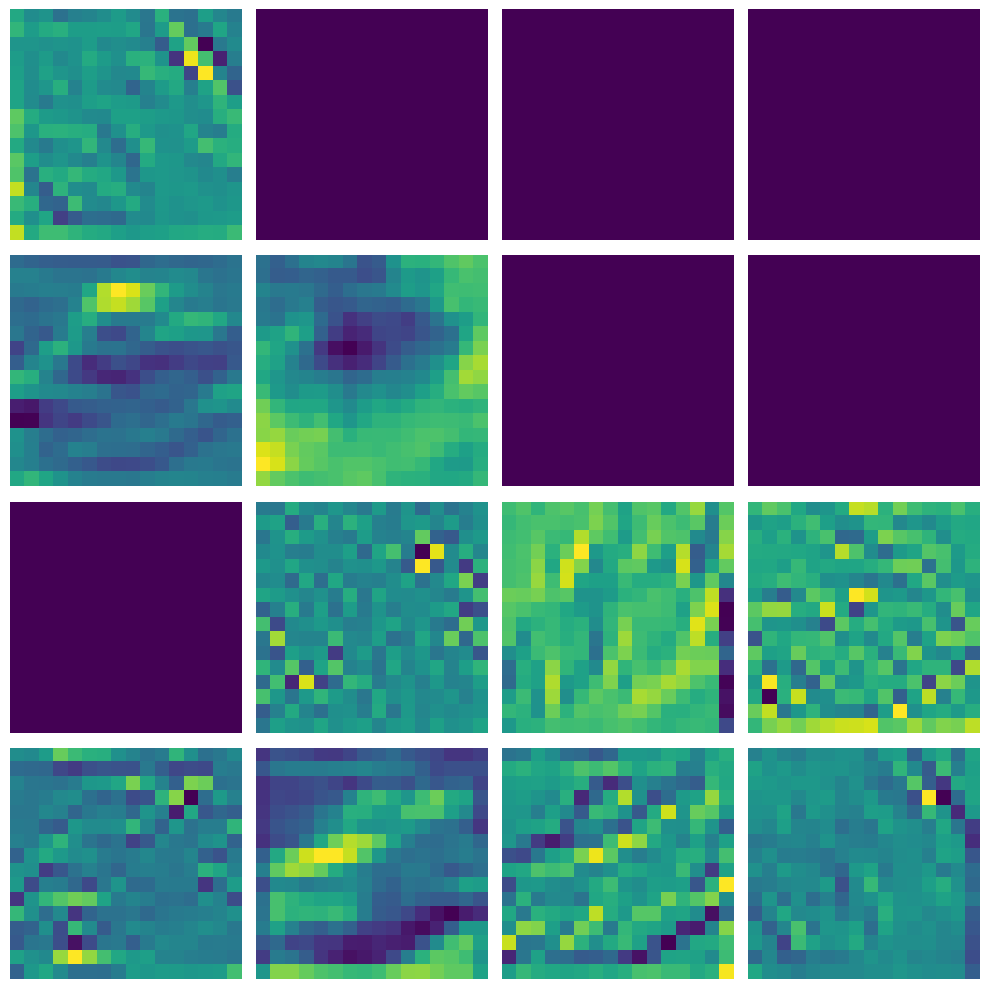

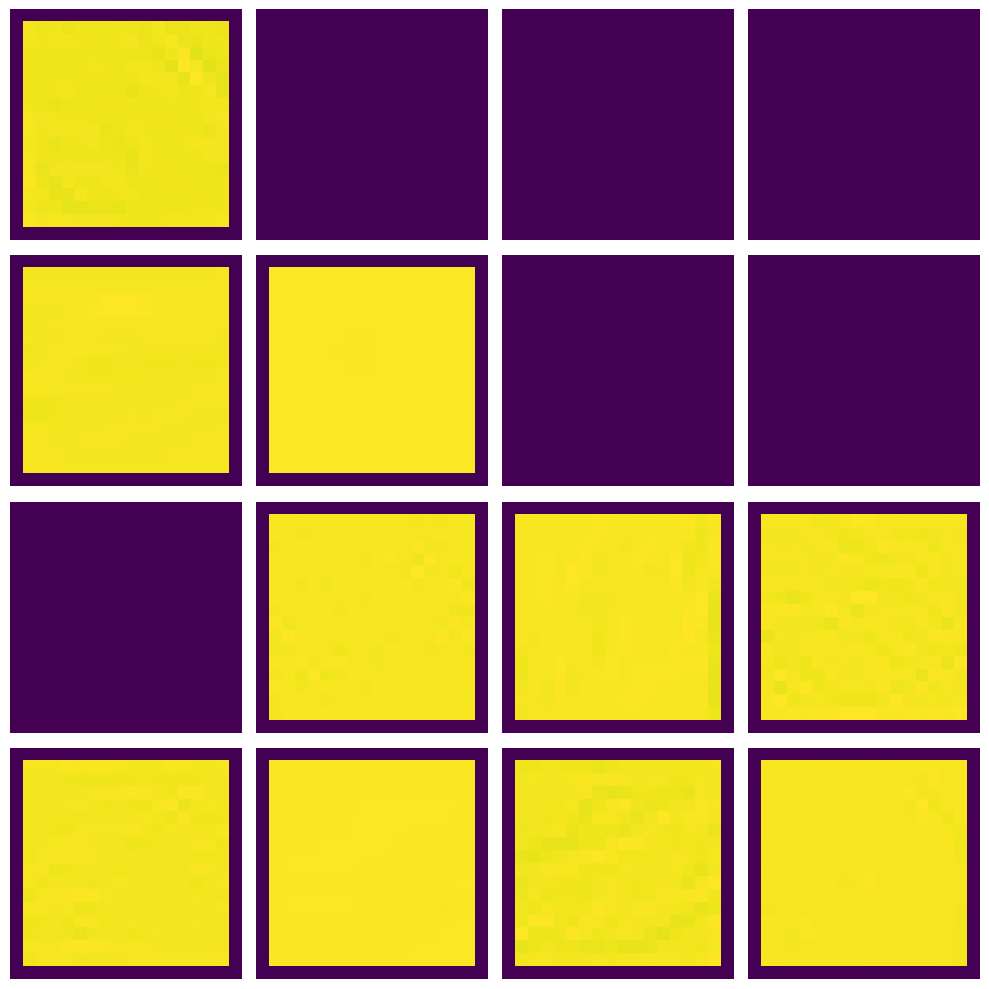

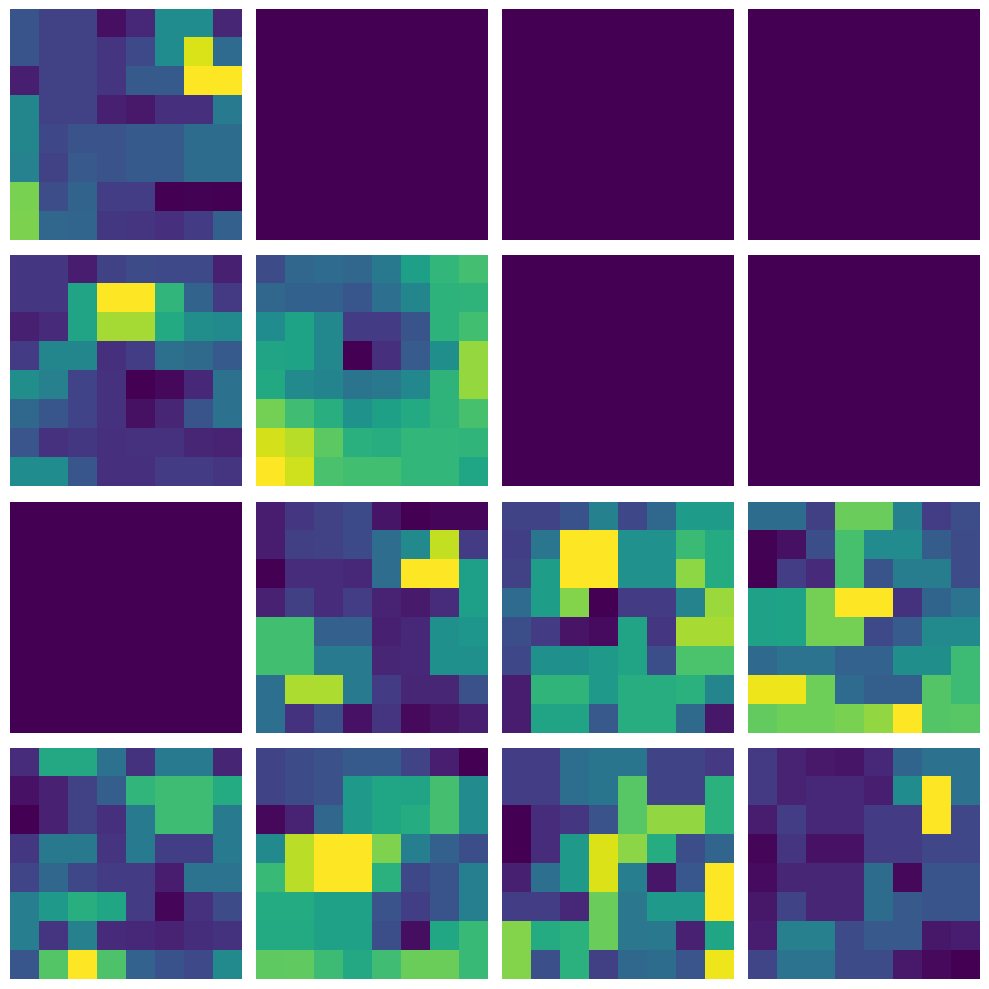

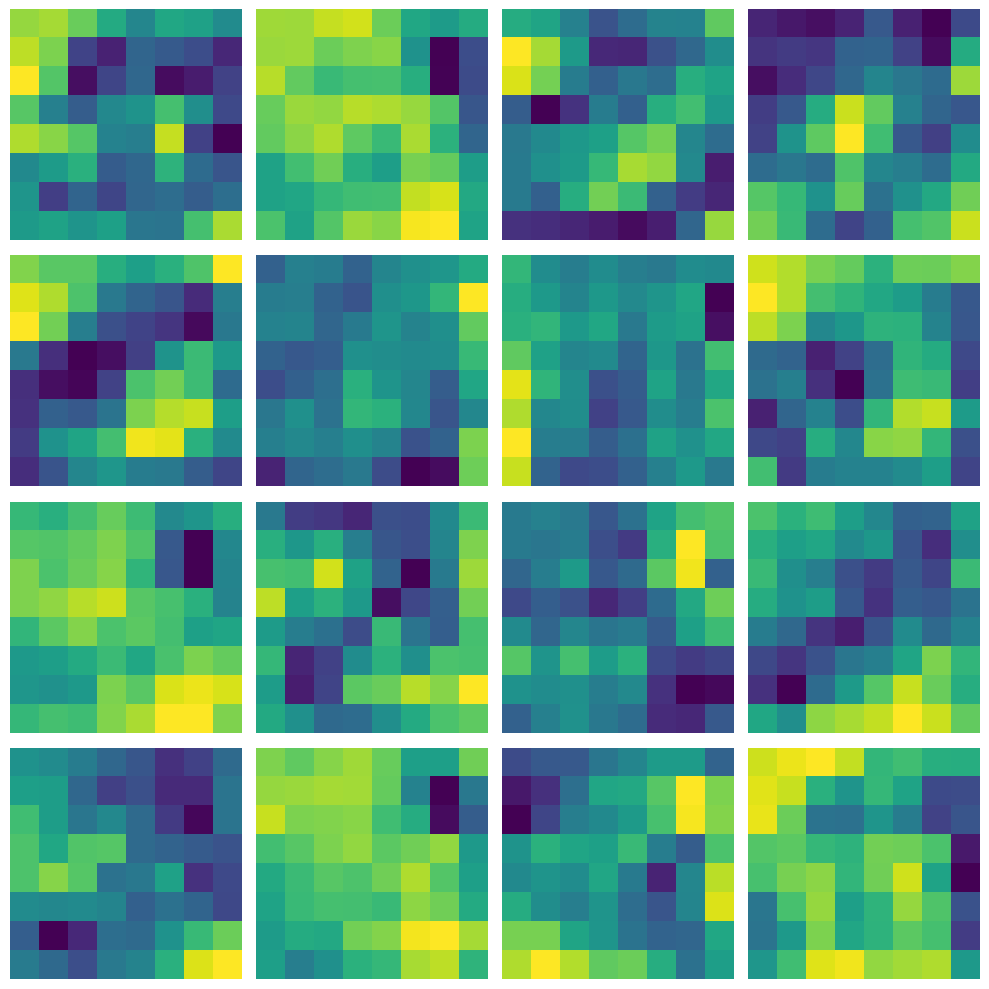

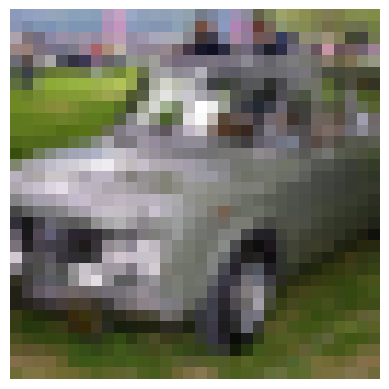

1/1 [==============================] - 0s 17ms/step
Layer 0 has only 3 feature maps.
Layer 1 has only 3 feature maps.


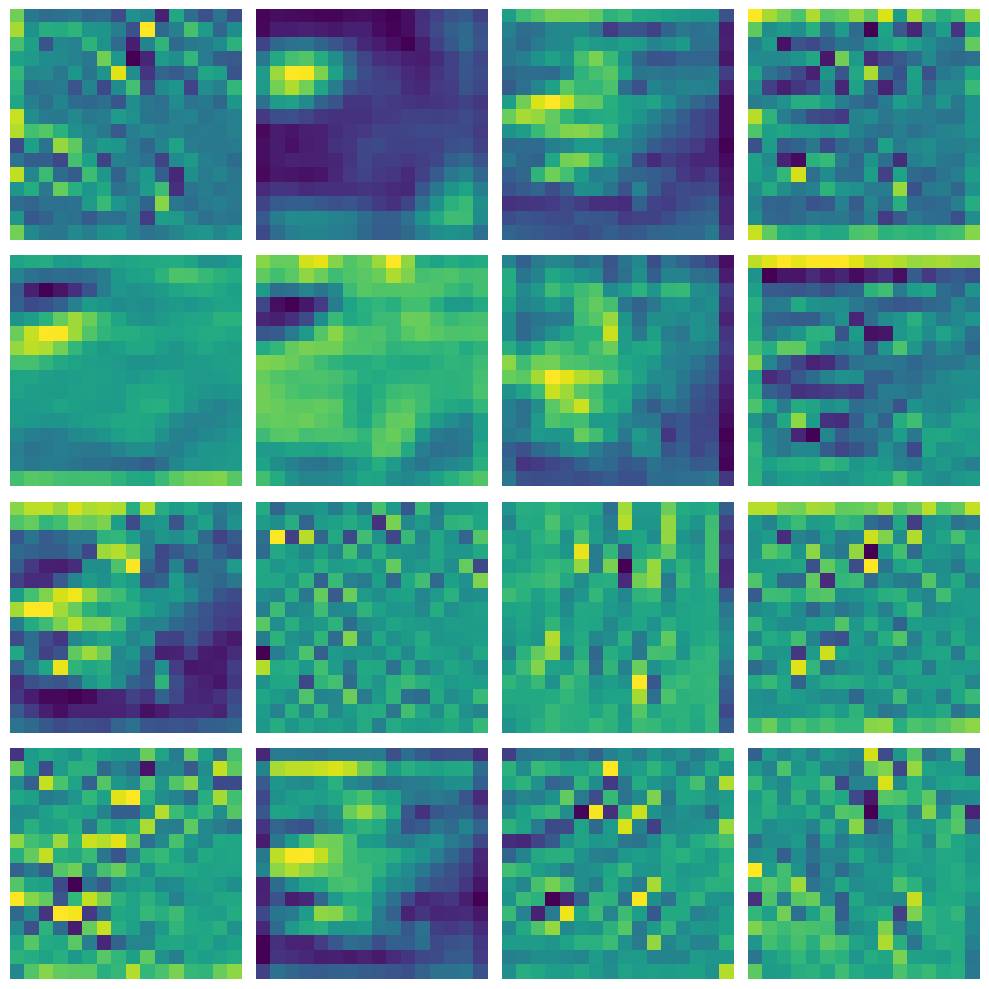

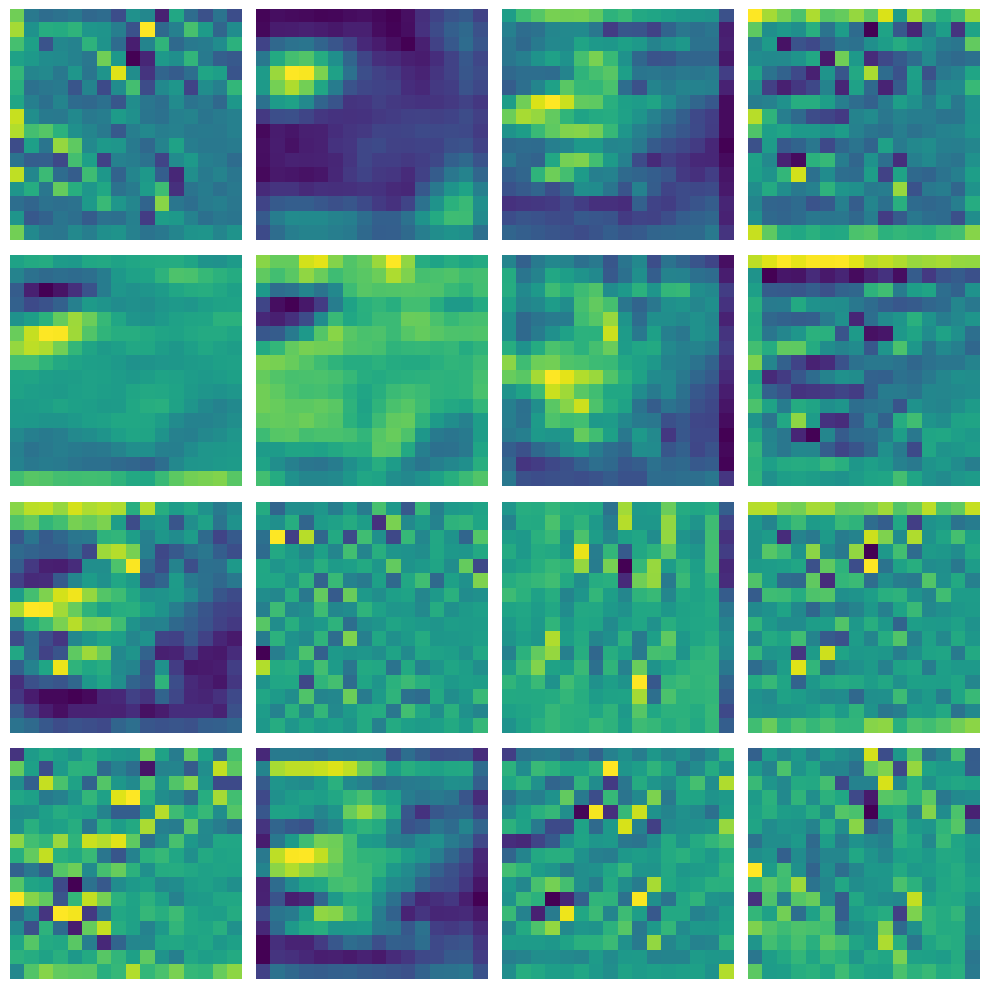

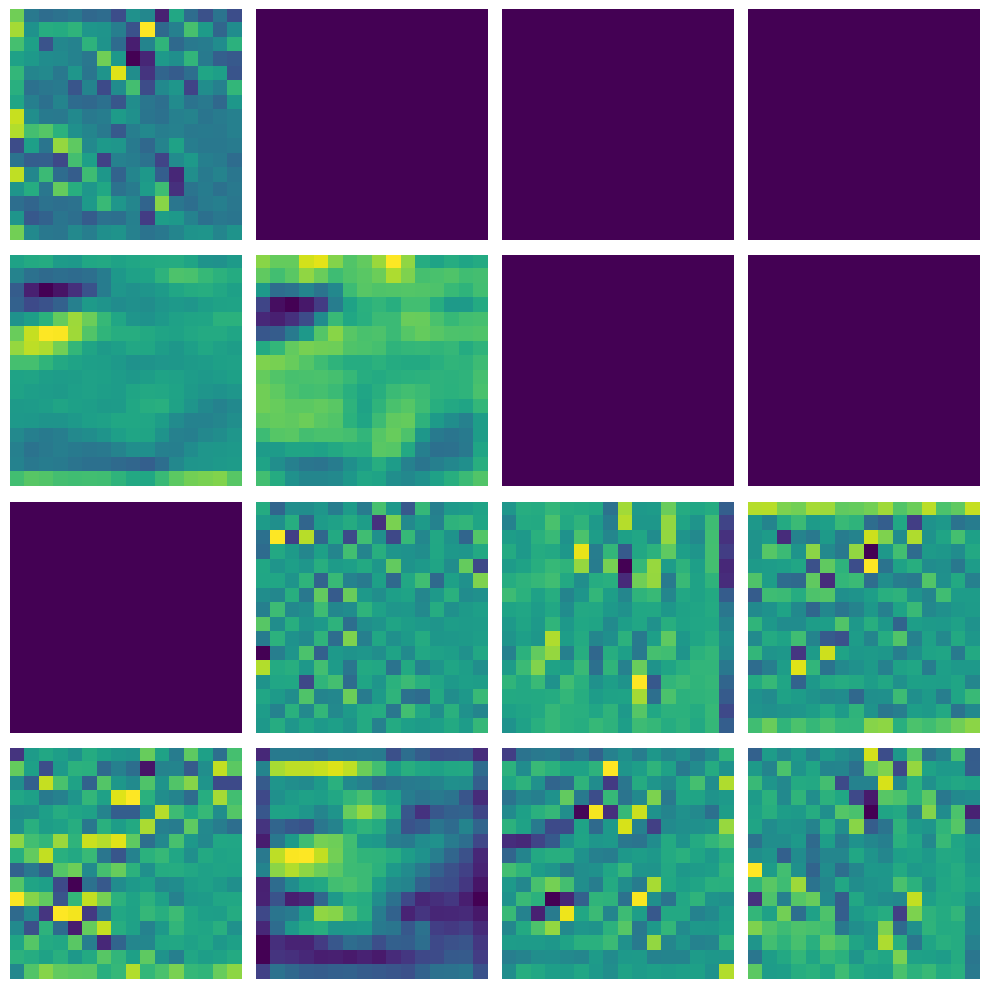

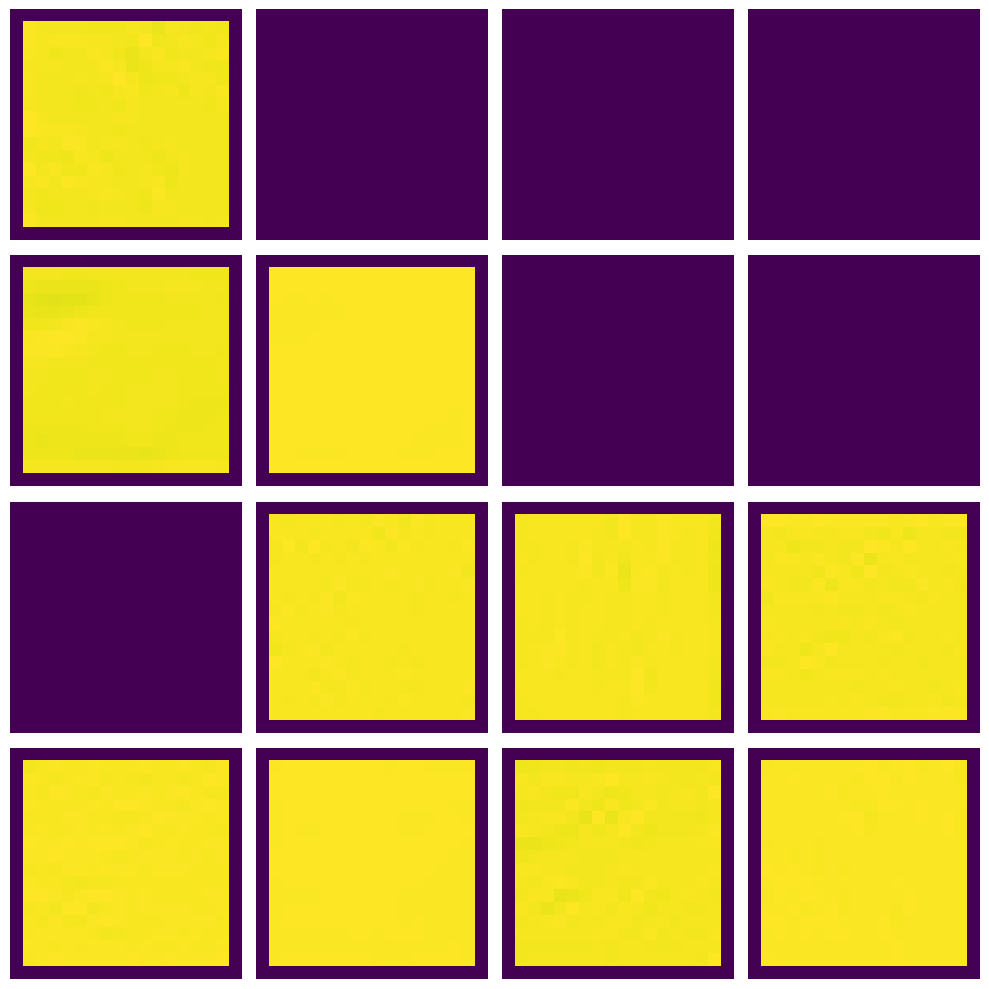

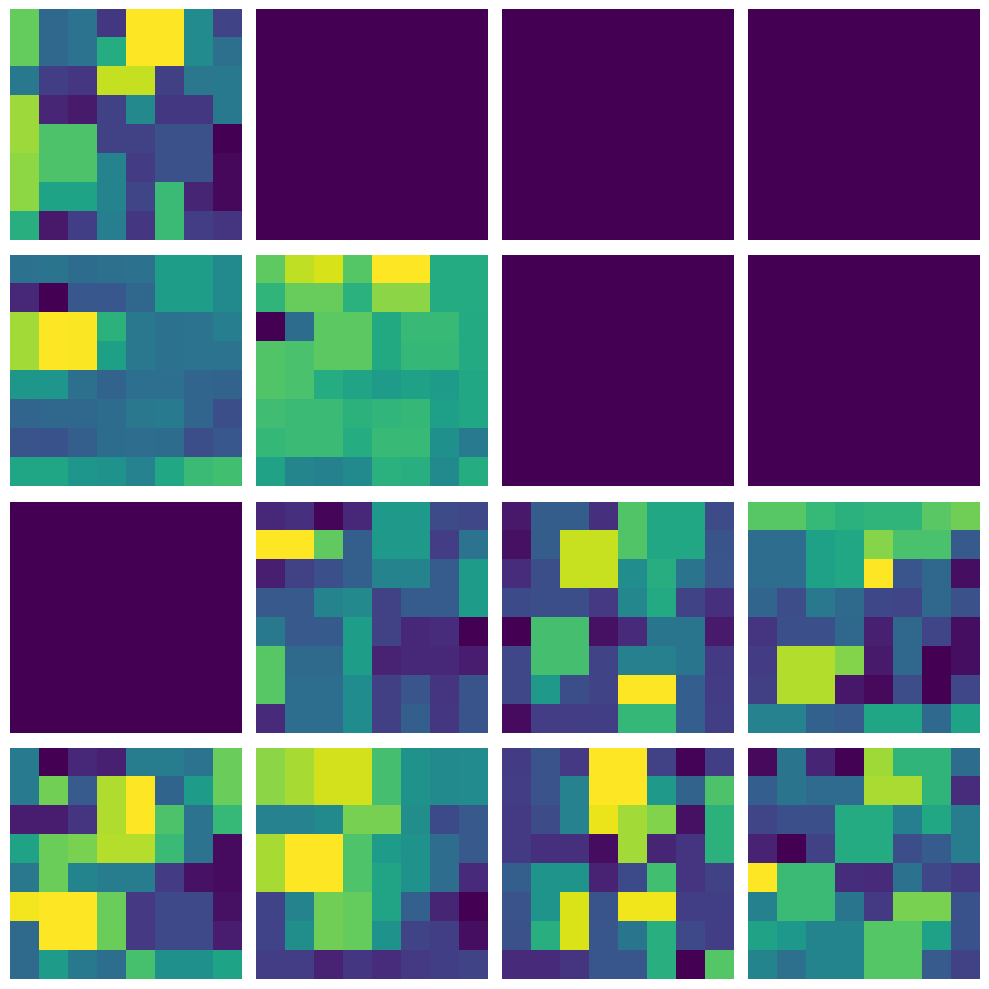

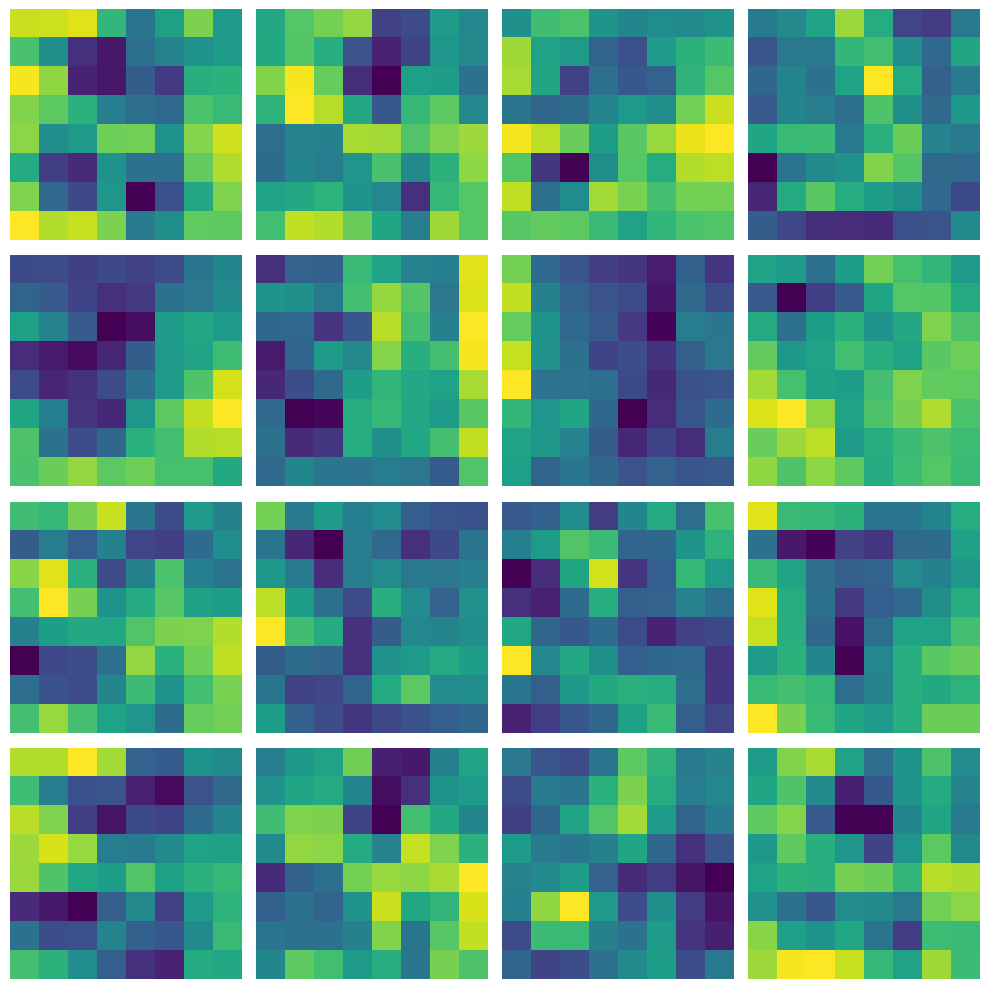

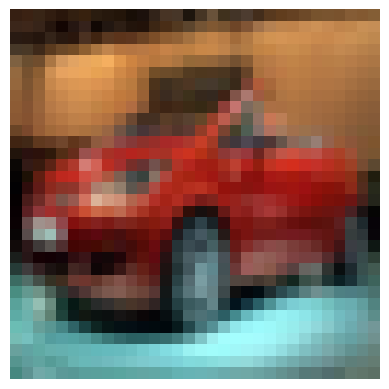

1/1 [==============================] - 0s 17ms/step
Layer 0 has only 3 feature maps.
Layer 1 has only 3 feature maps.


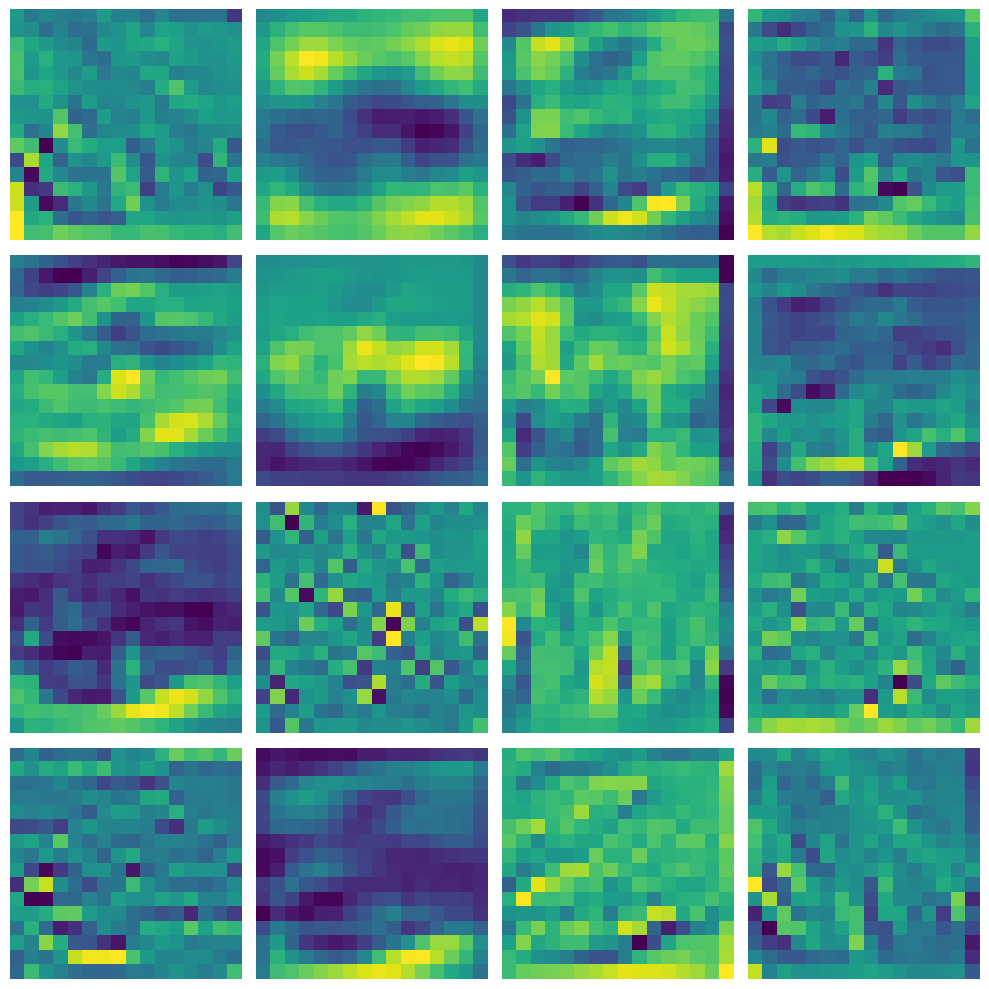

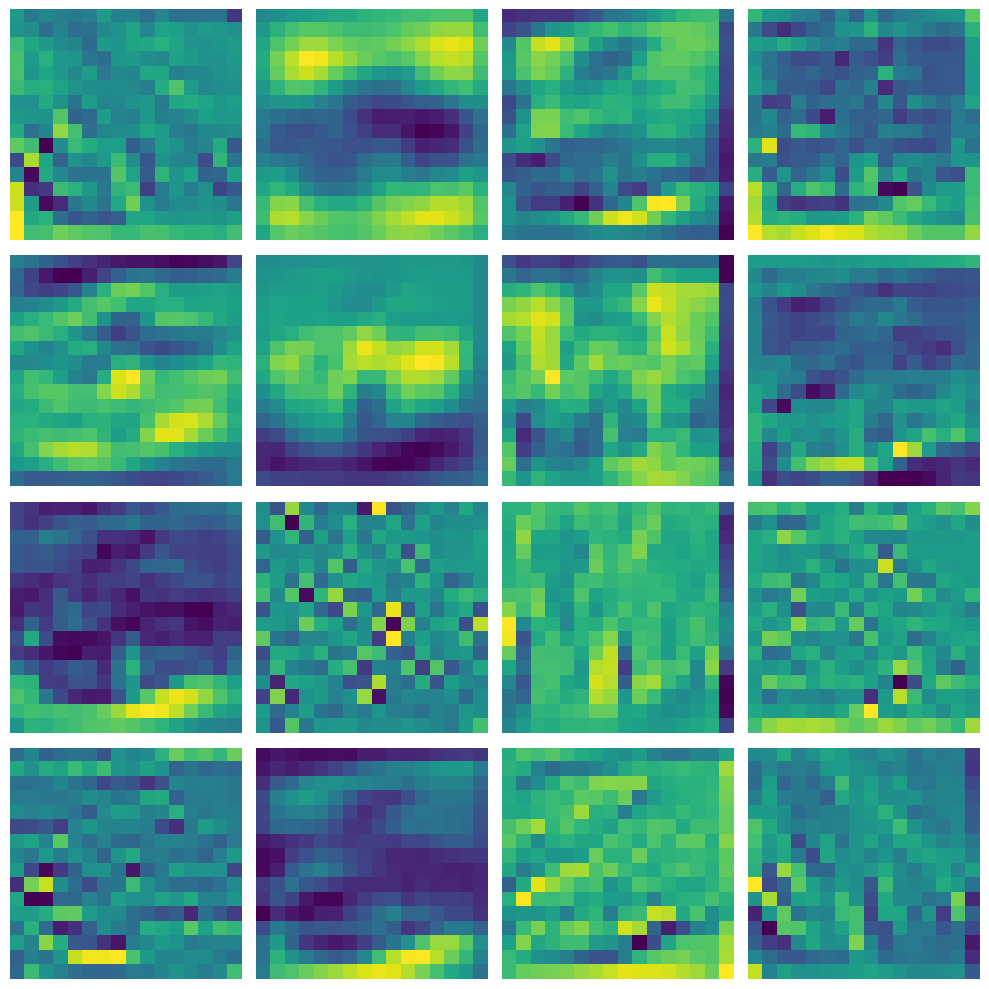

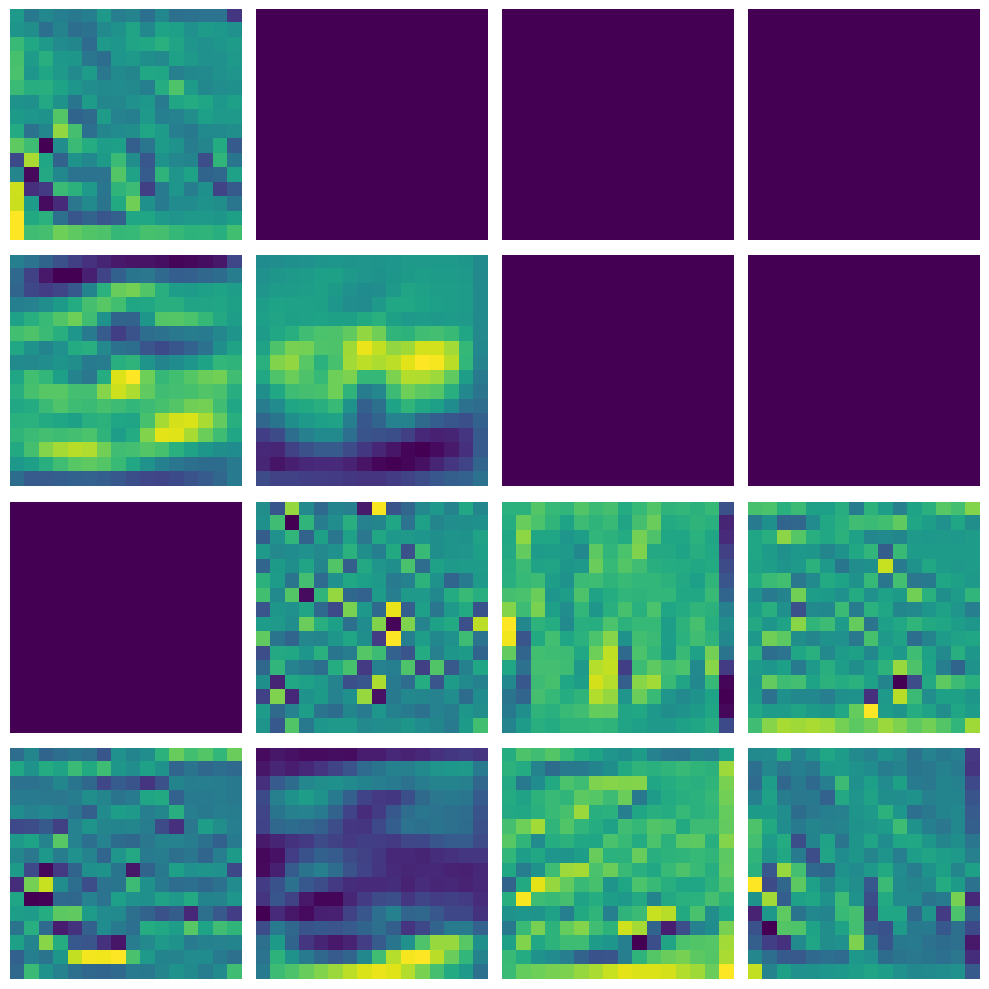

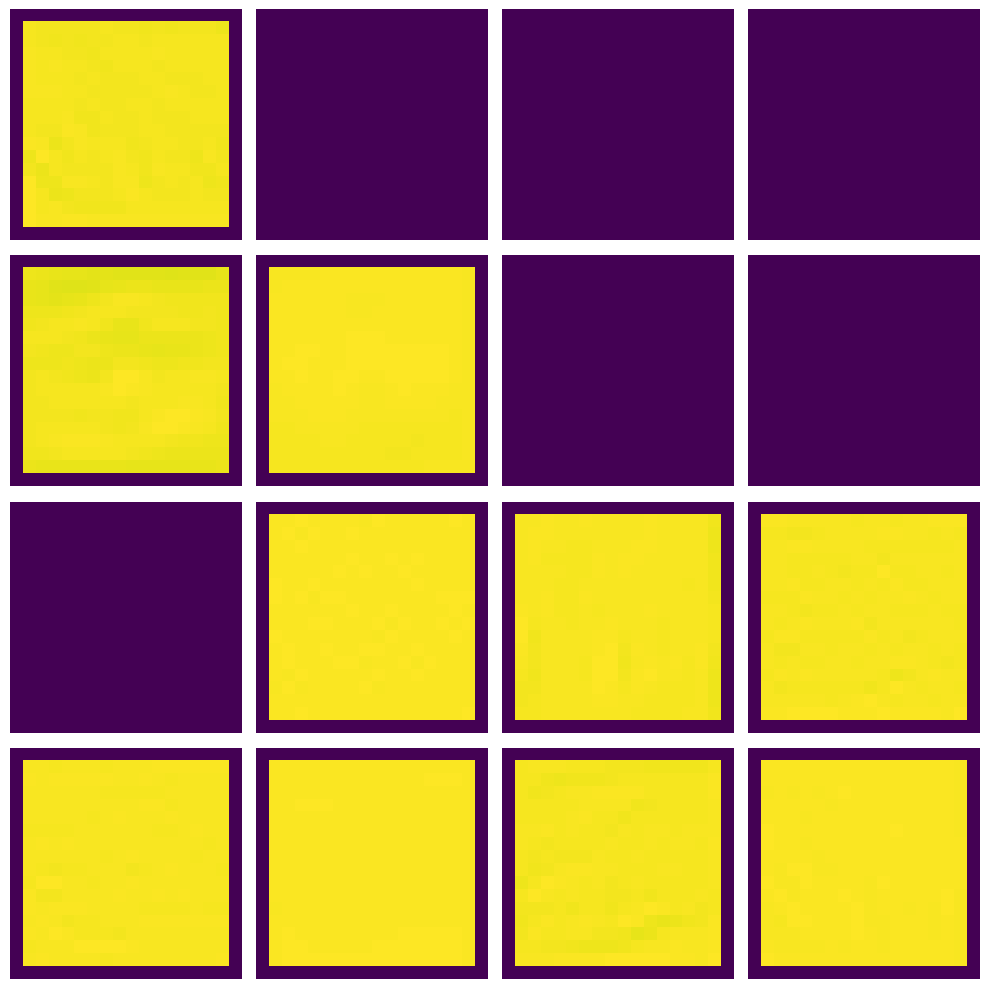

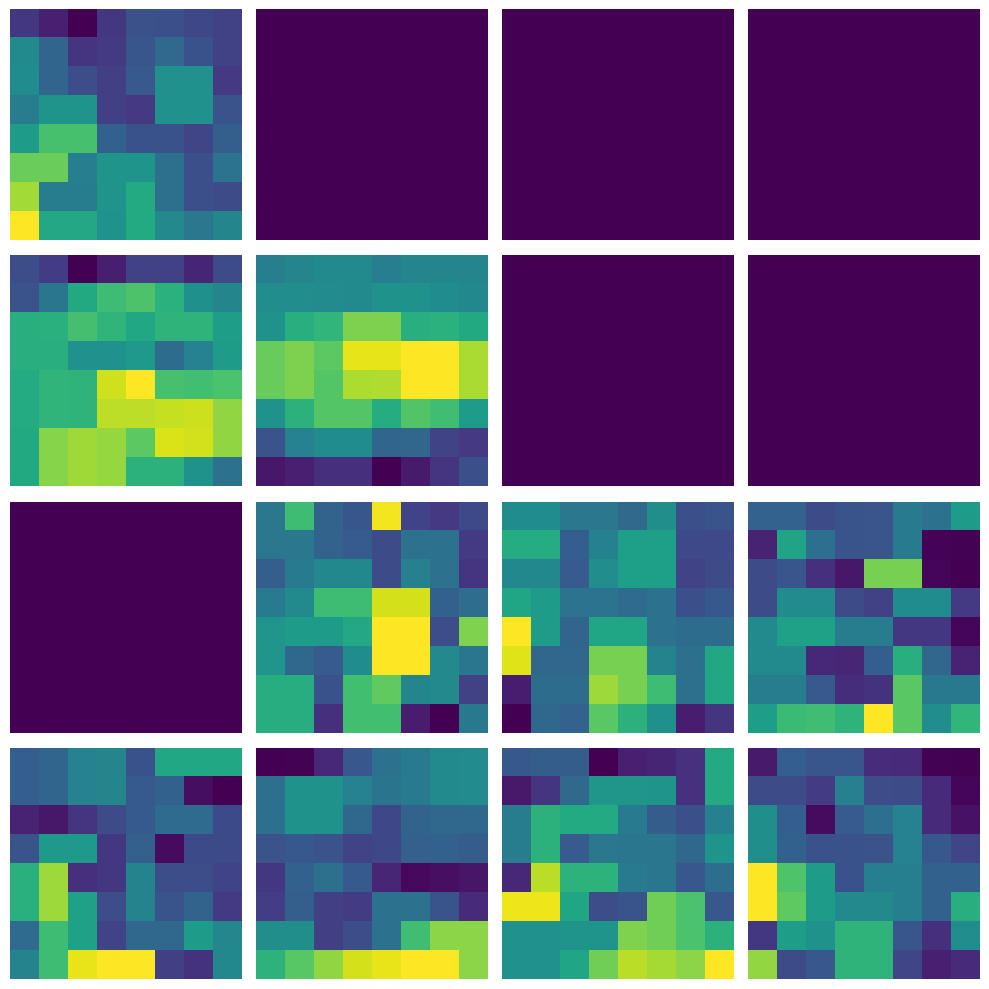

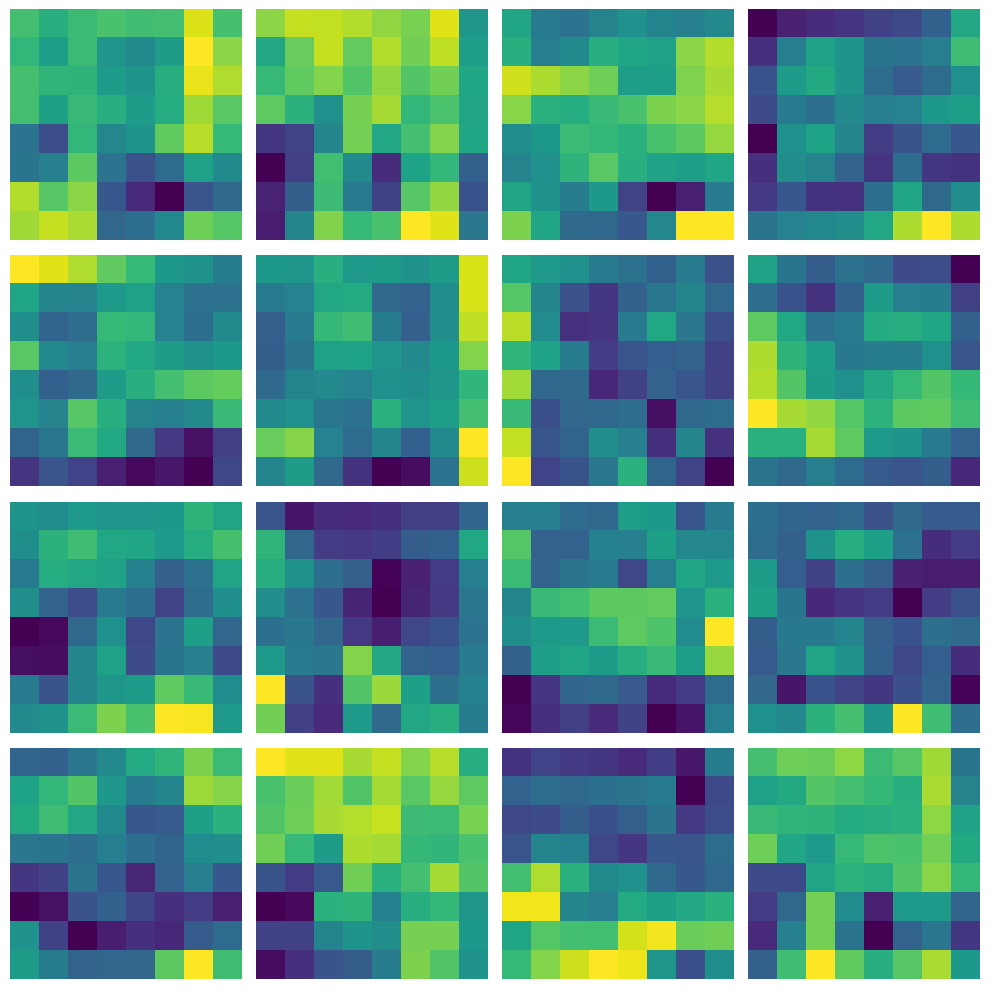

In [ ]:
# Retrieve the resnet50 submodel from the main model
resnet_submodel = model.get_layer("resnet50")

layer_outputs = [layer.output for layer in resnet_submodel.layers[:8]]
activation_model = Model(inputs=resnet_submodel.input, outputs=layer_outputs)

# Define a function to visualize activations for a given image
def visualize_activations_for_image(img):
    # Preprocess the image
    img = np.expand_dims(img, axis=0)

    # Retrieve the activations for the image
    activations = activation_model.predict(img)

    for layer_index in range(8):  # For each of the top 8 layers
        display_activation(activations, 4, 4, layer_index)

# Loop over a subset of images from class and visualize the activations
for img in class_images[:5]:
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    visualize_activations_for_image(img)

## Visualize the filters:

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

tf.compat.v1.enable_eager_execution()

# Retrieve the resnet50 submodel from the main model
resnet_submodel = model.get_layer("resnet50")

# Select the layer
layer_name = 'conv1_conv'
layer = resnet_submodel.get_layer(layer_name)

# Get the weights
weights = layer.weights[0].numpy()

In [ ]:
def normalize(weights):
    # Normalize to [0, 1]
    weights_min = np.min(weights)
    weights_max = np.max(weights)
    weights = (weights - weights_min) / (weights_max - weights_min)

    # Then scale to [0, 255]
    weights = (weights * 255).astype(np.uint8)

    return weights

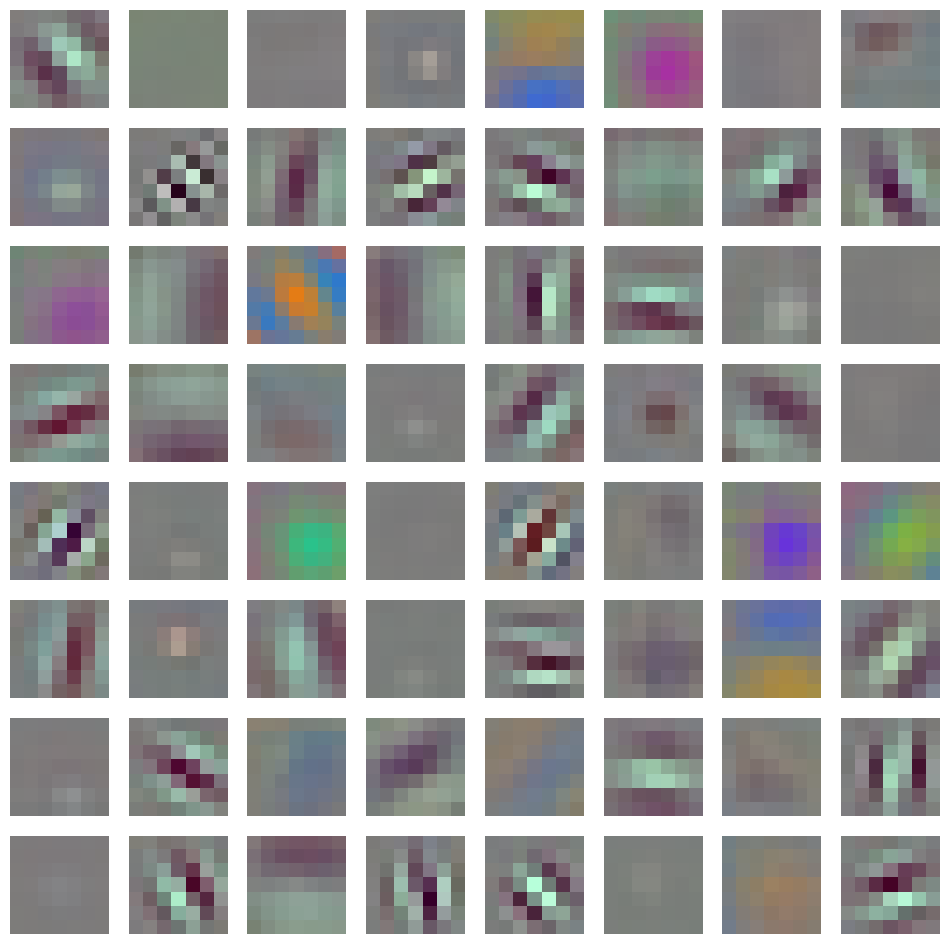

In [ ]:
import matplotlib.pyplot as plt

def visualize_filters(normalized_weights):
    # Number of filters
    num_filters = normalized_weights.shape[-1]

    # Create a grid of subplots
    rows = int(np.sqrt(num_filters))
    cols = num_filters // rows

    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))

    for i in range(rows):
        for j in range(cols):
            ax = axes[i, j]
            filter_index = i * cols + j
            if filter_index < num_filters:
                ax.imshow(normalized_weights[:, :, :, filter_index])
                ax.axis('off')
            else:
                ax.remove()

    plt.show()

weights = normalize(weights)
visualize_filters(weights)

## Visualizing heatmaps

In [194]:
from tensorflow.keras import backend as K

K.clear_session()

resnet_submodel = model.get_layer("resnet50")

In [195]:
def generate_heatmap(model, last_conv_layer_name, image):
    # Model for getting the gradients and features
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_output_values, predictions = grad_model(image)
        class_channel = predictions[:, 0]

    # Get the gradients of the output with respect to the features
    grads = tape.gradient(class_channel, conv_output_values)

    # Mean pooling of the gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply features with pooled gradients
    heatmap = tf.multiply(pooled_grads, conv_output_values)
    heatmap = tf.reduce_mean(heatmap, axis=-1)

    # Normalize the heatmap between 0 & 1 for visualization
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap[0]

1/1 [==============================] - 0s 76ms/step


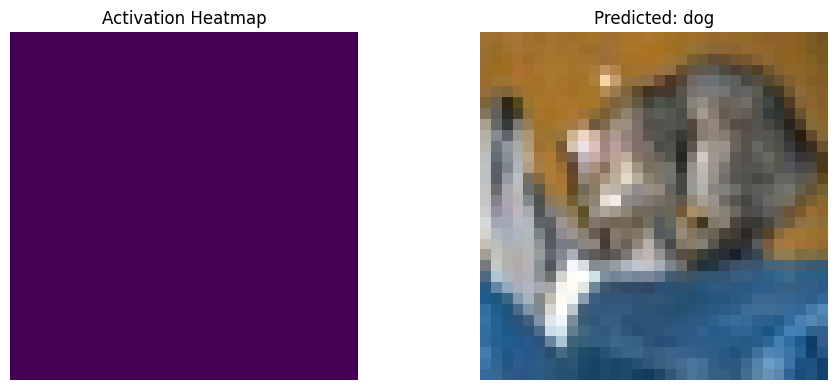

1/1 [==============================] - 0s 23ms/step


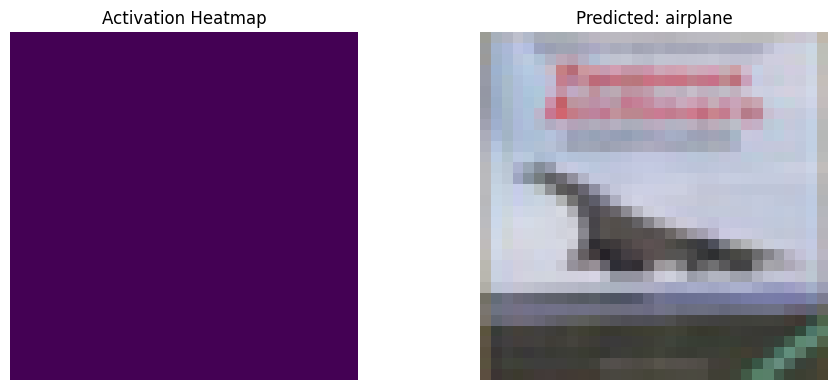

1/1 [==============================] - 0s 28ms/step


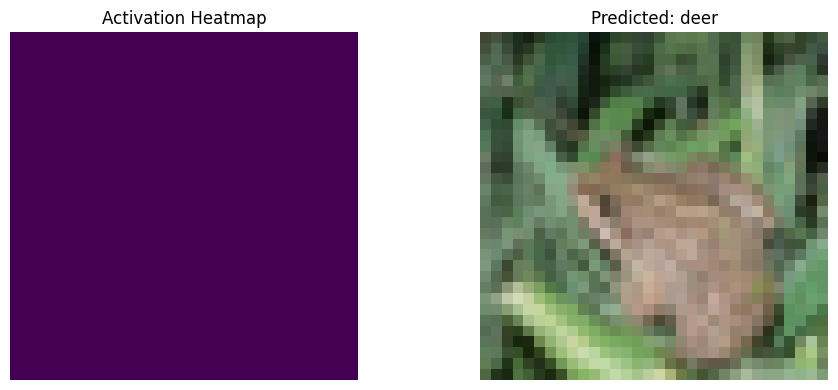

1/1 [==============================] - 0s 22ms/step


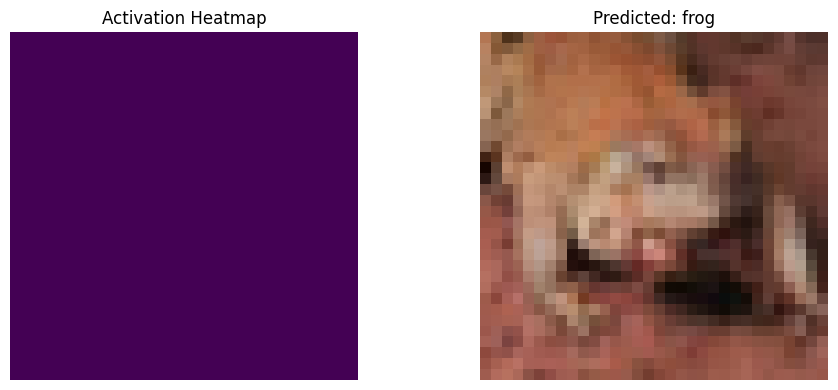

1/1 [==============================] - 0s 26ms/step


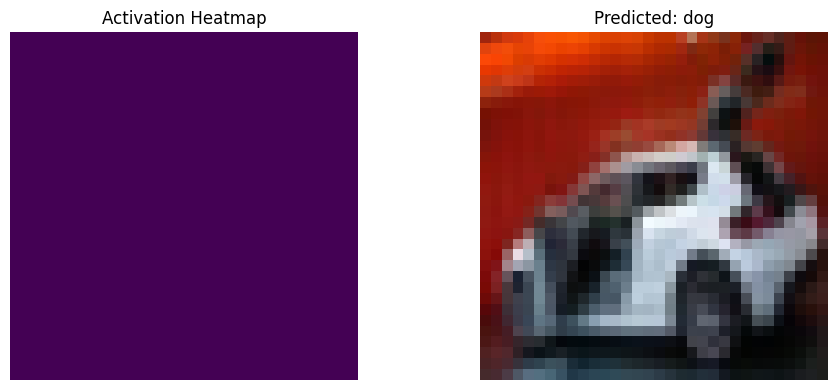

1/1 [==============================] - 0s 35ms/step


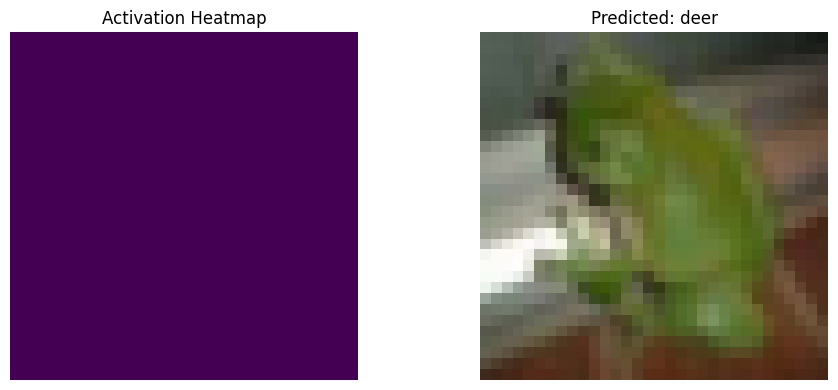

1/1 [==============================] - 0s 26ms/step


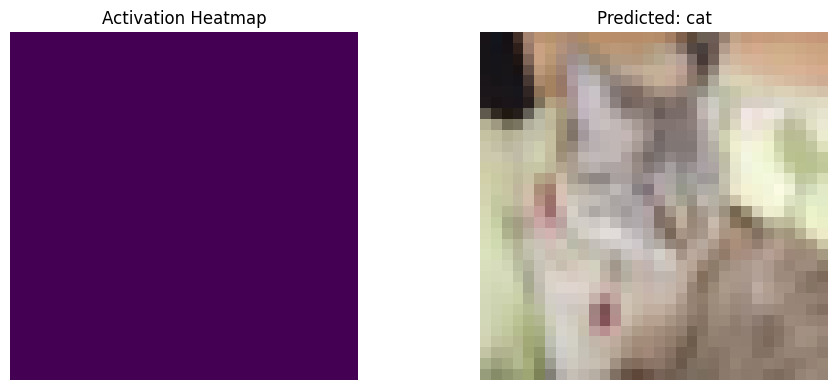

1/1 [==============================] - 0s 26ms/step


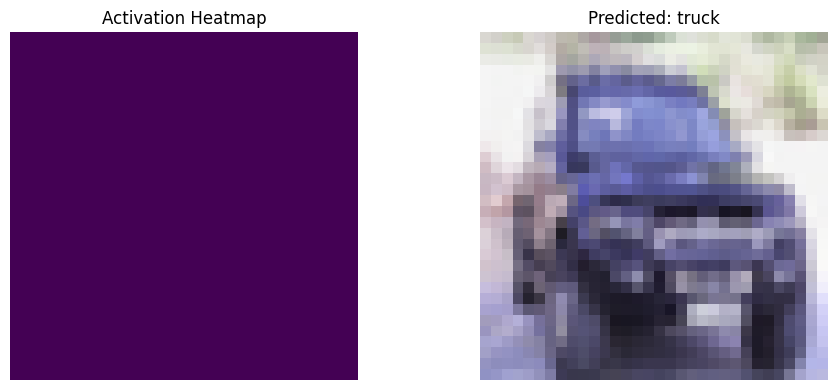

1/1 [==============================] - 0s 27ms/step


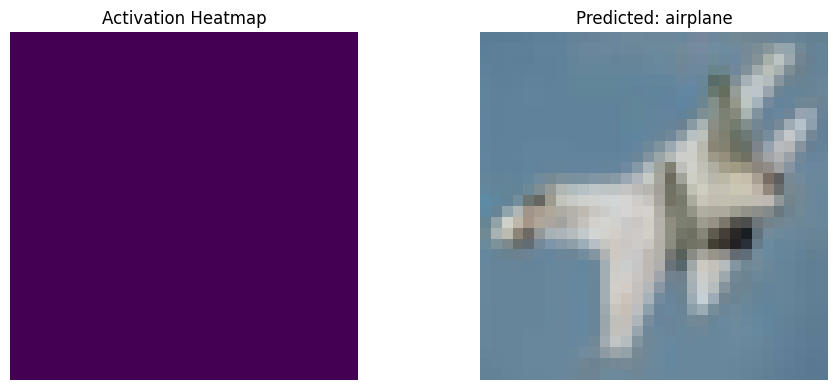

1/1 [==============================] - 0s 23ms/step


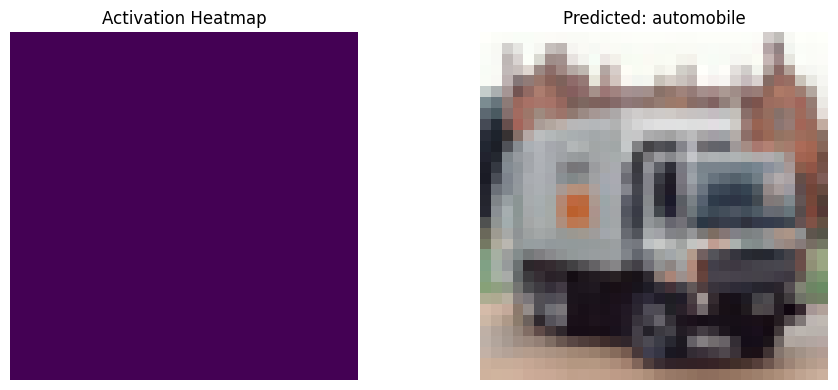

In [199]:
last_conv_layer_name = "conv5_block3_out"

def custom_decode(predictions):
    class_idx = np.argmax(predictions[0])
    return label_names[class_idx]

# Display heatmap for the first 10 images
for i in range(10):
    img = test_data[i]
    img_array = np.expand_dims(img, axis=0)
    heatmap = generate_heatmap(resnet_submodel, last_conv_layer_name, img_array)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.imshow(heatmap)
    plt.title("Activation Heatmap")
    plt.axis("off")

    prediction = model.predict(img_array)
    label = custom_decode(prediction)

    # Plot the image with the prediction
    plt.subplot(1, 2, 2)
    plt.imshow(test_data[i])
    plt.title(f"Predicted: {label}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()


# PS 1.B - 20 points

In [this notebook](https://pantelis.github.io/artificial-intelligence/aiml-common/lectures/transfer-learning/transfer_learning_tutorial.html) we showcase _transfer learning_ using a pre-trained CNN model.

Perform the fine-tunning and feature extraction methods of transfer learning using the same model as in PS-1A, for the class `ship`.

Repeat the visualization of PS-1.A before and after  transfer learning and write a conclusive summary as to the relative value of the two methods.

## Fintuning the Binary Model

### Load Data and Process

In [ ]:
from tensorflow.keras.models import load_model
import pickle
import numpy as np
import matplotlib.pyplot as plt

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Load training data
train_data = None
train_labels = []

for i in range(1, 6):
    batch_name = f"data_batch_{i}"
    batch_data = unpickle(batch_name)
    if i == 1:
        train_data = batch_data[b'data']
    else:
        train_data = np.vstack((train_data, batch_data[b'data']))
    train_labels.extend(batch_data[b'labels'])

train_data = np.array(train_data)
train_labels = np.array(train_labels)

# Load test data
test_data_dict = unpickle("test_batch")
test_data = np.array(test_data_dict[b'data'])
test_labels = np.array(test_data_dict[b'labels'])

# Load label names
label_names = unpickle("batches.meta")[b'label_names']
label_names = [name.decode('utf-8') for name in label_names]

# Convert labels to binary: 1 for ship and 0 for others
binary_train_labels = np.where(train_labels == 8, 1, 0)
binary_test_labels = np.where(test_labels == 8, 1, 0)

# Reshape the data
train_data = train_data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
test_data = test_data.reshape(-1 ,3, 32, 32).transpose(0, 2, 3, 1)

# Normalize the data
train_data = train_data / 255.0
test_data = test_data / 255.0


base_model = load_model('resnet50_cifar10_modified.h5')

### Print Data and Labels

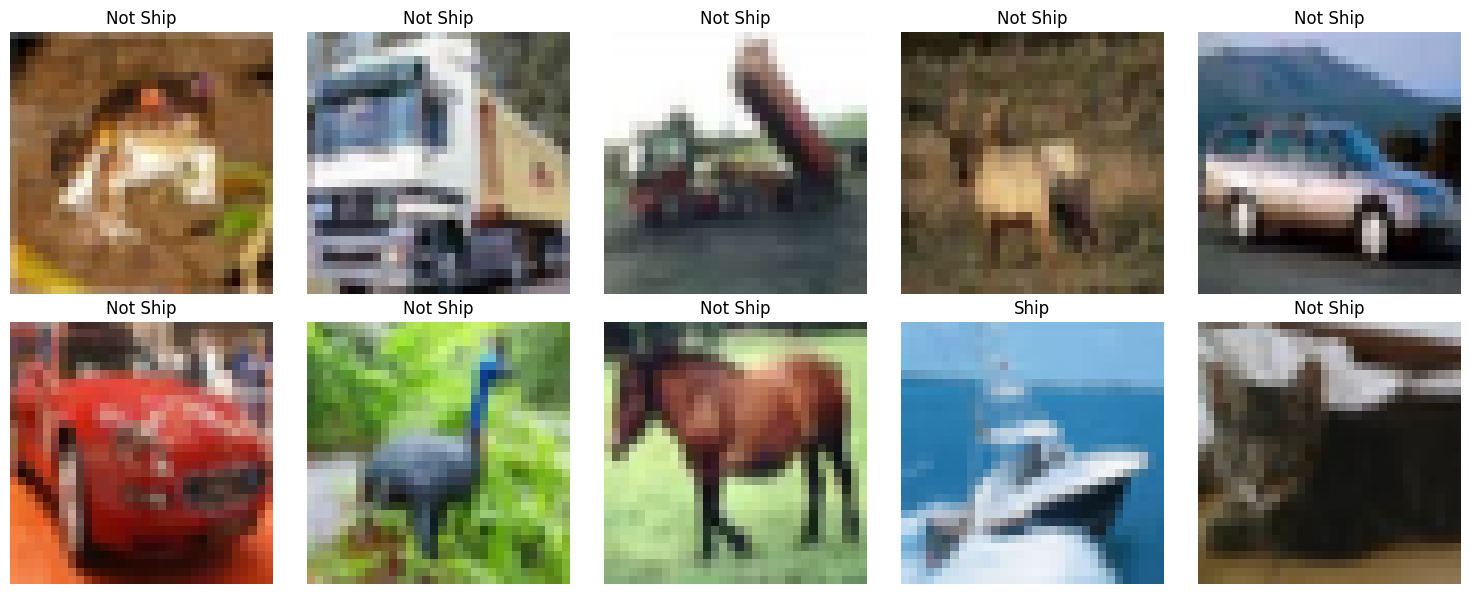

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(train_data[i])
    ax.set_title("Ship" if binary_train_labels[i] == 1 else "Not Ship")
    ax.axis('off')

plt.tight_layout()
plt.show()

### FineTuning the Model

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_schedule(epoch):
    initial_lr = 0.0001
    drop = 0.1
    epochs_drop = 7.0
    lr = initial_lr * (drop ** np.floor((1+epoch)/epochs_drop))
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [ ]:
# Unfreeze a few top layers of the base model
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Define a binary classification head
binary_model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model for binary classification
binary_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

callbacks_list = [lr_scheduler, early_stop]

# Fine-tune the model
history_finetune = binary_model.fit(train_data, binary_train_labels, epochs=50, batch_size=32, validation_data=(test_data, binary_test_labels), callbacks=callbacks_list)


Epoch 1/50
1563/1563 [==============================] - 112s 48ms/step - loss: 0.1717 - accuracy: 0.9402 - val_loss: 0.1004 - val_accuracy: 0.9659 - lr: 1.0000e-04
Epoch 2/50
1563/1563 [==============================] - 71s 45ms/step - loss: 0.0968 - accuracy: 0.9652 - val_loss: 0.0872 - val_accuracy: 0.9698 - lr: 1.0000e-04
Epoch 3/50
1563/1563 [==============================] - 71s 46ms/step - loss: 0.0775 - accuracy: 0.9735 - val_loss: 0.0696 - val_accuracy: 0.9749 - lr: 1.0000e-04
Epoch 4/50
1563/1563 [==============================] - 73s 46ms/step - loss: 0.0603 - accuracy: 0.9796 - val_loss: 0.0738 - val_accuracy: 0.9736 - lr: 1.0000e-04
Epoch 5/50
1563/1563 [==============================] - 71s 45ms/step - loss: 0.0475 - accuracy: 0.9843 - val_loss: 0.0866 - val_accuracy: 0.9689 - lr: 1.0000e-04
Epoch 6/50
1563/1563 [==============================] - 75s 48ms/step - loss: 0.0395 - accuracy: 0.9870 - val_loss: 0.0681 - val_accuracy: 0.9758 - lr: 1.0000e-04
Epoch 7/50
1563/1563 

In [ ]:
binary_model.save("resnet50_cifar10_ships.h5")
binary_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 9)                 24114569  
                                                                 
 flatten_6 (Flatten)         (None, 9)                 0         
                                                                 
 dense_13 (Dense)            (None, 512)               5120      
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_14 (Dense)            (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_15 (Dense)            (None, 1)                

## Visuals

### Activation

1/1 [==============================] - 0s 37ms/step


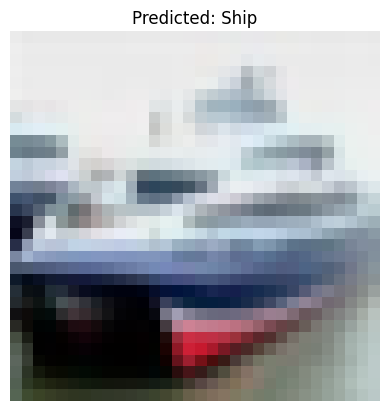

In [ ]:
import matplotlib.pyplot as plt

# Predict the label for test_data[1]
prediction = binary_model.predict(np.expand_dims(test_data[1], axis=0))

# Convert prediction to label
if prediction >= 0.5:
    label = 'Ship'
else:
    label = 'Not Ship'

# Plot the image
plt.imshow(test_data[1])
plt.title(f"Predicted: {label}")
plt.axis('off')
plt.show()

In [161]:
from tensorflow.keras.models import Model

# Retrieve the inner model from the main model
inner_model = binary_model.get_layer("sequential_4")

resnet_submodel = inner_model.get_layer("resnet50")

layer_outputs = [layer.output for layer in resnet_submodel.layers[:8]]
activation_model = Model(inputs=resnet_submodel.input, outputs=layer_outputs)

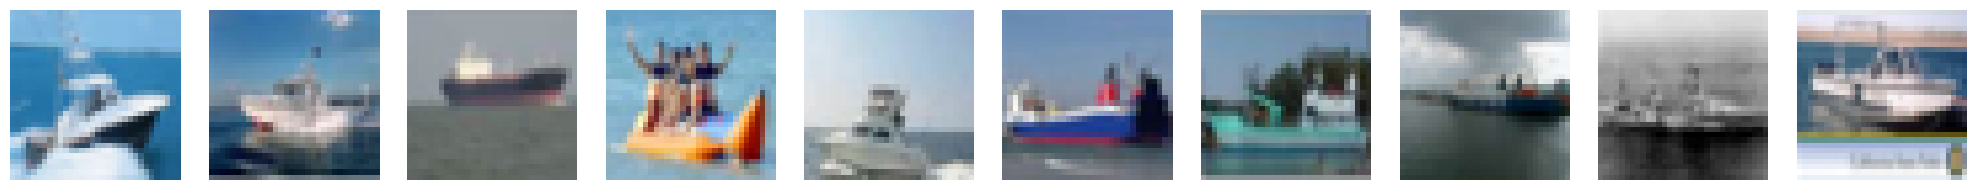

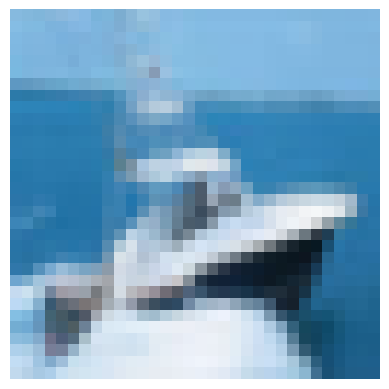

1/1 [==============================] - 0s 88ms/step
Layer 0 has only 3 feature maps.
Layer 1 has only 3 feature maps.


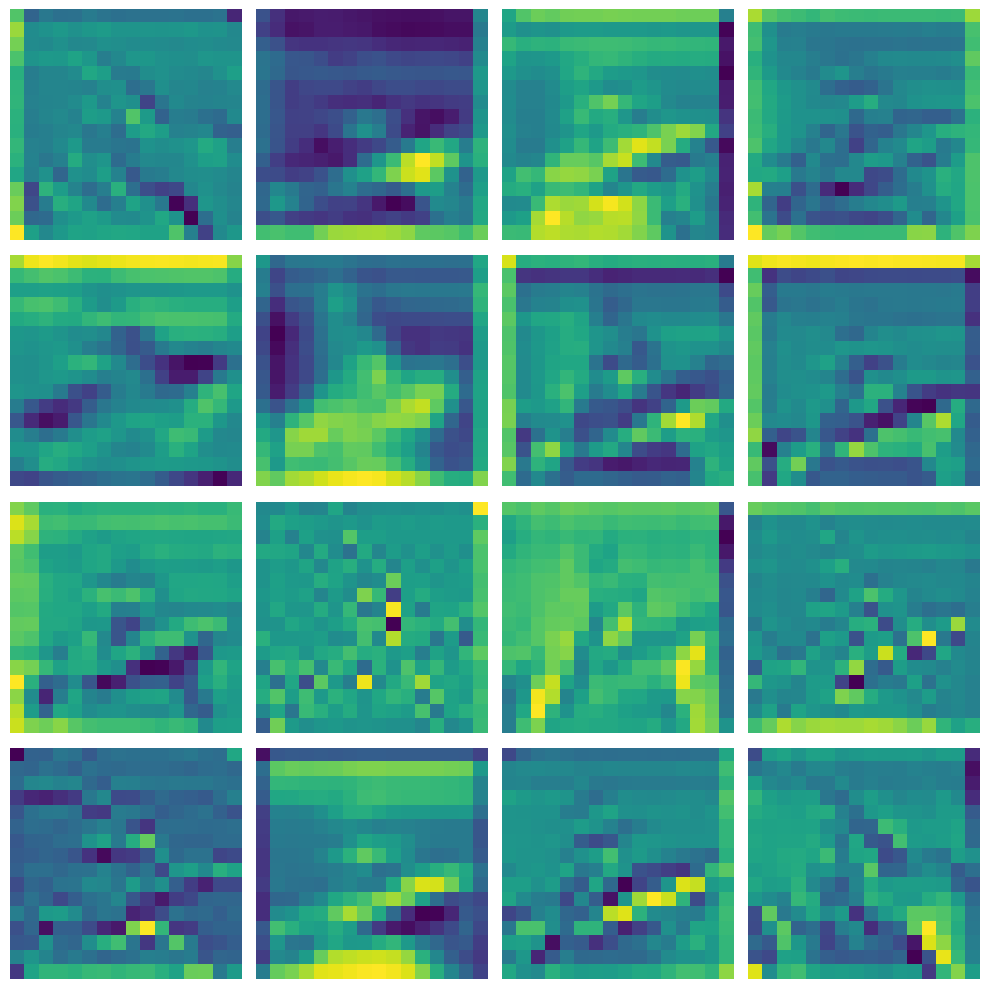

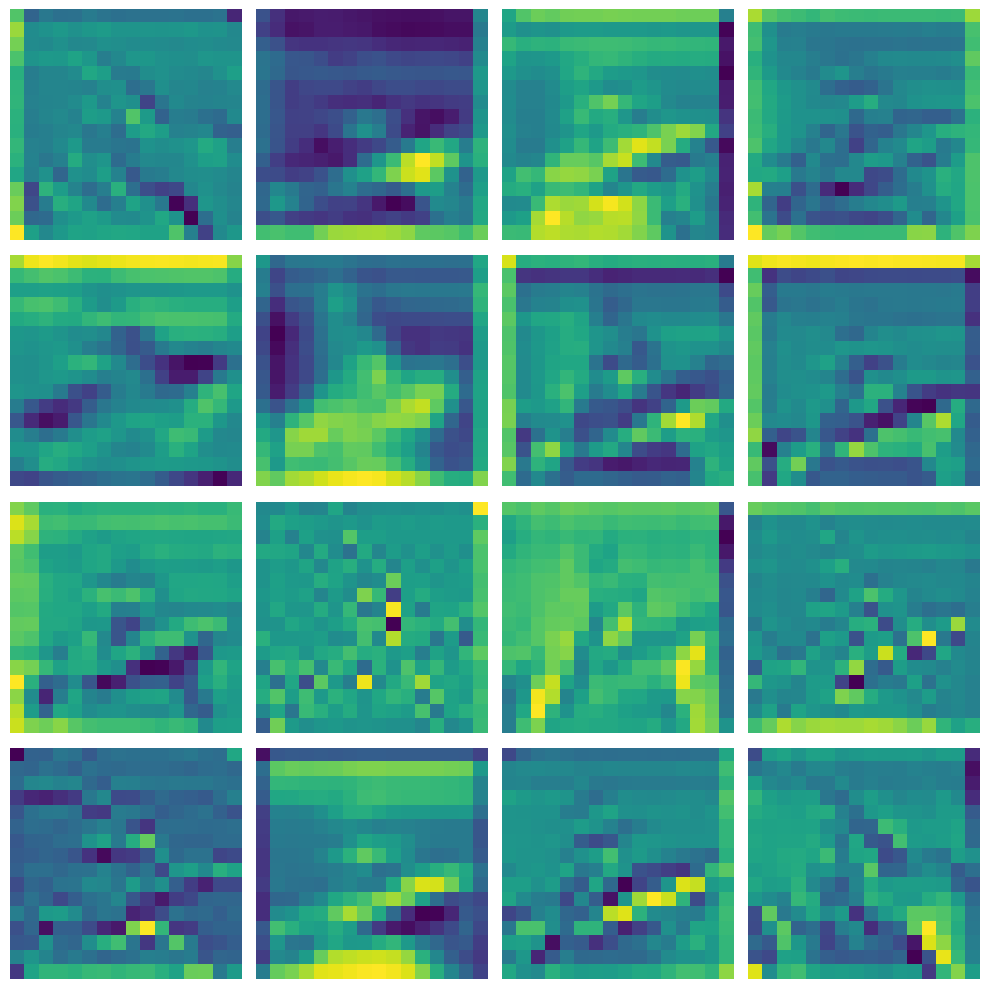

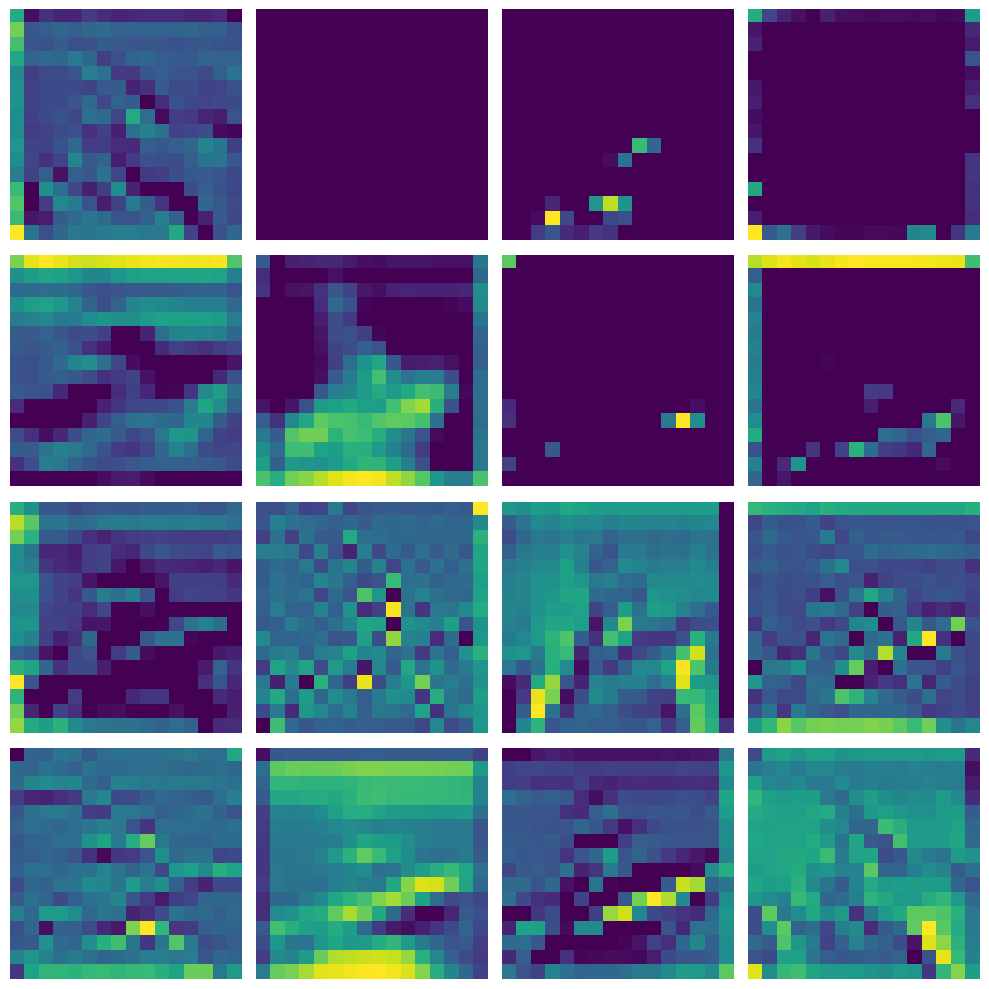

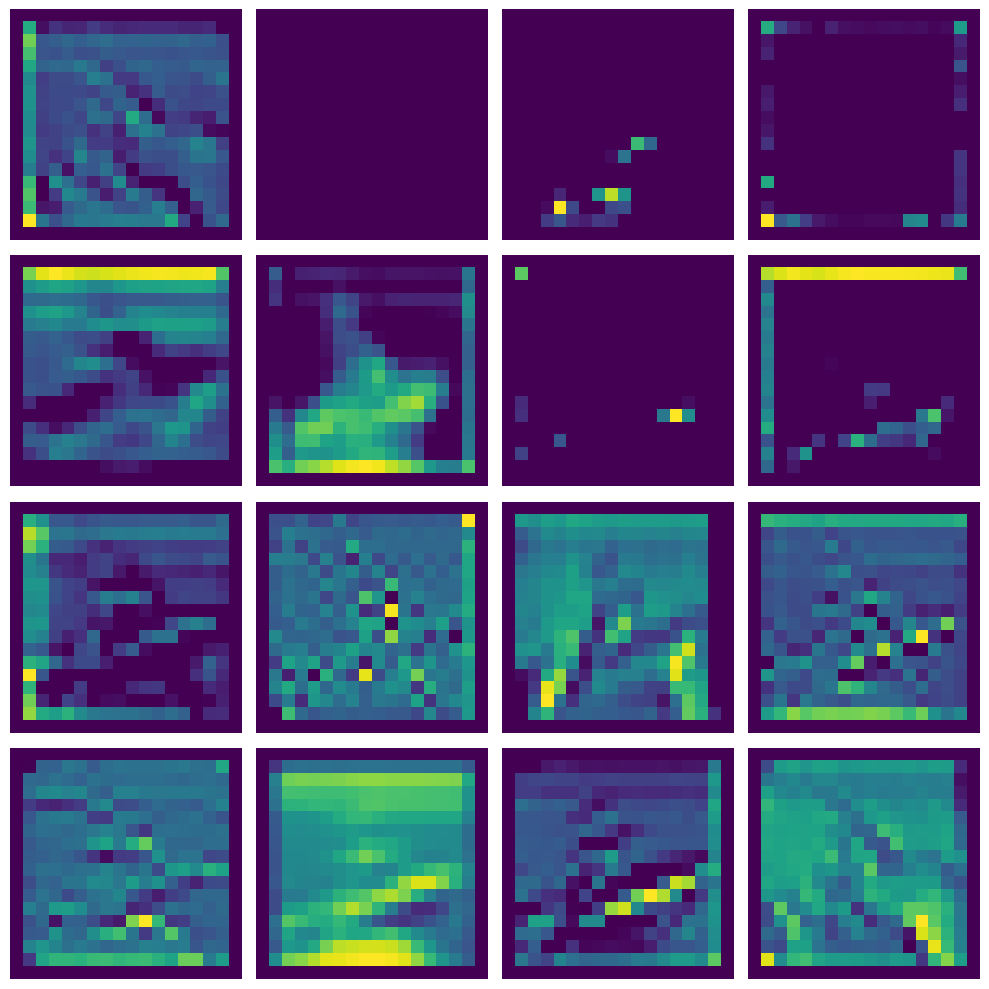

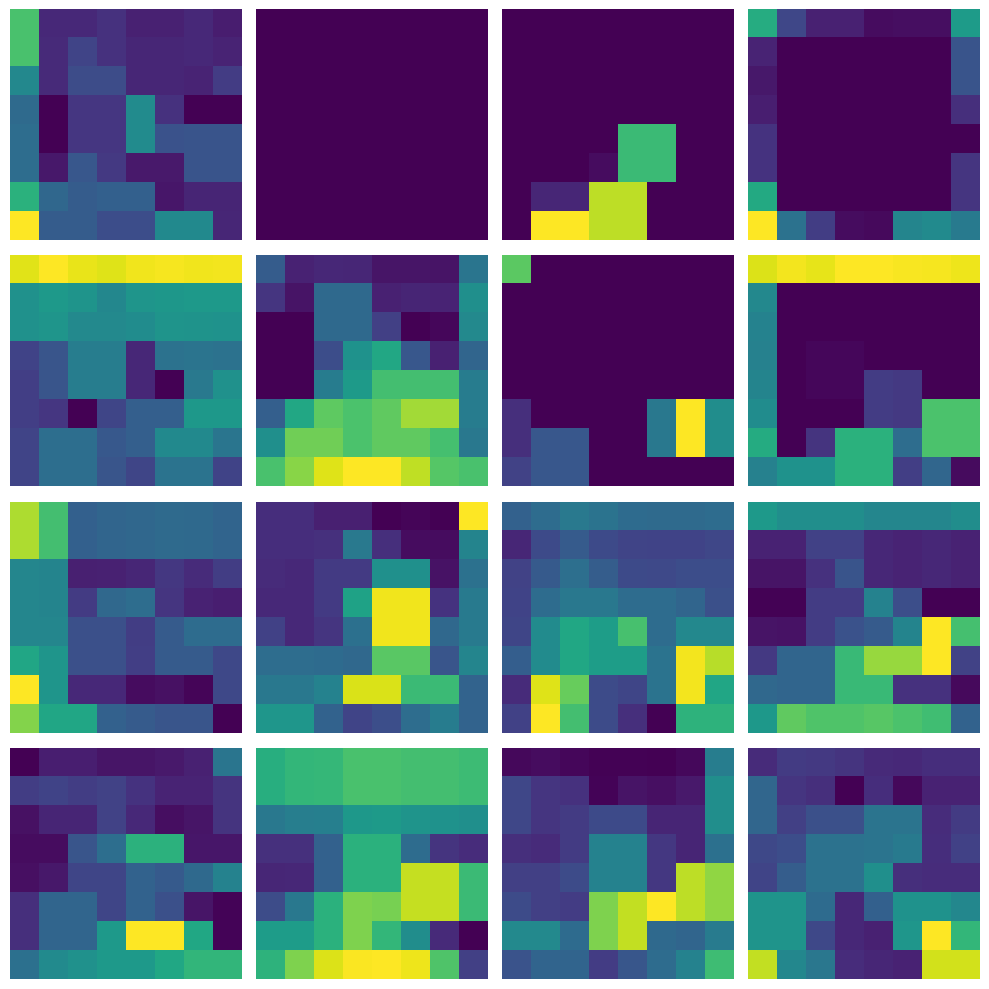

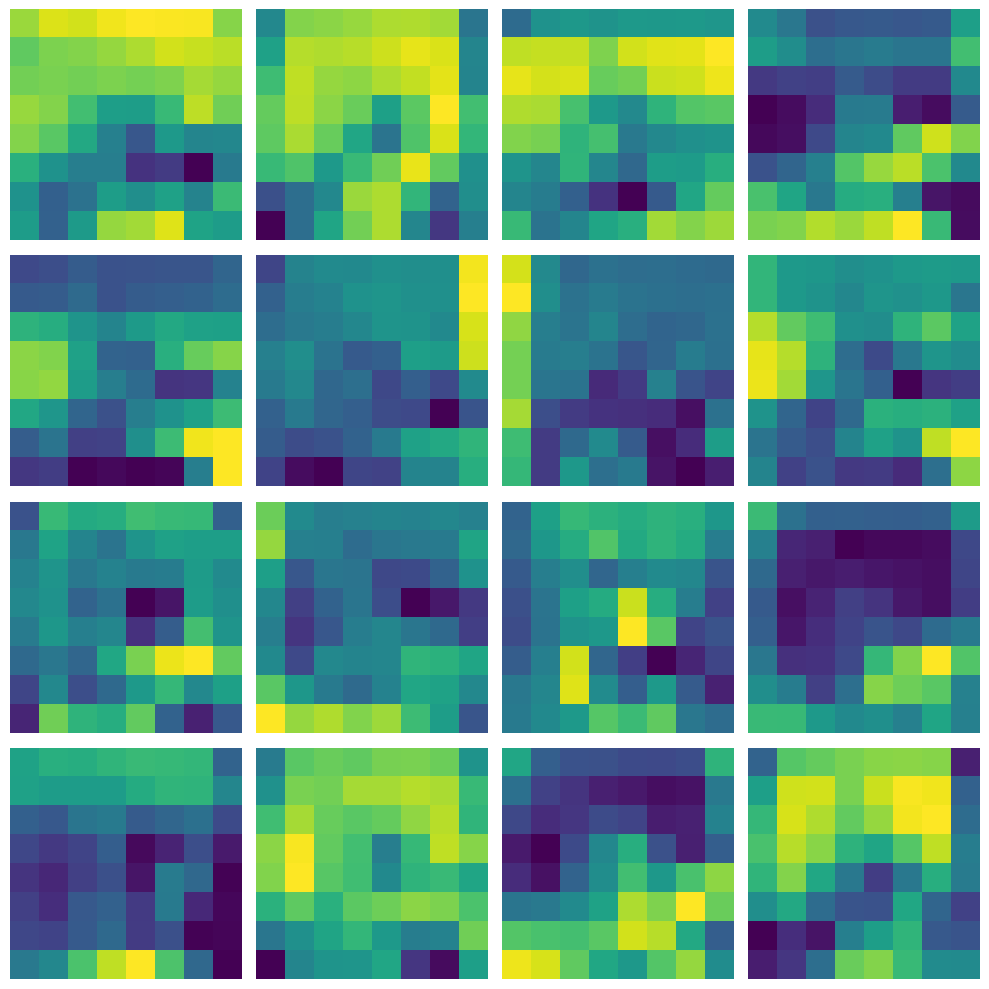

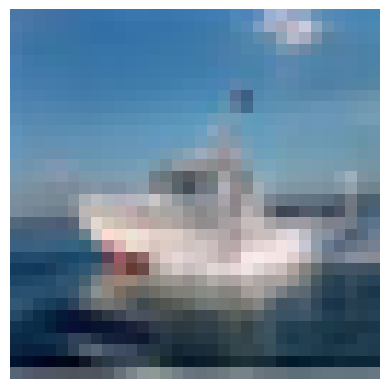

1/1 [==============================] - 0s 29ms/step
Layer 0 has only 3 feature maps.
Layer 1 has only 3 feature maps.


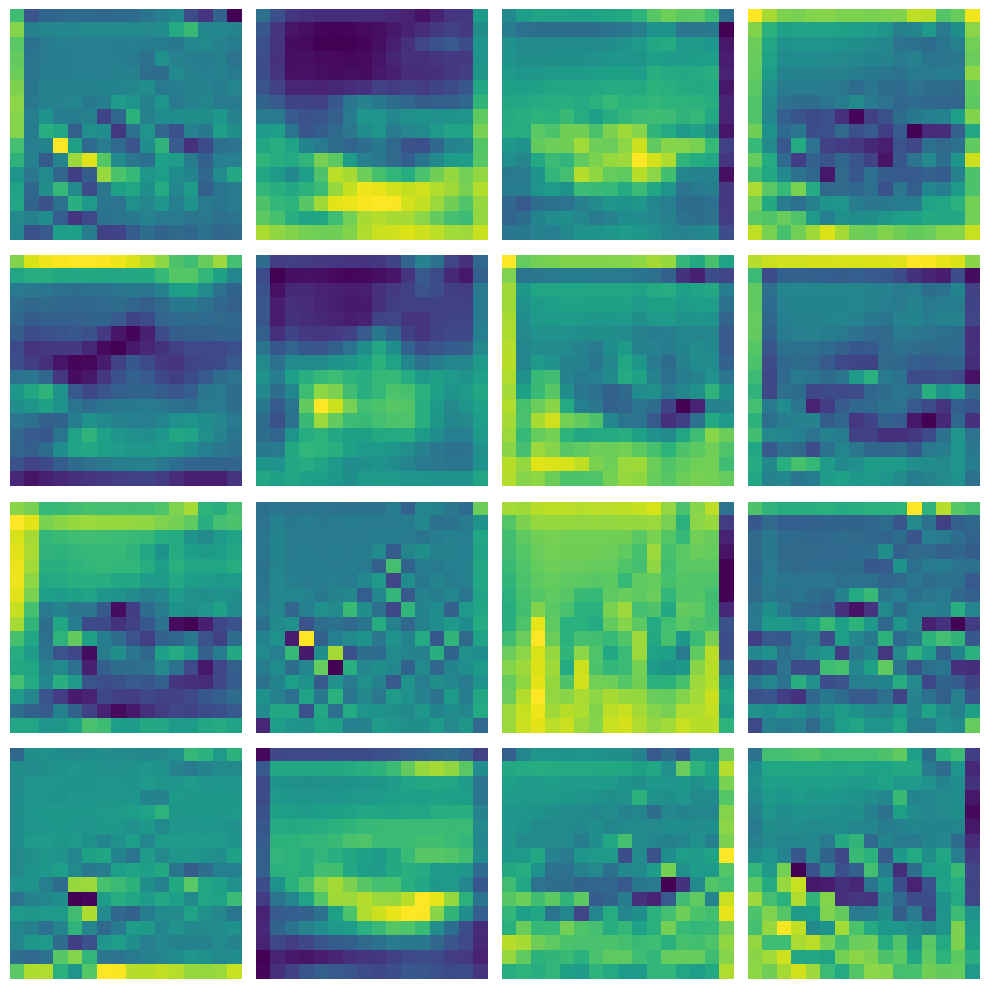

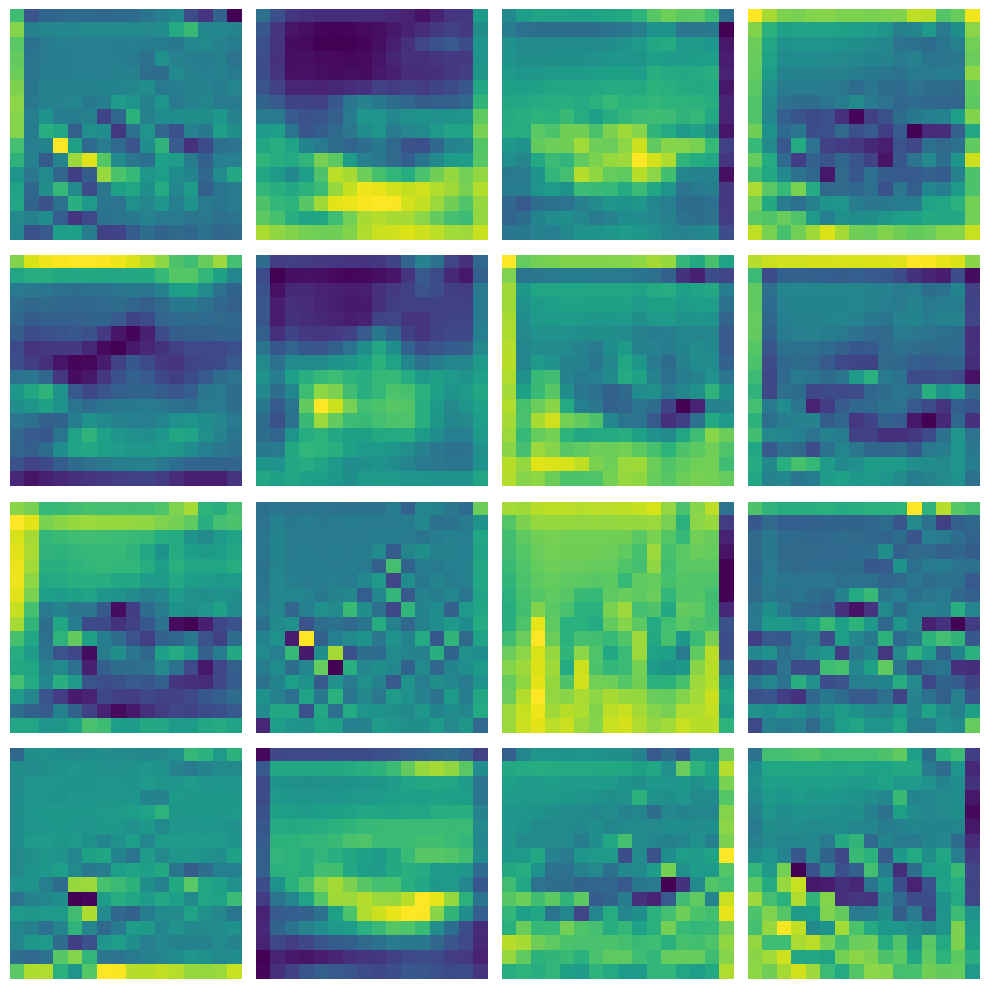

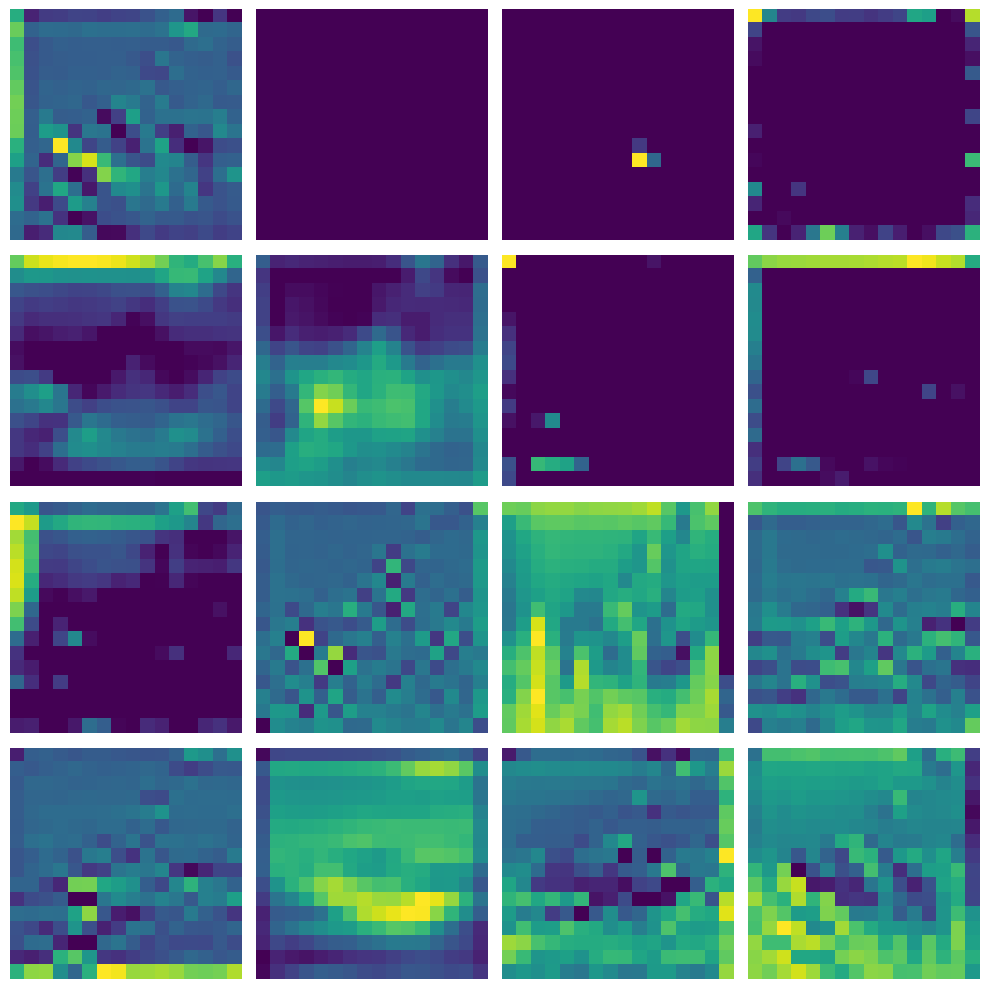

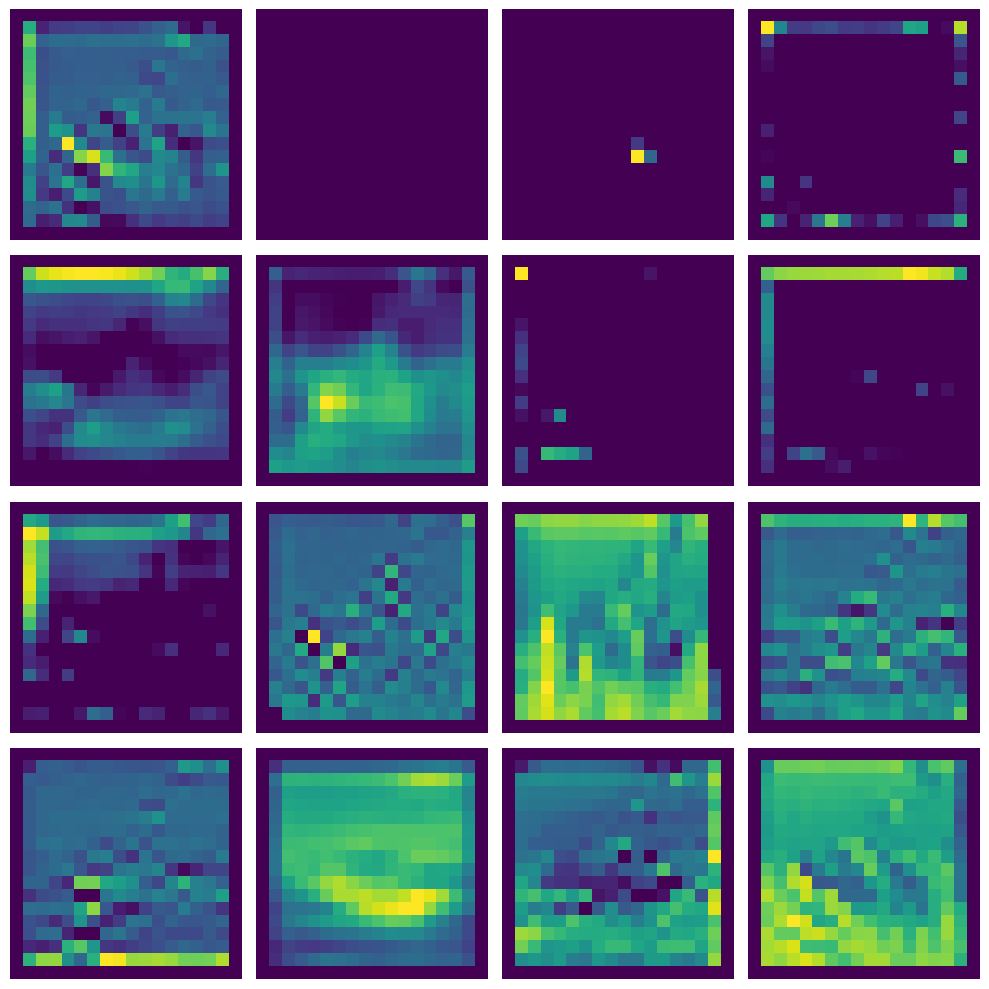

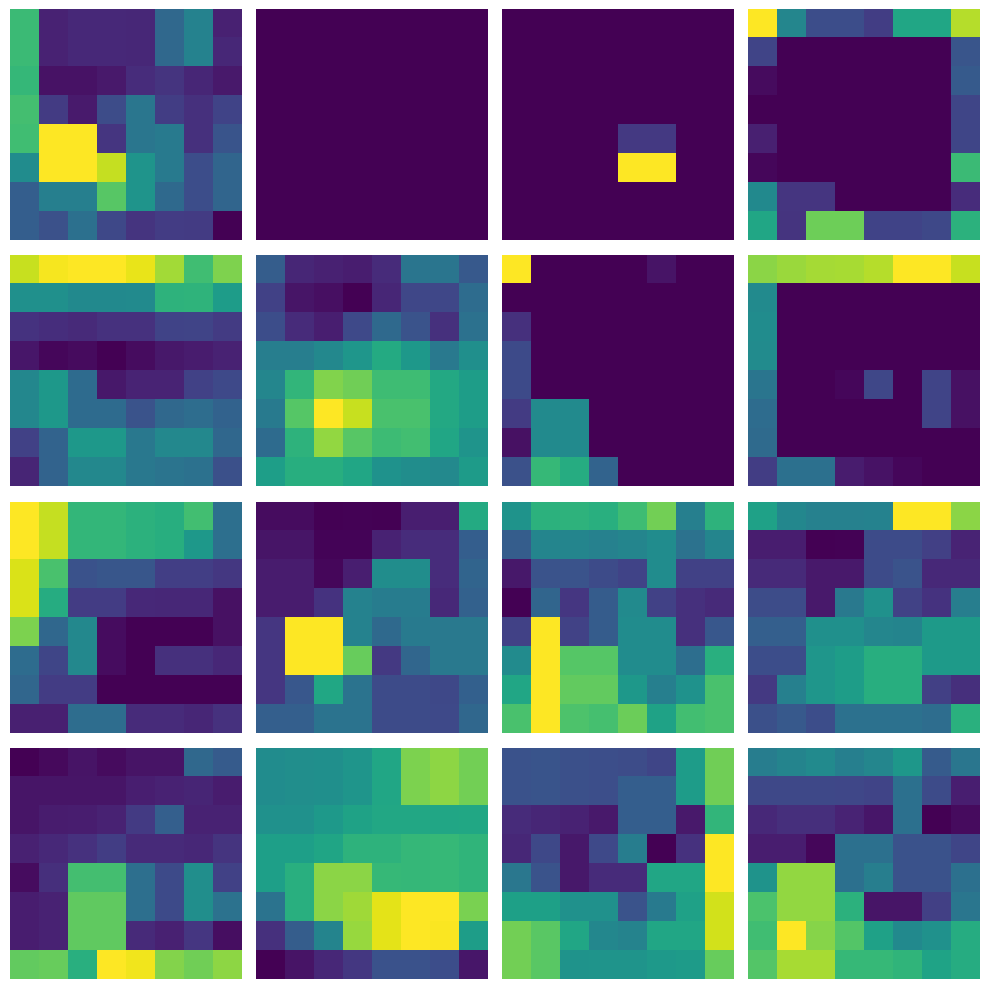

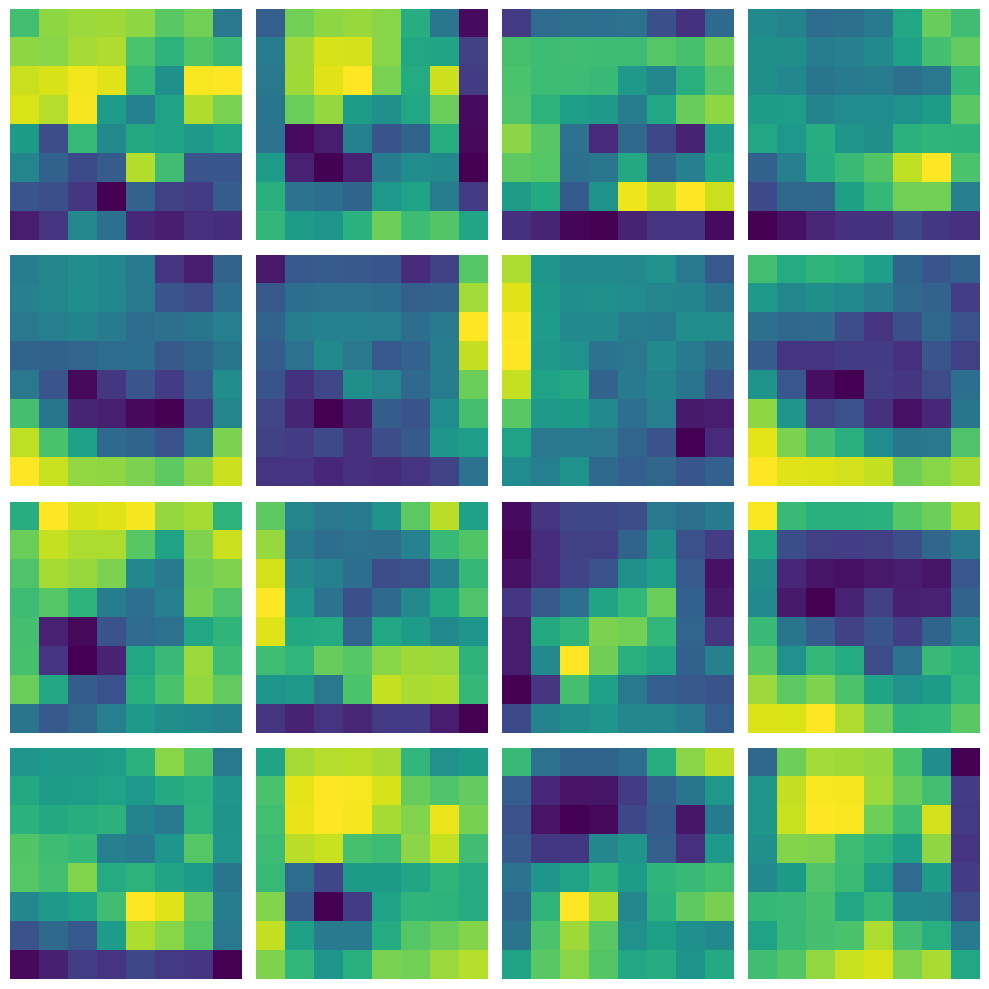

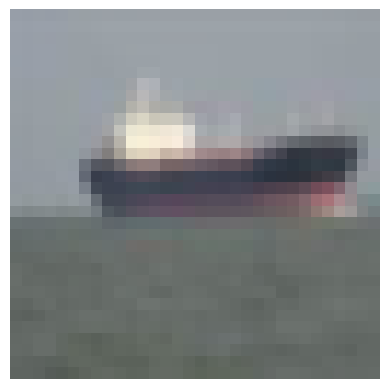

1/1 [==============================] - 0s 41ms/step
Layer 0 has only 3 feature maps.
Layer 1 has only 3 feature maps.


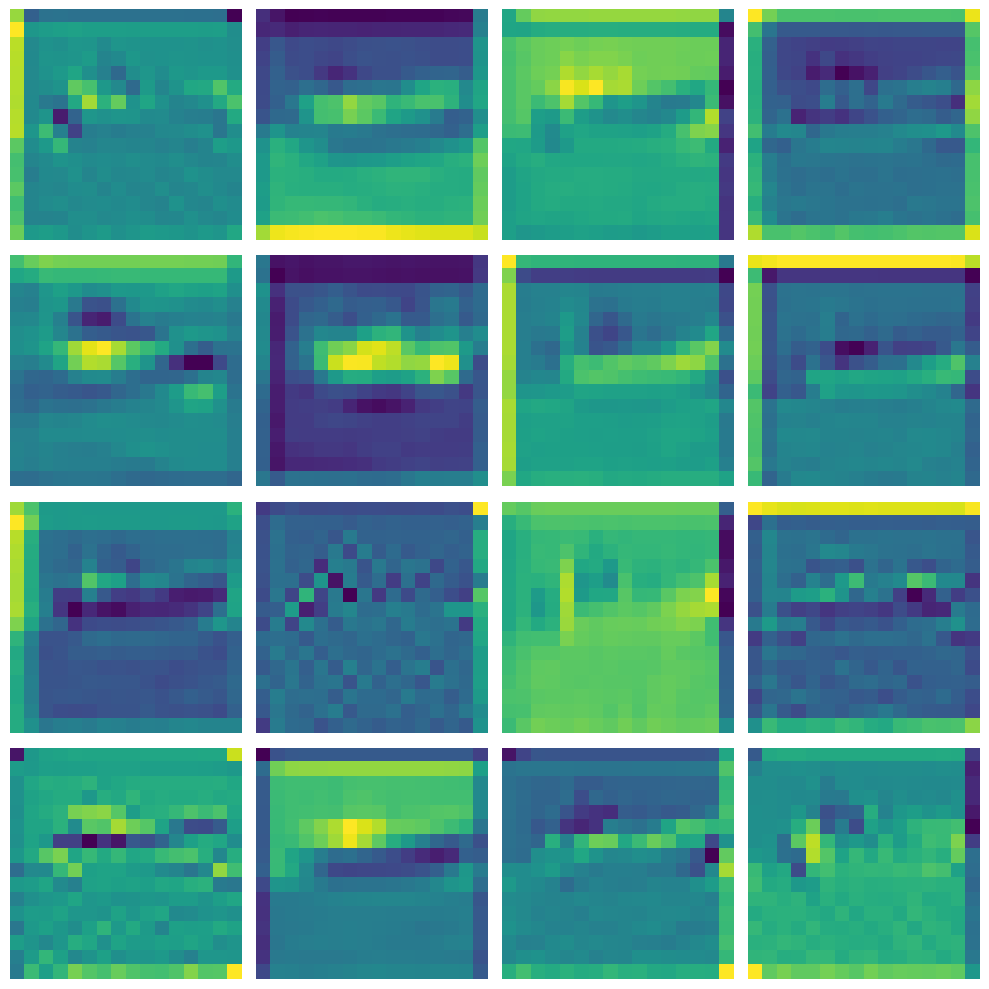

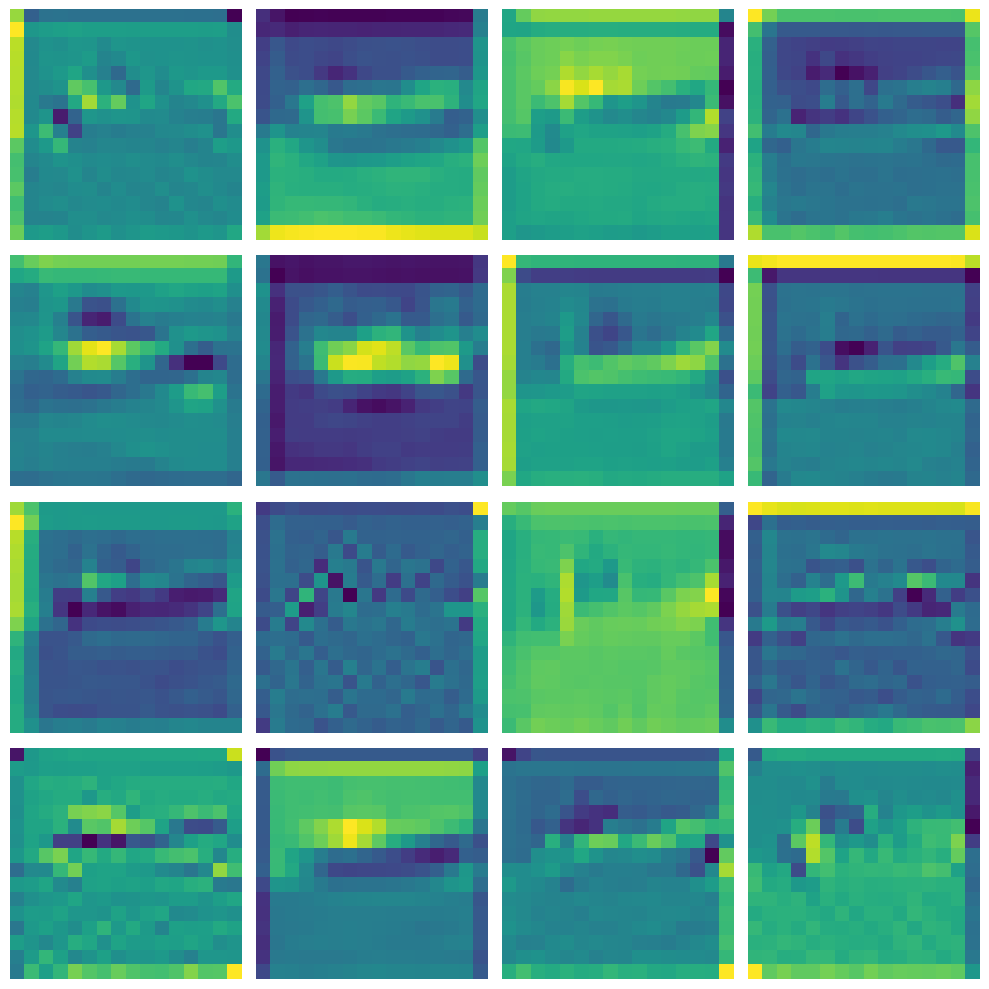

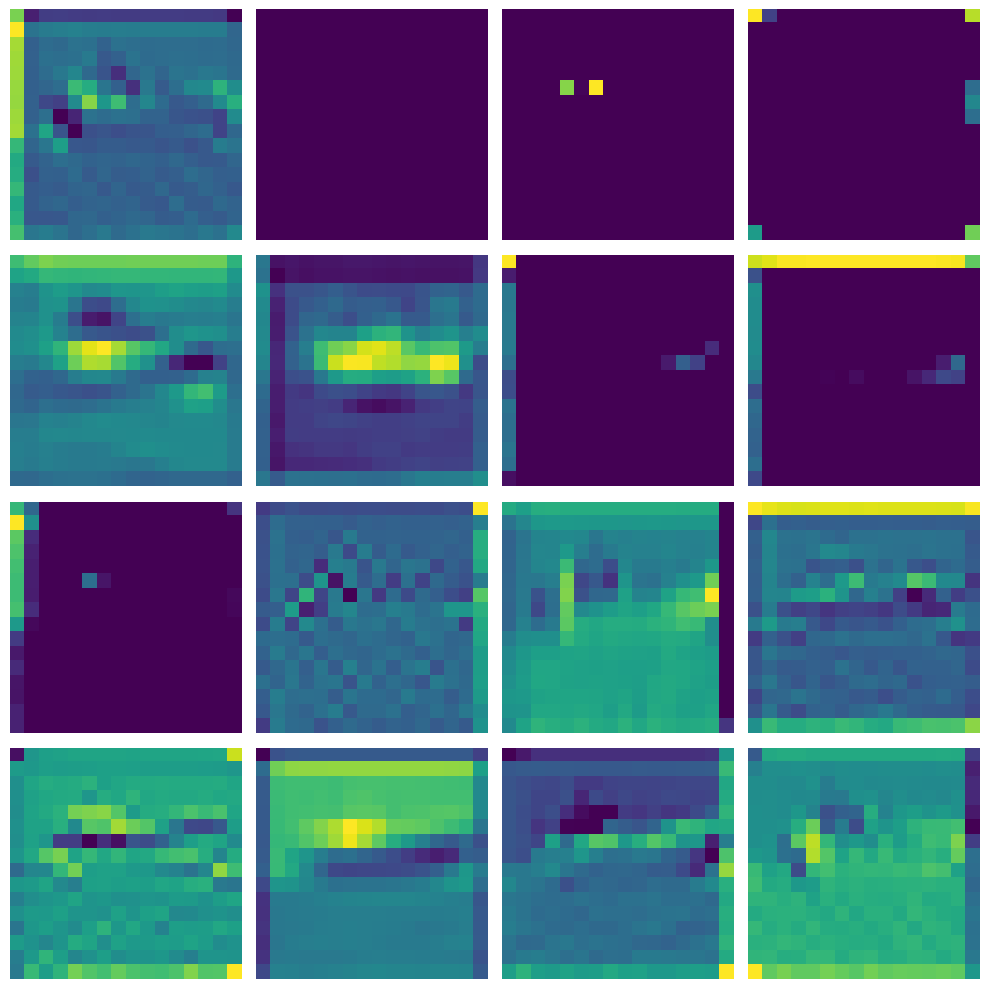

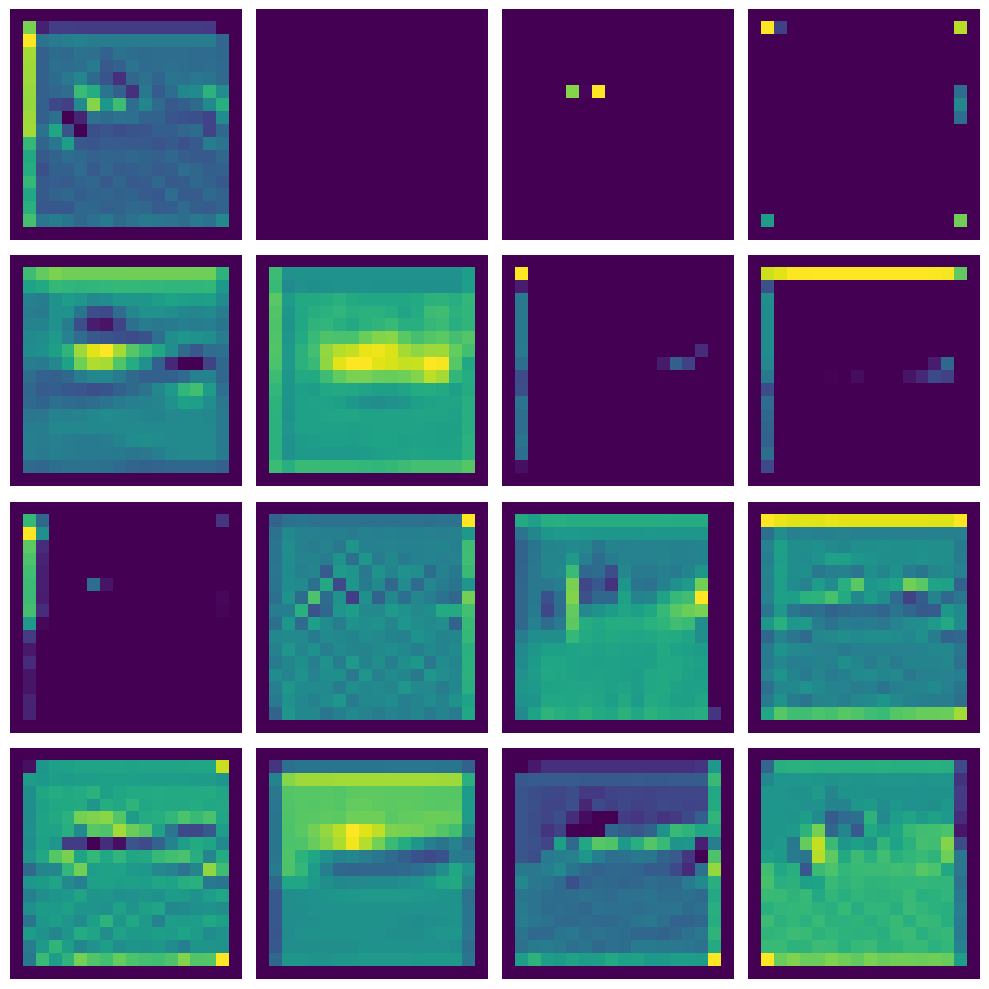

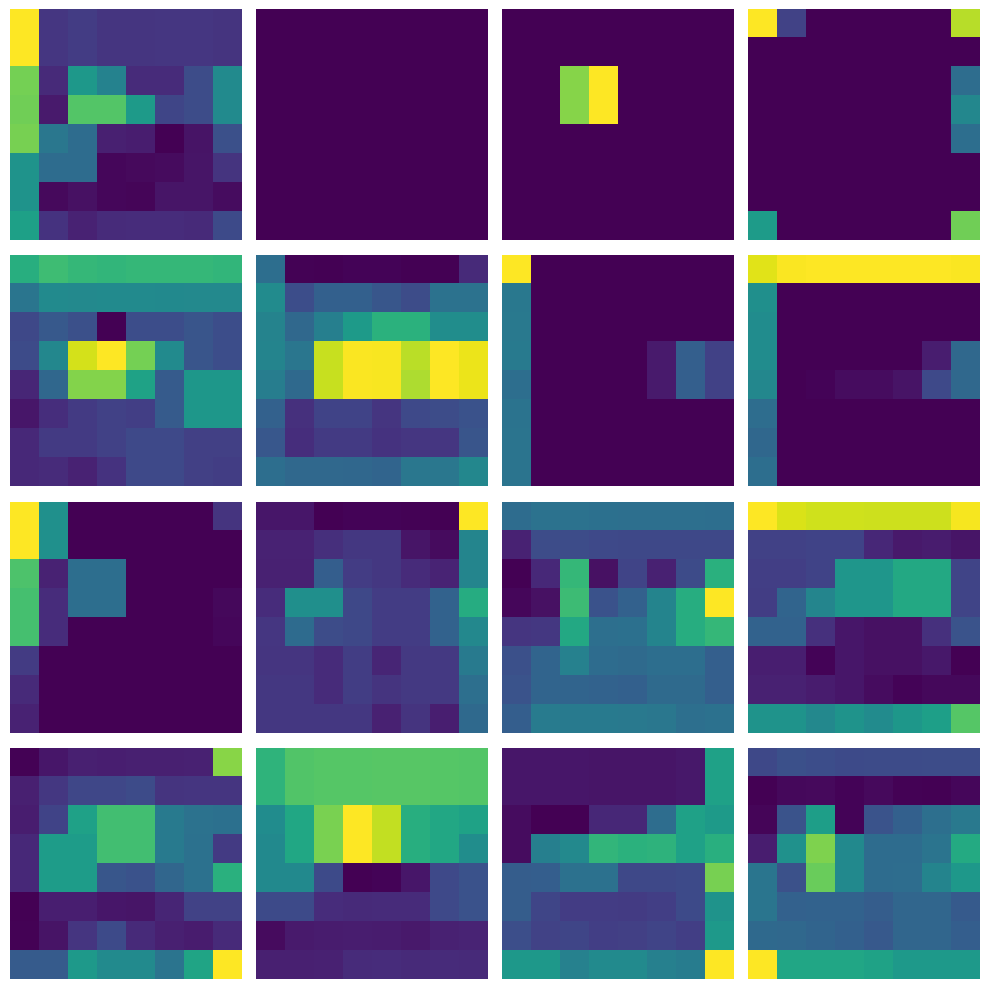

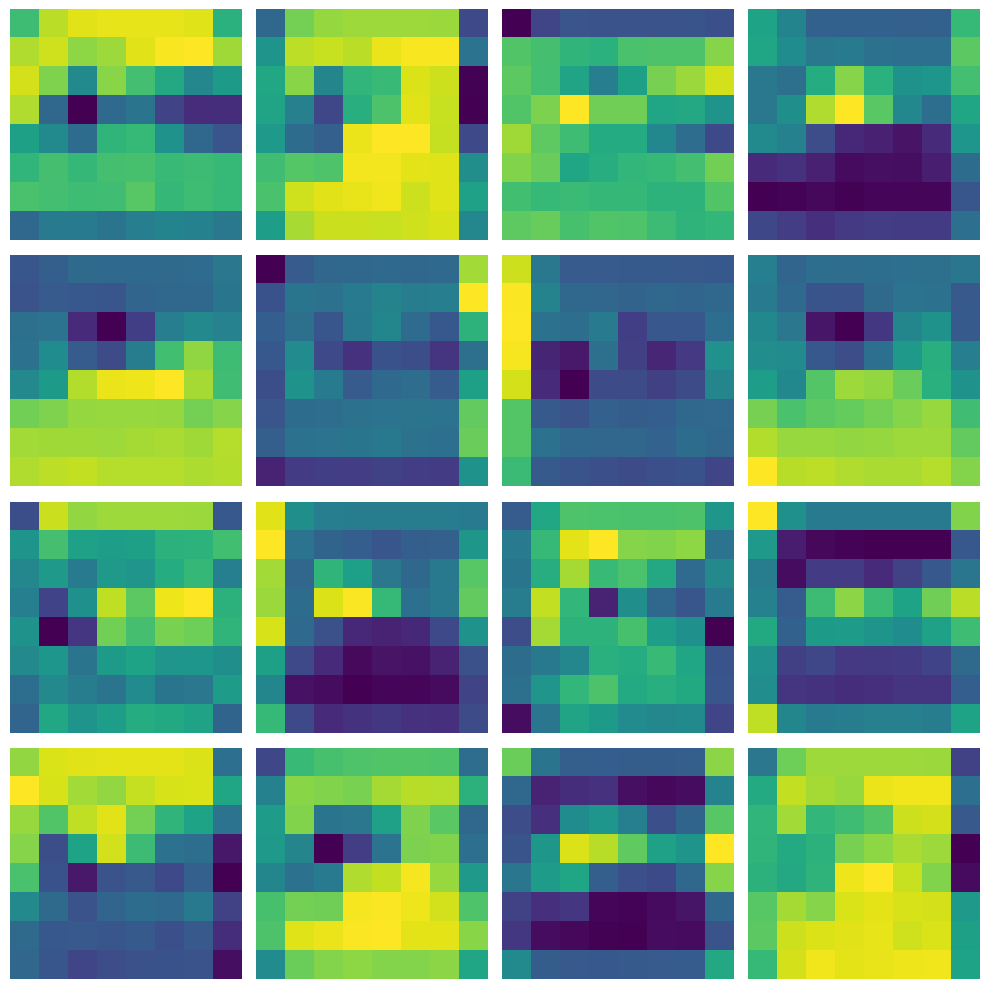

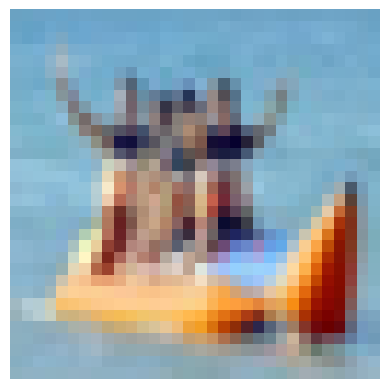

1/1 [==============================] - 0s 33ms/step
Layer 0 has only 3 feature maps.
Layer 1 has only 3 feature maps.


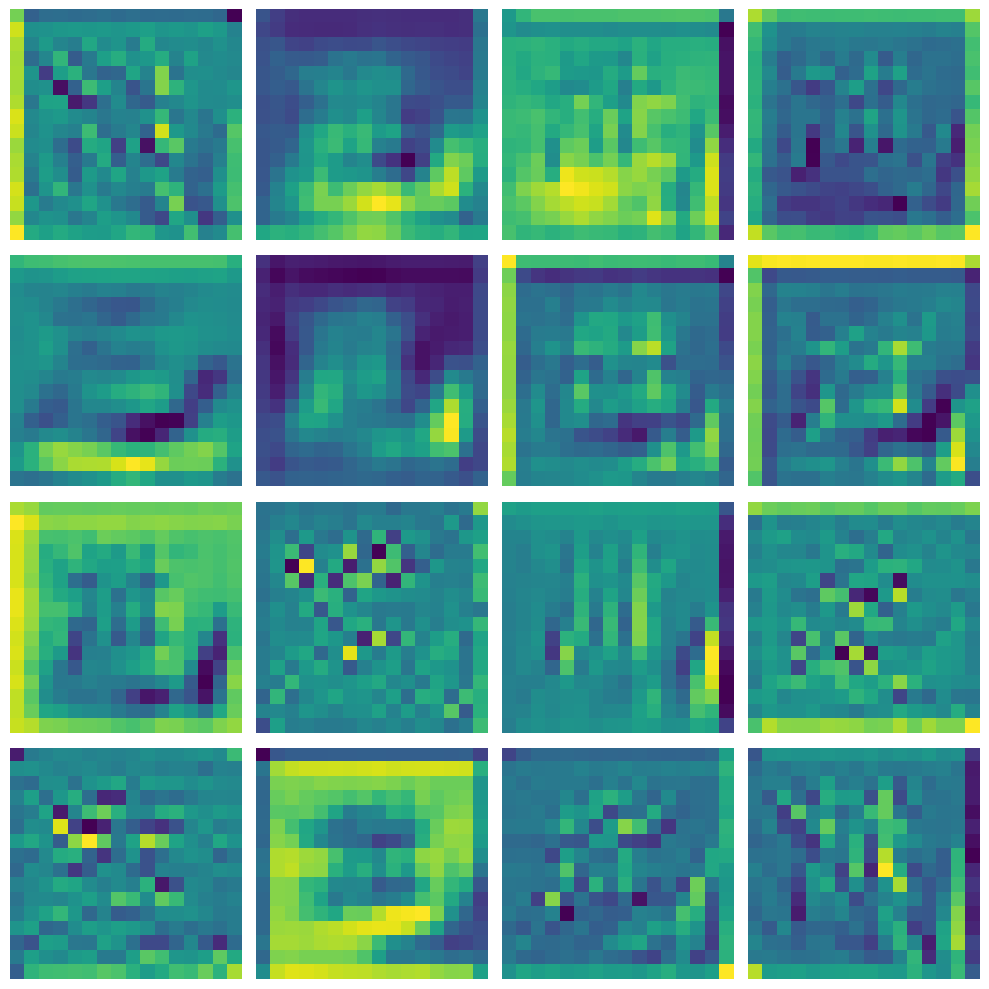

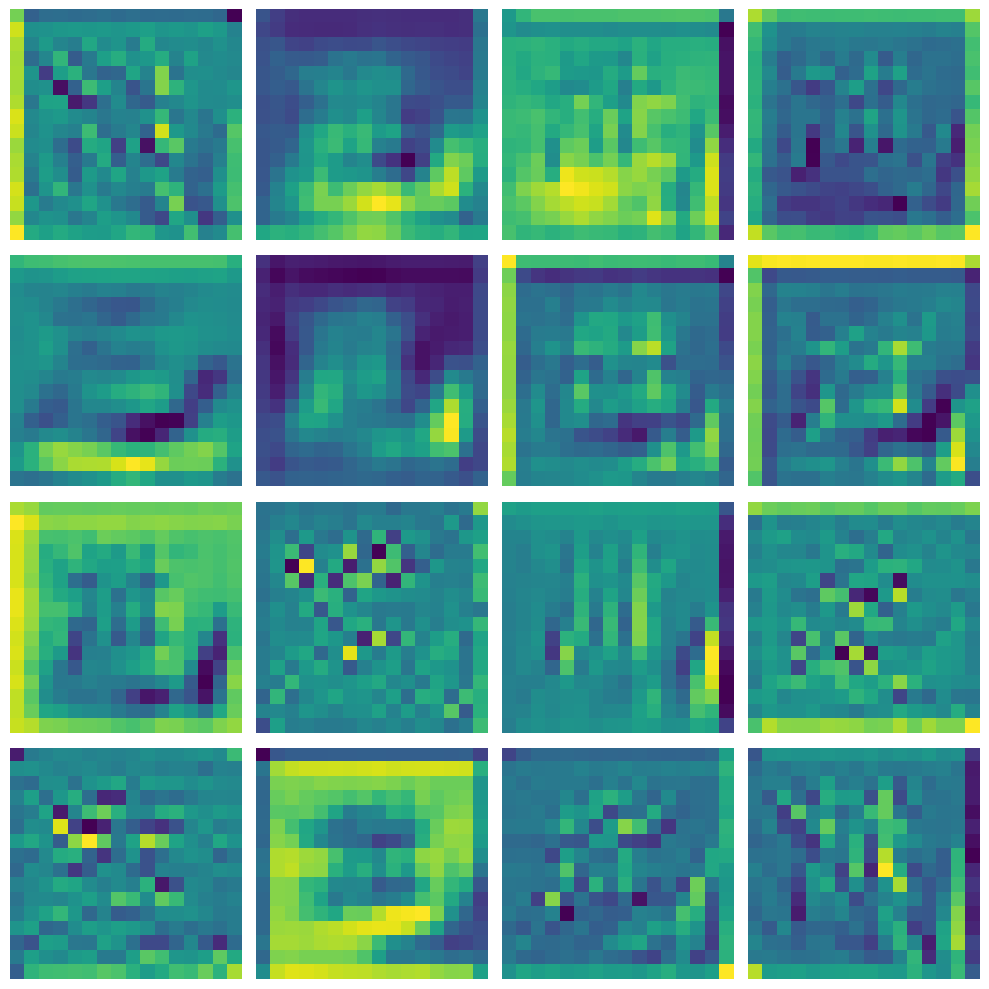

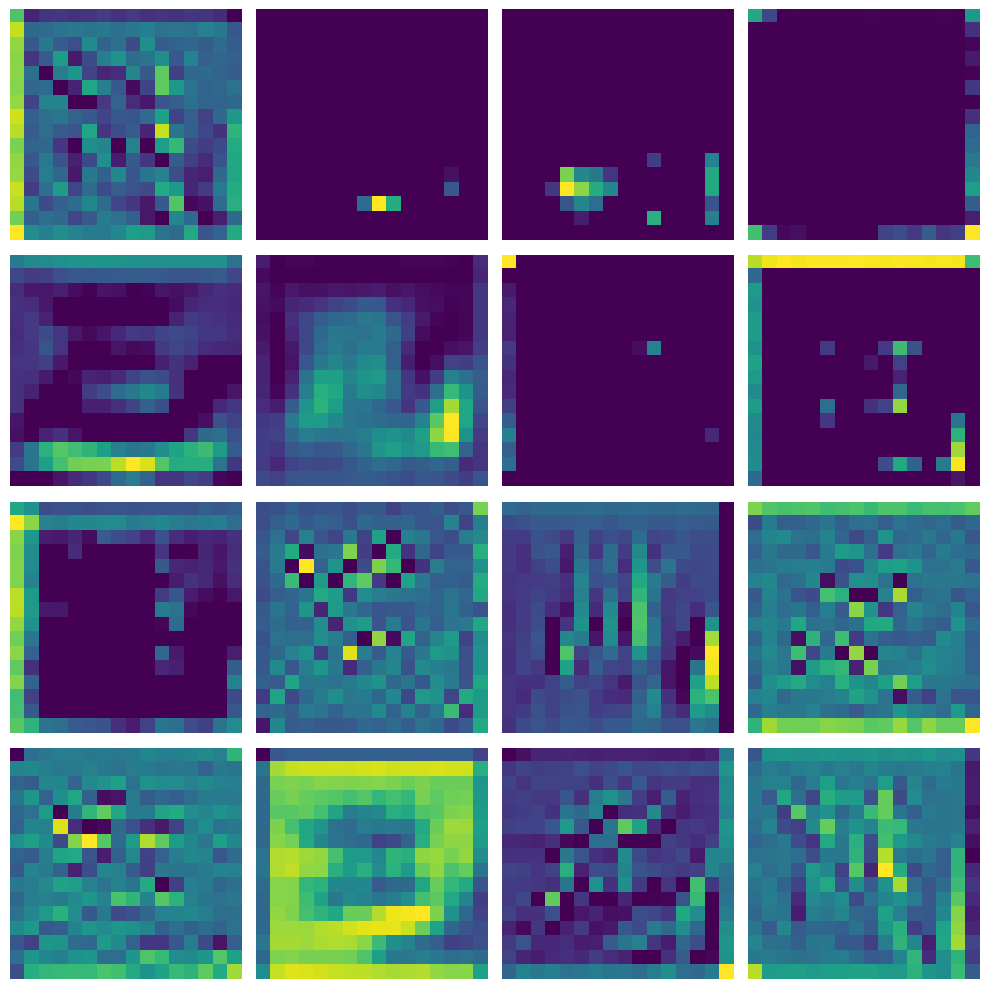

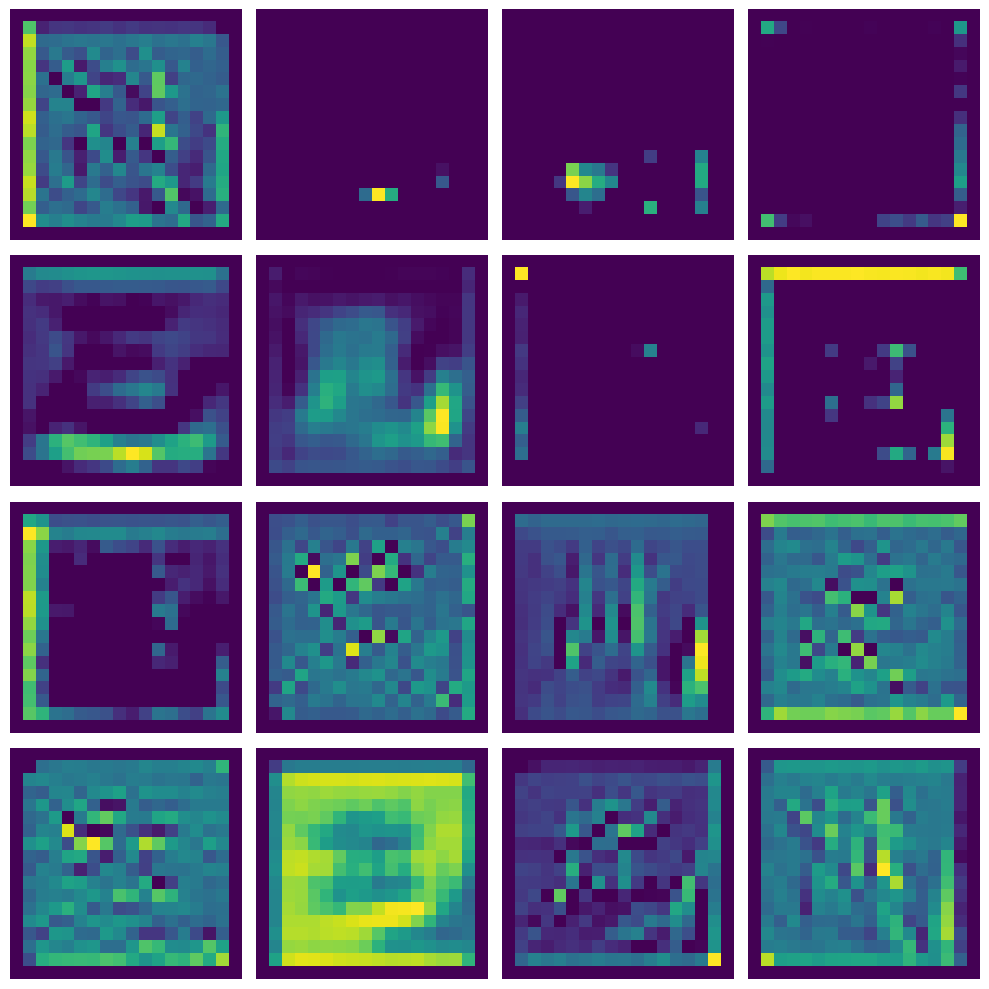

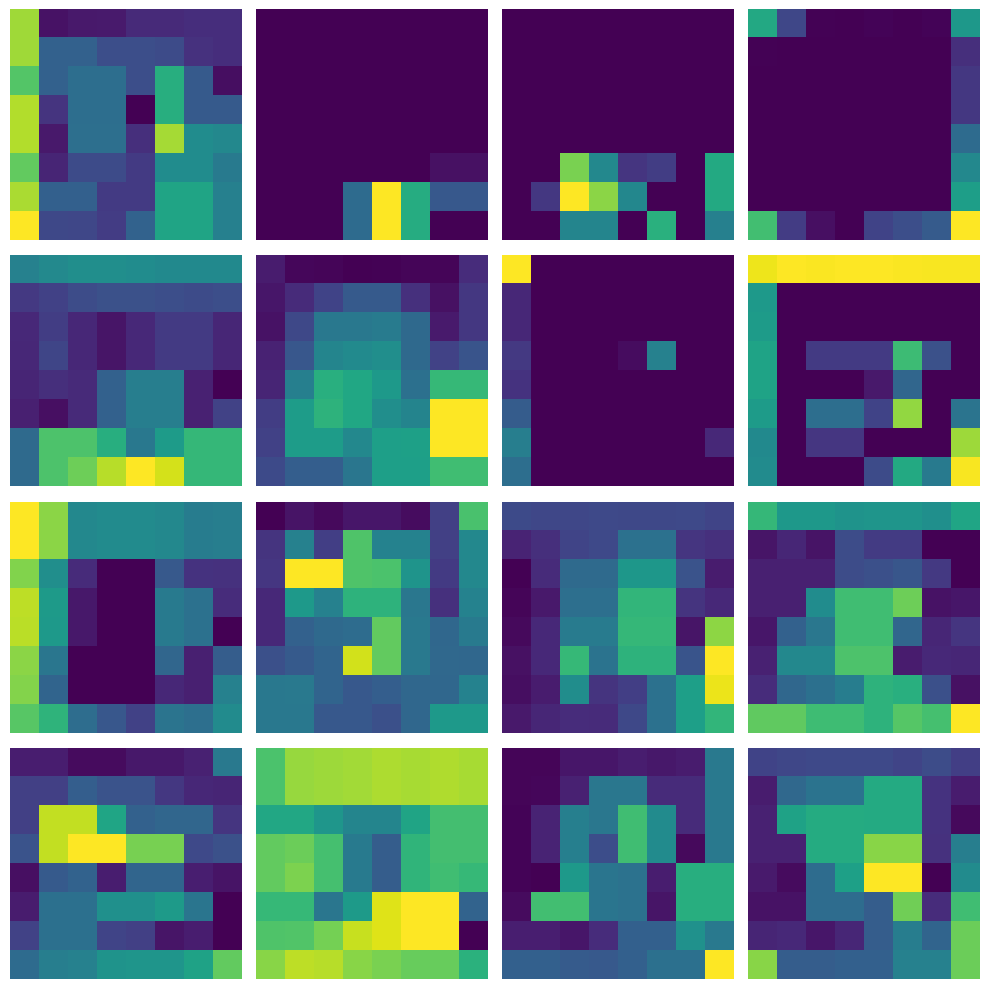

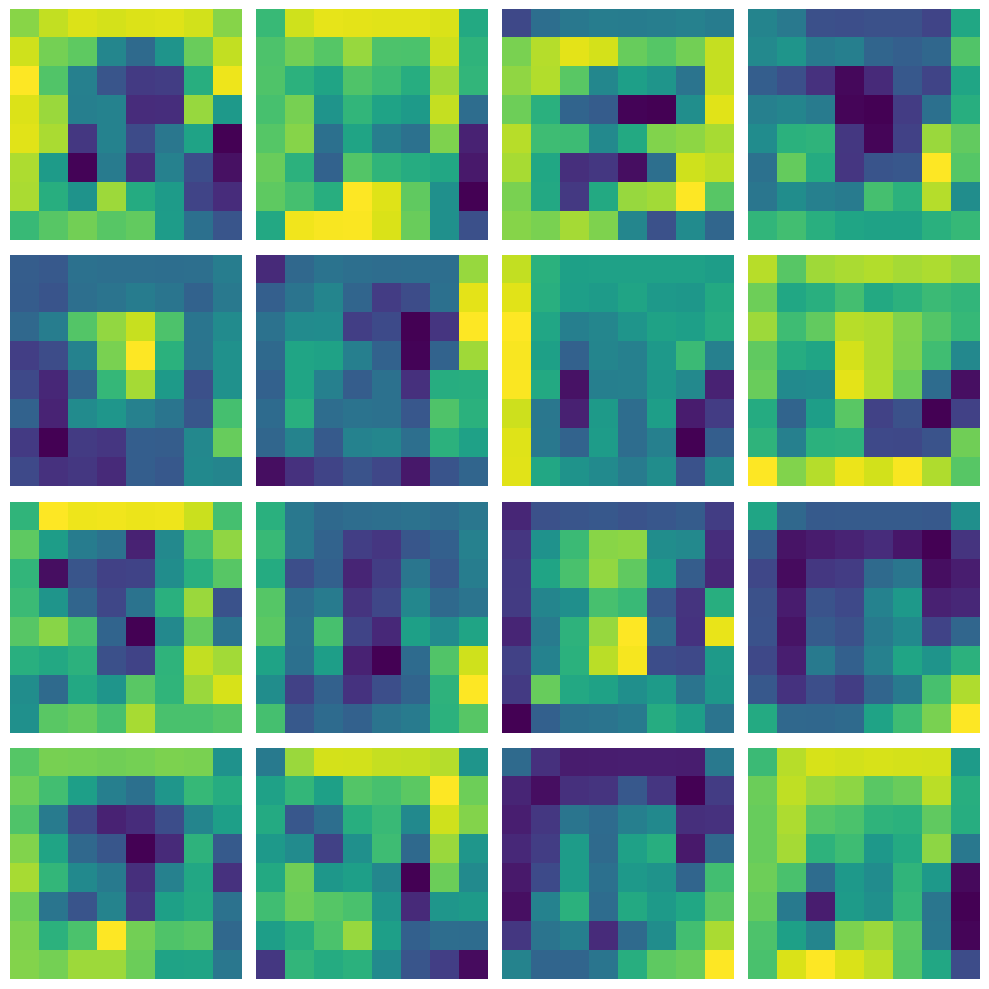

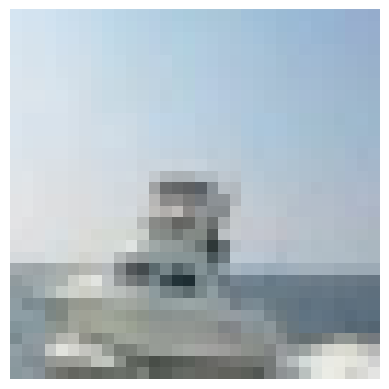

1/1 [==============================] - 0s 34ms/step
Layer 0 has only 3 feature maps.
Layer 1 has only 3 feature maps.


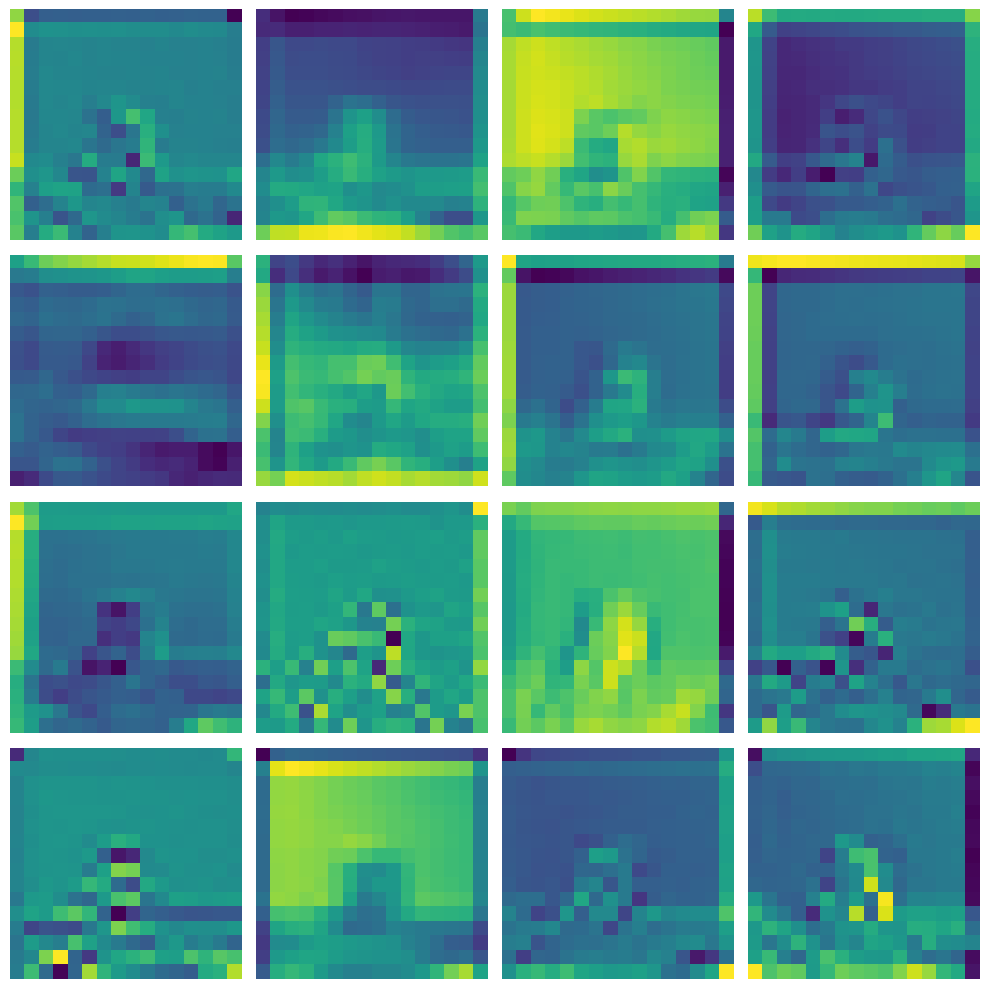

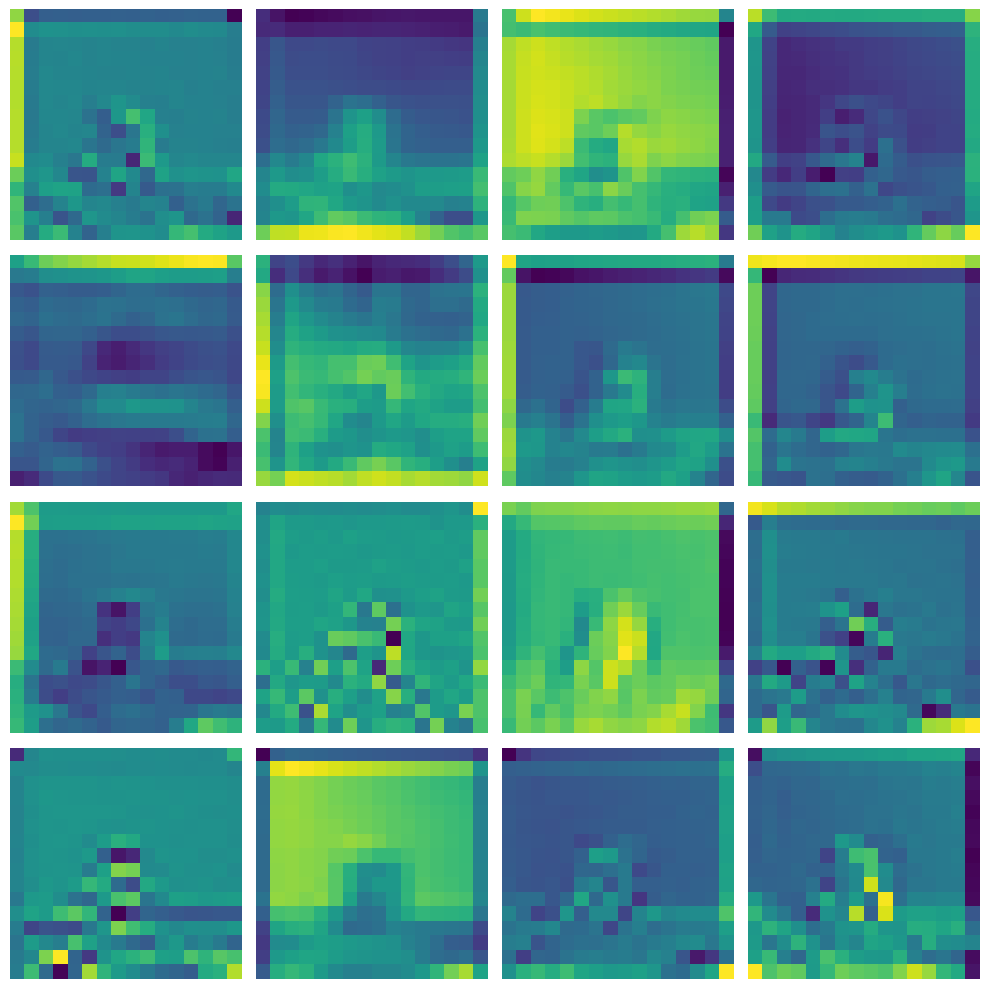

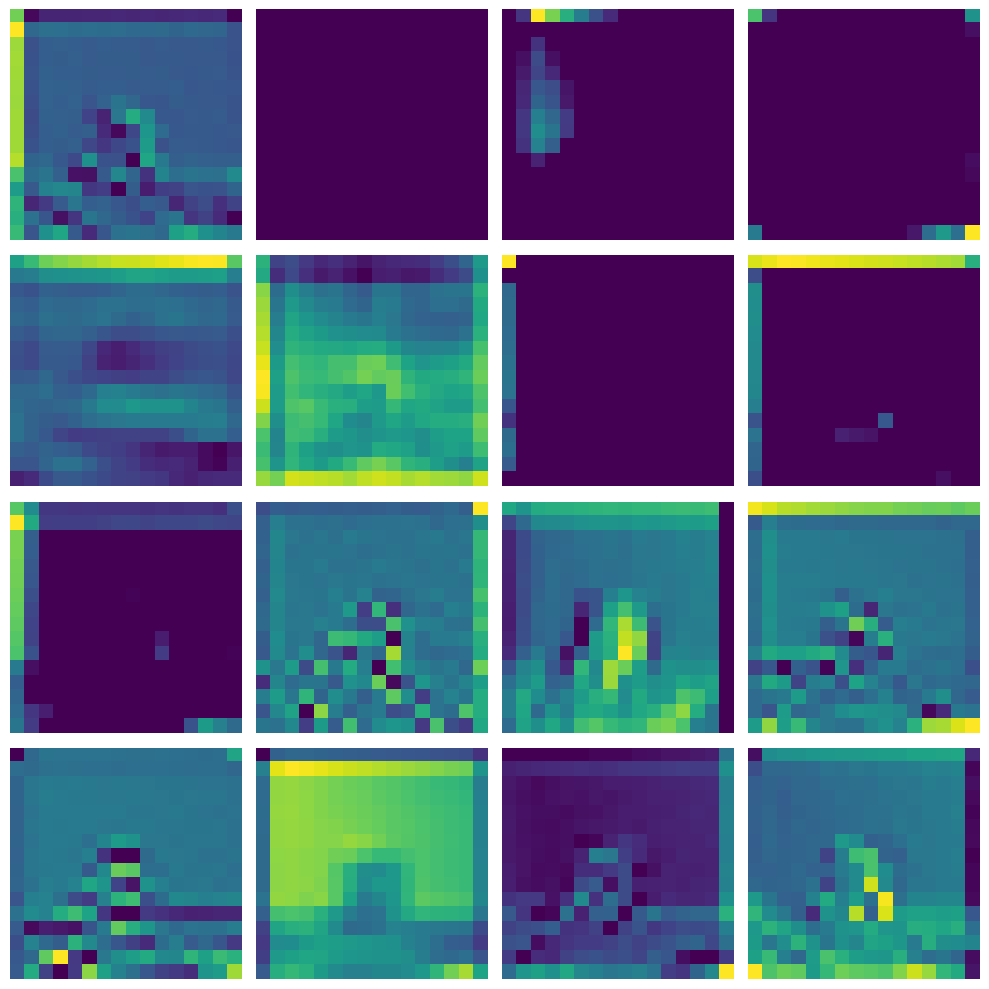

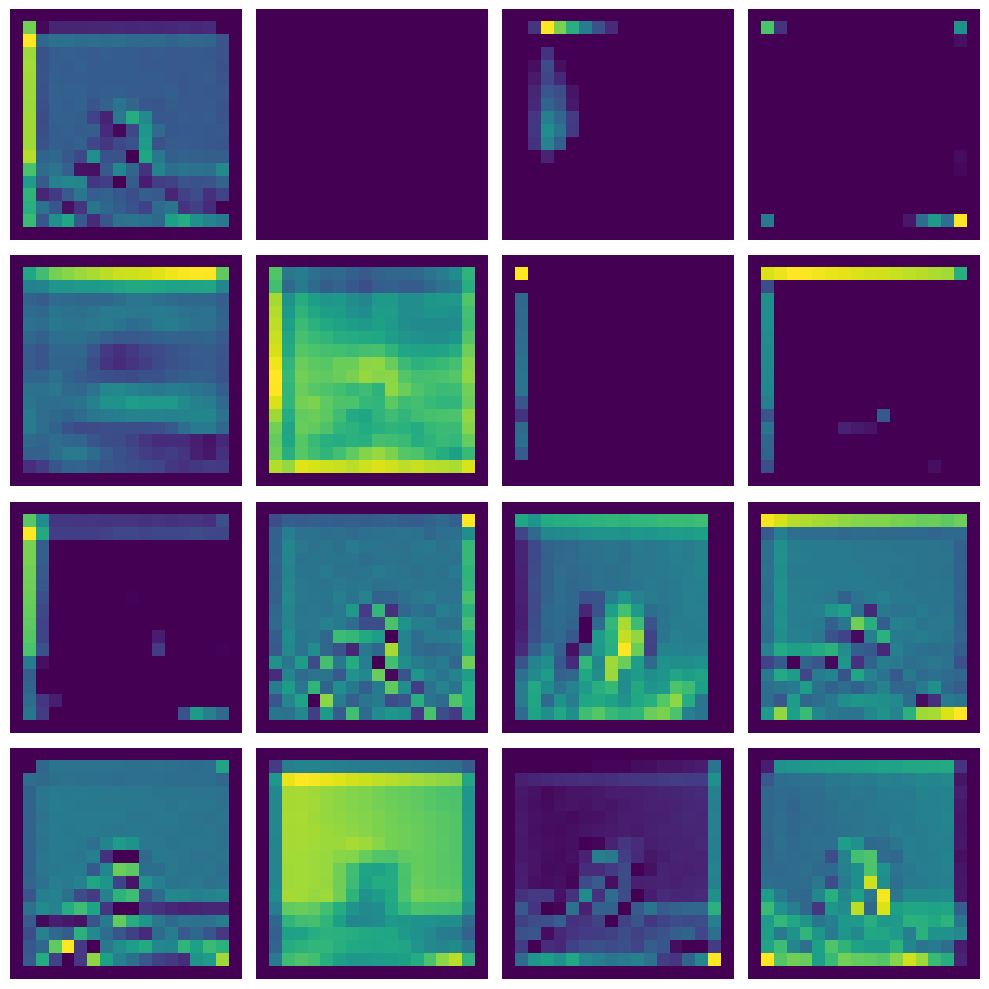

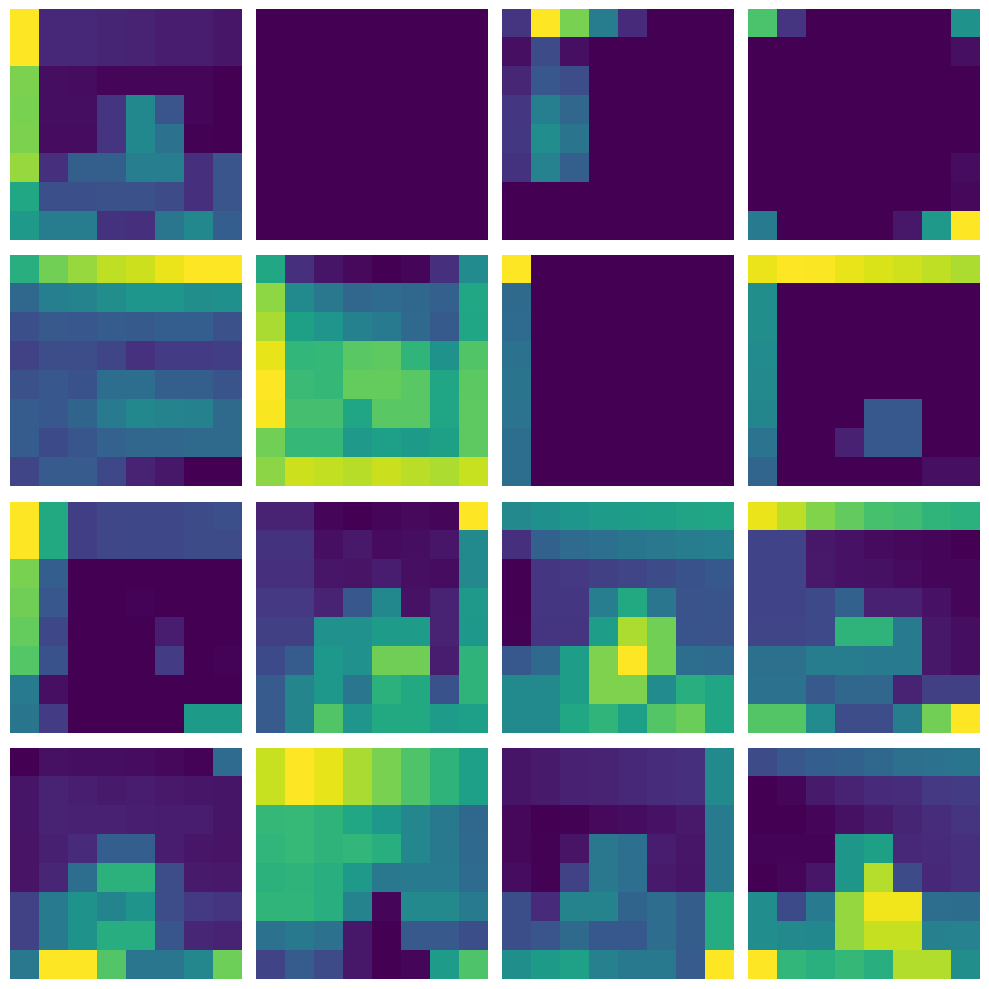

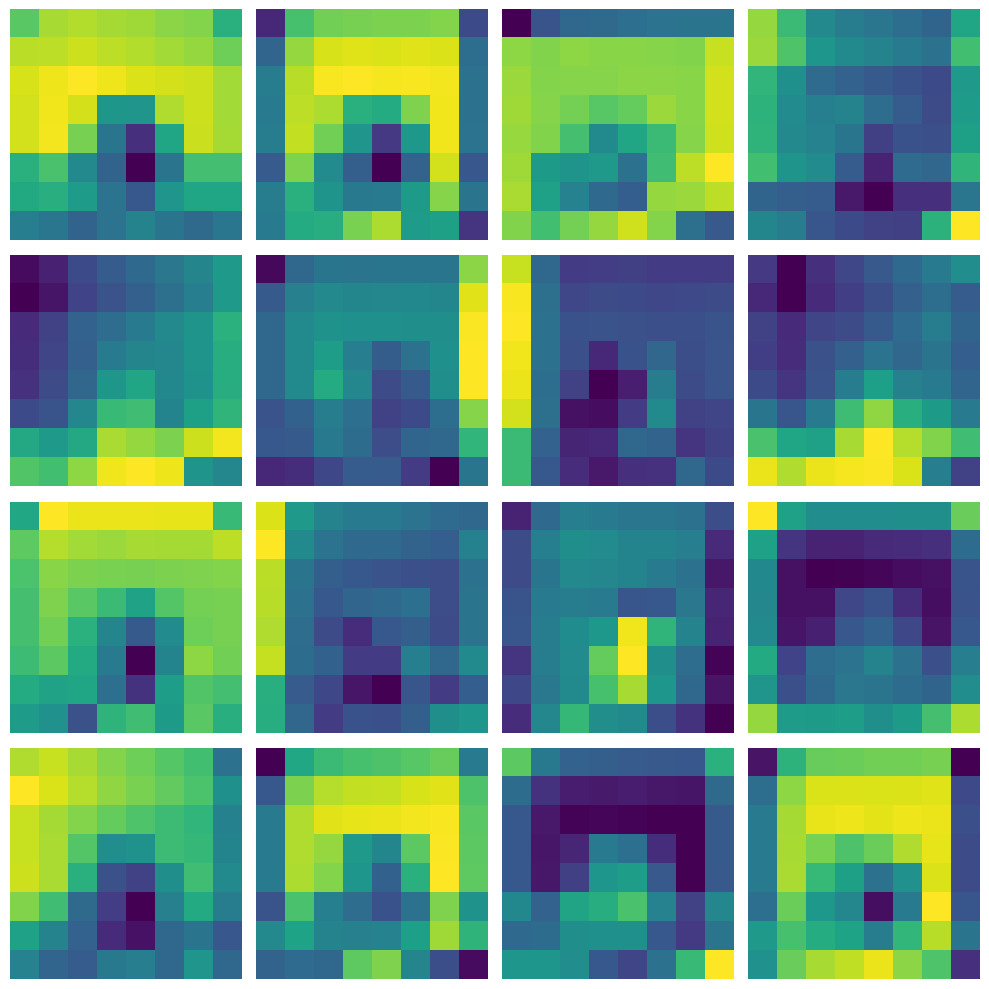

In [ ]:
# Retrieve images from class
class_indices = np.where(binary_train_labels == 1)[0]
class_images = train_data[class_indices]

# Display the first 10 images of class
fig, axes = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    ax = axes[i]
    ax.imshow(class_images[i])
    ax.axis('off')

plt.tight_layout()
plt.show()

# Define a function to display activations for a specific layer and image
def display_activation(activations, col_size, row_size, layer_index):
    activation = activations[layer_index]

    num_features = col_size * row_size

    # Check if the layer has enough feature maps to display
    if activation.shape[-1] < num_features:
        print(f"Layer {layer_index} has only {activation.shape[-1]} feature maps.")
        return

    # Initialize the display grid
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5, col_size*2.5))

    for row in range(0, row_size):
        for col in range(0, col_size):
            activation_index = col + (row * col_size)

            # Display the feature map
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='viridis')
            ax[row][col].axis('off')

    plt.tight_layout()
    plt.show()


layer_outputs = [layer.output for layer in resnet_submodel.layers[:8]]
activation_model = Model(inputs=resnet_submodel.input, outputs=layer_outputs)

# Define a function to visualize activations for a given image
def visualize_activations_for_image(img):
    # Preprocess the image
    img = np.expand_dims(img, axis=0)

    # Retrieve the activations for the image
    activations = activation_model.predict(img)

    for layer_index in range(8):  # For each of the top 8 layers
        display_activation(activations, 4, 4, layer_index)

# Loop over a subset of images from class and visualize the activations
for img in class_images[:5]:
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    visualize_activations_for_image(img)

### Filters

In [ ]:
layer_name = 'conv1_conv'
layer = resnet_submodel.get_layer(layer_name)

In [ ]:
weights = layer.weights[0].numpy()
weights = normalize(weights)

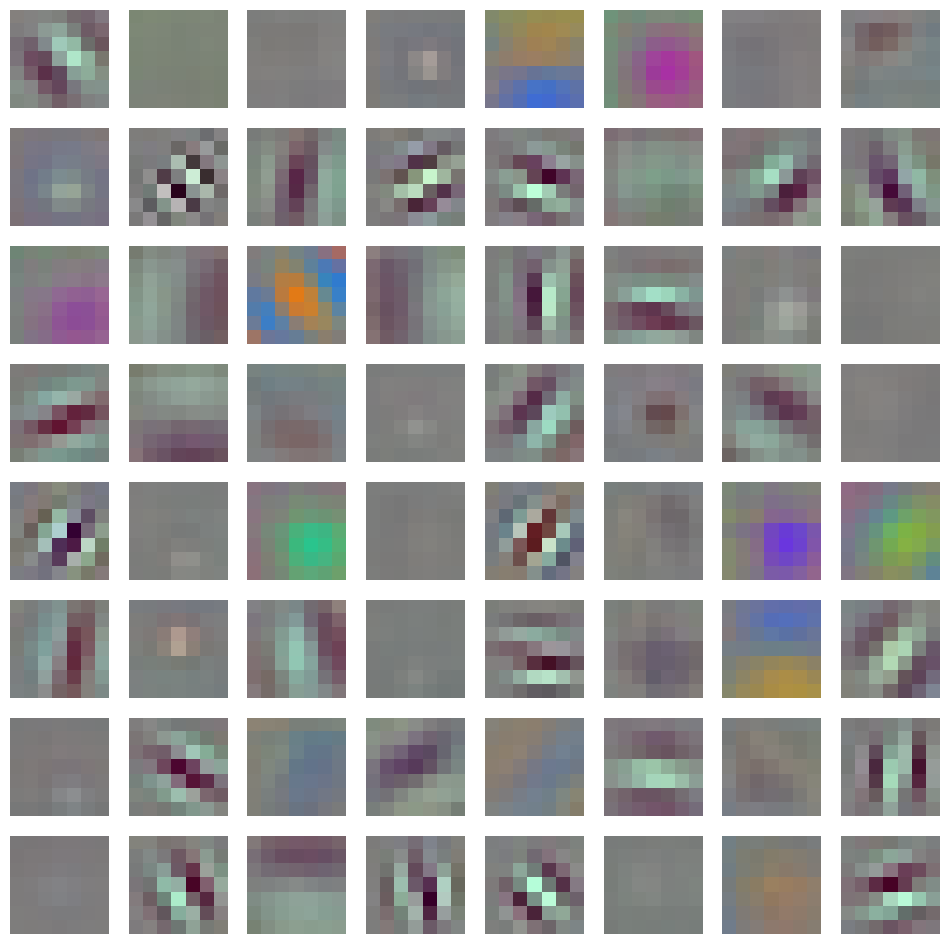

In [ ]:
visualize_filters(weights)

### Heatmap

In [181]:
def generate_heatmap(model, last_conv_layer_name, image):
    # Model for getting the gradients and features
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_output_values, predictions = grad_model(image)
        class_channel = predictions[:, 0]

    # Get the gradients of the output with respect to the features
    grads = tape.gradient(class_channel, conv_output_values)

    # Mean pooling of the gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply features with pooled gradients
    heatmap = tf.multiply(pooled_grads, conv_output_values)
    heatmap = tf.reduce_mean(heatmap, axis=-1)

    # Normalize the heatmap between 0 & 1 for visualization
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap[0]

1/1 [==============================] - 0s 26ms/step


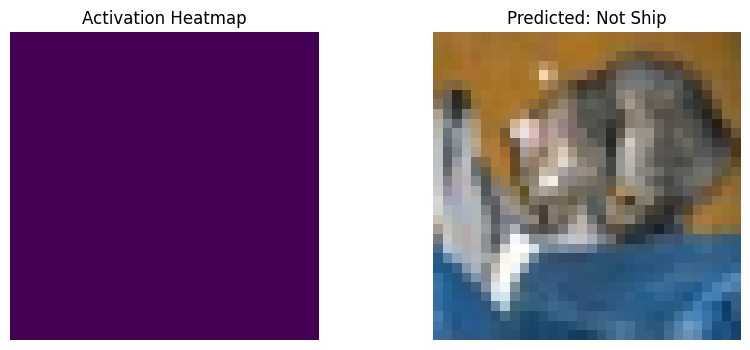

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 22ms/step


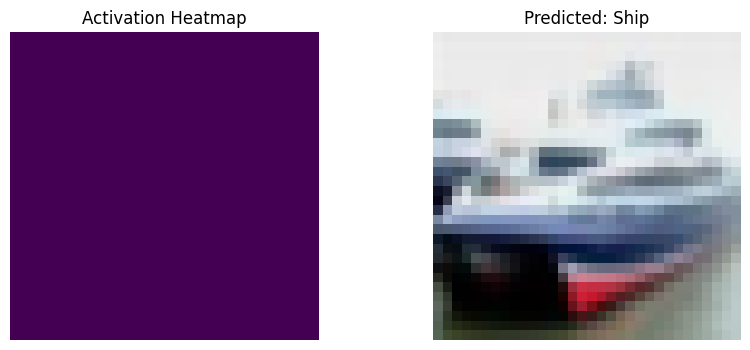

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 23ms/step


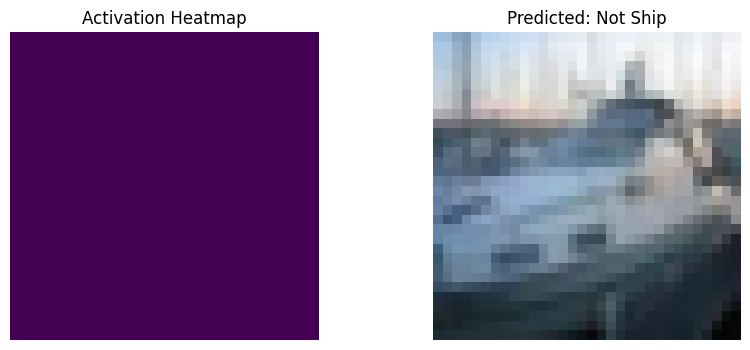

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 25ms/step


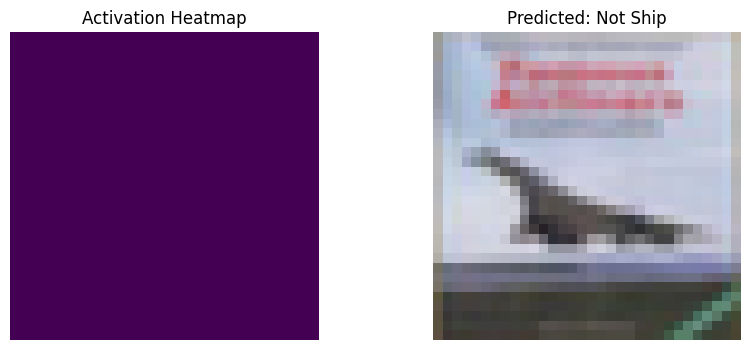

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 35ms/step


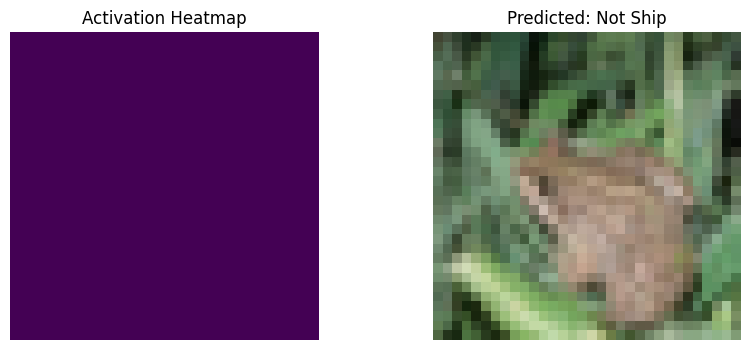

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 35ms/step


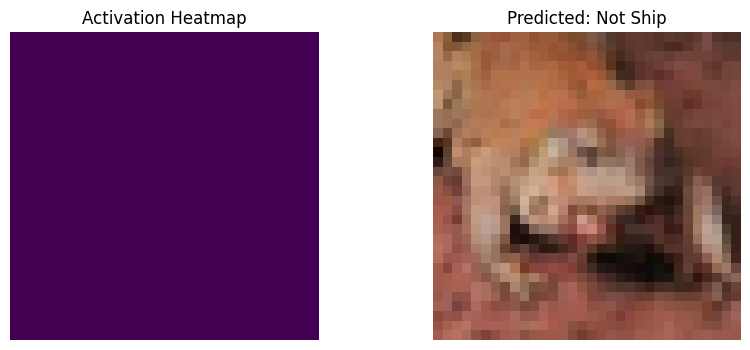

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 37ms/step


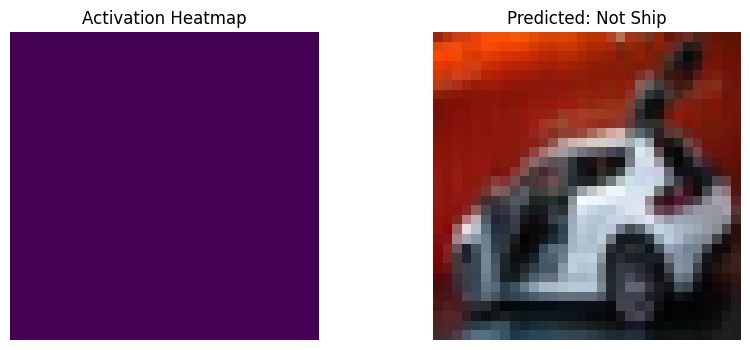

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 32ms/step


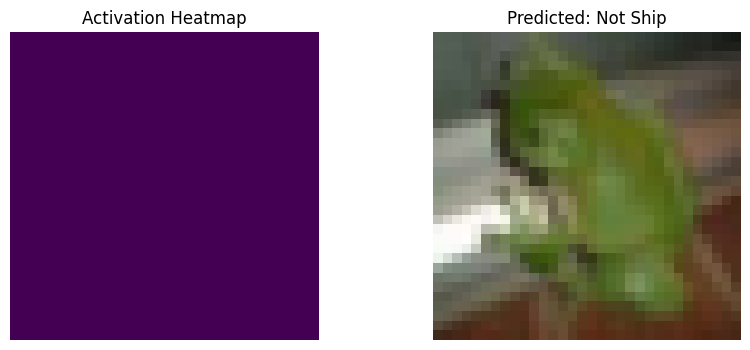

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 25ms/step


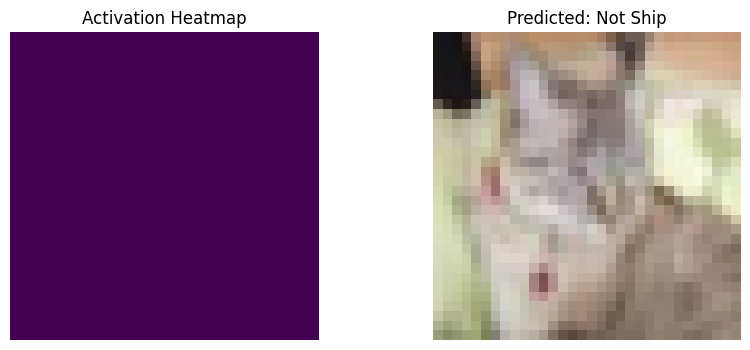

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 22ms/step


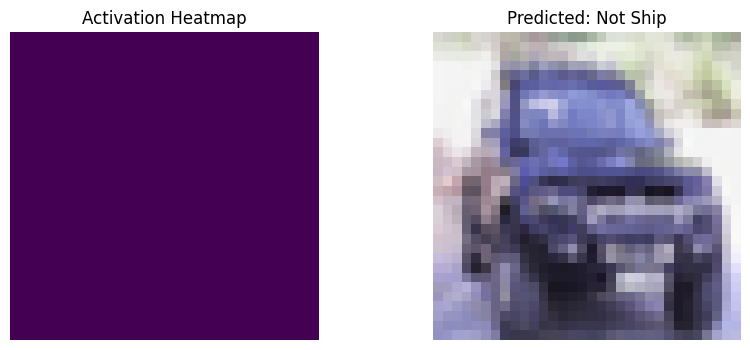

<Figure size 640x480 with 0 Axes>

In [188]:
last_conv_layer_name = "conv5_block3_out"

# Display heatmap for the first 10 images
for i in range(10):
    img = test_data[i]
    img_array = np.expand_dims(img, axis=0)
    heatmap = generate_heatmap(resnet_submodel, last_conv_layer_name, img_array)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.imshow(heatmap)
    plt.title("Activation Heatmap")
    plt.axis("off")

    prediction = binary_model.predict(img_array)

    # Convert prediction to label
    if prediction >= 0.5:
        label = 'Ship'
    else:
        label = 'Not Ship'

    # Plot the image
    plt.subplot(1, 2, 2)
    plt.imshow(test_data[i])
    plt.title(f"Predicted: {label}")
    plt.axis('off')
    plt.show()

    plt.tight_layout()
    plt.show()